In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
import tensorflow.keras.backend as K
from scipy.stats import pearsonr, spearmanr
import sys, os
sys.path.append('../python_scripts/')
import analysis, datasets, analysis_10x10# , baseline
sys.path.append('../imported_code/svcca/')
import cca_core, pwcca
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors
import pandas as pd
from sklearn.manifold import MDS
'''
TODO: Put these in their own files
'''

# Stolen cordially from http://chris35wills.github.io/matplotlib_diverging_colorbar/
class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)
    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))
'''
Plot Helpers
'''

def get_consistency_per_layer(corr_distance, num_layers=9):
    rep_consistency = np.empty(num_layers)
    for i in range(num_layers):
        square = (1 - corr_distance)[10*i:10*i+10, 10*i:10*i+10]
        up_triangle = square[np.triu_indices(n=10, k=1)]
        avg = np.mean(up_triangle)
        rep_consistency[i] = avg
        
    return rep_consistency

def plot_consistency(weights, weights_cb, shuffle, shuffle_cb, both, both_cb):
    # Get consistencies
    w = get_consistency_per_layer(weights)
    s = get_consistency_per_layer(shuffle)
    b = get_consistency_per_layer(both)
    wc = get_consistency_per_layer(weights_cb)
    sc = get_consistency_per_layer(shuffle_cb)
    bc = get_consistency_per_layer(both_cb)
    # Plot
    plt.figure(figsize=(20, 10))
    plt.title('Correlation Consistency Across Layers', fontsize=24)
    plt.plot(w, 'red', label='Weights only')
    plt.plot(wc, 'red', linestyle='dotted', label='Weights only + Cocktail Blank')
    plt.plot(s, 'cornflowerblue', label='Shuffle only')
    plt.plot(sc, 'cornflowerblue', linestyle='dotted', label='Shuffle only + Cocktail Blank')
    plt.plot(b, 'rebeccapurple', label='Weights and Shuffle')
    plt.plot(bc, 'rebeccapurple', linestyle='dotted', label='Weights and Shuffle + Cocktail Blank')
    plt.ylim(0.4, 1)
    plt.legend(fontsize=20)
    
def plot_triple_color(weights, shuffle, both, title):
    # Establish bounds for shared colorbar
    vmin = min(np.amin(weights), np.amin(shuffle), np.amin(both))
    vmax = max(np.amax(weights), np.amax(shuffle), np.amax(both))
    midpoint = vmin + vmax / 2 # Satisfy function
    norm = MidpointNormalize(midpoint=midpoint,vmin=vmin, vmax=vmax)
    # Create graphs
    cf, (cax1, cax2, cax3) = plt.subplots(1, 3)
    cf.suptitle(title, fontsize=24)
    cf.set_size_inches((20, 5.5))
    _  = color_plot_helper('Weights', weights, cax1, norm=norm)
    _  = color_plot_helper('Shuffle', shuffle, cax2, norm=norm)
    im = color_plot_helper('Both', both, cax3, norm=norm)
    # Create shared colorbar
    divider = make_axes_locatable(cax3)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    plt.colorbar(im, cax=cax)

def plot_triple_diff(weights, shuffle, both, title):
    # Create variables for readability
    bw = both - weights
    bs = both - shuffle
    ws = weights - shuffle
    # Establish bounds for shared colorbar (midpoint always 0, keep symmetric)
    _min = min(np.amin(bw), np.amin(bs), np.amin(ws))
    _max = max(np.amax(bw), np.amax(bs), np.amax(ws))
    bound = max(abs(_max), abs(_min))
    norm = MidpointNormalize(midpoint=0,vmin=-bound, vmax=bound)
    # Create graphs
    df, (dax1, dax2, dax3) = plt.subplots(1, 3)
    df.suptitle(title, fontsize=24)
    df.set_size_inches((20, 5.5))
    _  = color_plot_helper('Difference: Both - Weights', bw, dax1, norm=norm, color='seismic')
    _  = color_plot_helper('Difference: Both - Shuffle', bs, dax2, norm=norm, color='seismic')
    im = color_plot_helper('Difference: Weights - Shuffle', ws, dax3, norm=norm, color='seismic')
    # Create shared colorbar
    divider = make_axes_locatable(dax3)
    dax = divider.append_axes("right", size="5%", pad=0.2)
    plt.colorbar(im, cax=dax)

def plot_triple_mds(weights, shuffle, both, title):
    mf, (max1, max2, max3) = plt.subplots(1, 3)
    mf.suptitle(title, fontsize=24)
    mf.set_size_inches((20, 5.5))
    mds_plot_helper('Weights', weights, max1)
    mds_plot_helper('Shuffle', shuffle, max2)
    mds_plot_helper('Both', both, max3)


def color_plot_helper(title: str, corr_distance, axis, norm=None, color=None):
    axis.set_title(title, fontsize=16)
    axis.set_xlabel('layer')
    axis.set_xticks(ticks=[5, 15, 25, 35, 45, 55, 65, 75, 85])
    axis.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9])
    axis.set_yticks(ticks=[5, 15, 25, 35, 45, 55, 65, 75, 85])
    axis.set_yticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9])
    axis.set_ylabel('layer')
    cmap = plt.get_cmap(color)
    im = axis.imshow(corr_distance, origin='upper', cmap=cmap, norm=norm)
    return im

def mds_plot_helper(title: str, corr_distance, axis):
    embedding = MDS(n_components=2, dissimilarity='precomputed')
    X_transformed = embedding.fit_transform(corr_distance)
    
    axis.set_title(title, fontsize=16)
    colors = ['#f5f59d', '#f5b642', '#f58742', '#f55442', '#c940c5',
              '#b407ed', '#7d09d6', '#50017a', '#000000']
    for i in range(10):
        axis.set(adjustable='box', aspect='equal')
        axis.plot(X_transformed[i::10, 0], X_transformed[i::10, 1], linestyle='-', color='black', zorder=1)
        axis.scatter(X_transformed[i::10, 0], X_transformed[i::10, 1], marker='o', color=colors, zorder=2)

In [2]:
'''
Get Training Stats
'''
# TODO: Clean up this code organize the notebook
def get_training_metrics(path_to_instances, testData): # testData loaded from below
    losses = []
    accs = []
    instances = os.listdir(path_to_instances)
    for instance in instances:
        # Skip any non-model files that may have snuck in
        if '.h5' not in instance:
            continue
        print(instance)
        K.clear_session()
        model = load_model(path_to_instances+instance)
        results = model.evaluate(testData.prefetch(tf.data.experimental.AUTOTUNE)\
                                 .batch(128))
        accs.append(results[1])
        
    return np.array(accs)

def get_column(accs, total):
    sr = 10/total
    _min = np.amin(accs)
    _max = np.amax(accs)
    mean = np.mean(accs)
    med = np.median(accs)
    return [_max, _min, mean, med, sr]

w_accs = get_training_metrics('../outputs/models/primary/', testData)
s_accs = get_training_metrics('../outputs/models/shuffle_seed/', testData)
b_accs = get_training_metrics('../outputs/models/both/', testData)

data = np.array([get_column(w_accs, 15),
                get_column(s_accs, 26),
                get_column(b_accs, 14)])
index = ['weights', 'shuffle', 'both']
columns = ['max acc', 'min acc', 'mean acc', 'med acc', 'success rate']

NameError: name 'testData' is not defined

In [10]:
df = pd.DataFrame(data=data, index=index, columns=columns)
df

max acc  min acc  mean acc  med acc  success rate
weights   0.8520   0.8371   0.84430  0.84480      0.666667
shuffle   0.8445   0.8328   0.83886  0.83865      0.384615
both      0.8477   0.8342   0.84252  0.84285      0.714286

# 1. Gathering Data and Correlations

In [9]:
'''
Load Data
'''
import datasets
_, testData = datasets.make_train_data(None)
x_predict, _ = datasets.make_predict_data(testData)

Making train data...
GCN...
ZCA...
Done!
Making test data...
Done!


In [98]:
'''
Calculate RSA
'''
rsa_weights = 1 - analysis.correlate('RSA', '../outputs/models/primary/', x_predict)
rsa_shuffle = 1 - analysis.correlate('RSA', '../outputs/models/shuffle_seed/', x_predict)
rsa_both = 1 - analysis.correlate('RSA', '../outputs/models/both/', x_predict)

**** Load and Preprocess Acts ****
*** Working on instance_303.h5 ***
Layer 0
Getting activations...
Layer 1
Getting activations...
Layer 2
Getting activations...
Layer 3
Getting activations...
Layer 4
Getting activations...
Layer 5
Getting activations...
Layer 6
Getting activations...
Layer 7
Getting activations...
Layer 8
Getting activations...
* Preprocessing...
shape: (1000, 98304)
num_images = 1000
* Preprocessing...
shape: (1000, 98304)
num_images = 1000
* Preprocessing...
shape: (1000, 24576)
num_images = 1000
* Preprocessing...
shape: (1000, 49152)
num_images = 1000
* Preprocessing...
shape: (1000, 49152)
num_images = 1000
* Preprocessing...
shape: (1000, 12288)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 360)
num_images = 1000
*** Working on instance_207.h5 ***
Layer 0
Getting activations...
Layer 1
Getting activations...
Layer 2
Getting activations...
Layer

* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 360)
num_images = 1000
**** Done gathering RDMs, now correlations ****
Correlation 0 , 0
Correlation 1 , 0
Correlation 1 , 1
Correlation 2 , 0
Correlation 2 , 1
Correlation 2 , 2
Correlation 3 , 0
Correlation 3 , 1
Correlation 3 , 2
Correlation 3 , 3
Correlation 4 , 0
Correlation 4 , 1
Correlation 4 , 2
Correlation 4 , 3
Correlation 4 , 4
Correlation 5 , 0
Correlation 5 , 1
Correlation 5 , 2
Correlation 5 , 3
Correlation 5 , 4
Correlation 5 , 5
Correlation 6 , 0
Correlation 6 , 1
Correlation 6 , 2
Correlation 6 , 3
Correlation 6 , 4
Correlation 6 , 5
Correlation 6 , 6
Correlation 7 , 0
Correlation 7 , 1
Correlation 7 , 2
Correlation 7 , 3
Correlation 7 , 4
Correlation 7 , 5
Correlation 7 , 6
Correlation 7 , 7
Correlation 8 , 0
Correlation 8 , 1
Correlation 8 , 2
Correlation 8 , 3
Correlation 8 , 4
Correlation 8 , 5
Correlation 8 , 6
Correlation 8 , 7
Correlation 8 , 8
Correlation 9 , 0
Correlation

Correlation 28 , 12
Correlation 28 , 13
Correlation 28 , 14
Correlation 28 , 15
Correlation 28 , 16
Correlation 28 , 17
Correlation 28 , 18
Correlation 28 , 19
Correlation 28 , 20
Correlation 28 , 21
Correlation 28 , 22
Correlation 28 , 23
Correlation 28 , 24
Correlation 28 , 25
Correlation 28 , 26
Correlation 28 , 27
Correlation 28 , 28
Correlation 29 , 0
Correlation 29 , 1
Correlation 29 , 2
Correlation 29 , 3
Correlation 29 , 4
Correlation 29 , 5
Correlation 29 , 6
Correlation 29 , 7
Correlation 29 , 8
Correlation 29 , 9
Correlation 29 , 10
Correlation 29 , 11
Correlation 29 , 12
Correlation 29 , 13
Correlation 29 , 14
Correlation 29 , 15
Correlation 29 , 16
Correlation 29 , 17
Correlation 29 , 18
Correlation 29 , 19
Correlation 29 , 20
Correlation 29 , 21
Correlation 29 , 22
Correlation 29 , 23
Correlation 29 , 24
Correlation 29 , 25
Correlation 29 , 26
Correlation 29 , 27
Correlation 29 , 28
Correlation 29 , 29
Correlation 30 , 0
Correlation 30 , 1
Correlation 30 , 2
Correlation 3

Correlation 40 , 16
Correlation 40 , 17
Correlation 40 , 18
Correlation 40 , 19
Correlation 40 , 20
Correlation 40 , 21
Correlation 40 , 22
Correlation 40 , 23
Correlation 40 , 24
Correlation 40 , 25
Correlation 40 , 26
Correlation 40 , 27
Correlation 40 , 28
Correlation 40 , 29
Correlation 40 , 30
Correlation 40 , 31
Correlation 40 , 32
Correlation 40 , 33
Correlation 40 , 34
Correlation 40 , 35
Correlation 40 , 36
Correlation 40 , 37
Correlation 40 , 38
Correlation 40 , 39
Correlation 40 , 40
Correlation 41 , 0
Correlation 41 , 1
Correlation 41 , 2
Correlation 41 , 3
Correlation 41 , 4
Correlation 41 , 5
Correlation 41 , 6
Correlation 41 , 7
Correlation 41 , 8
Correlation 41 , 9
Correlation 41 , 10
Correlation 41 , 11
Correlation 41 , 12
Correlation 41 , 13
Correlation 41 , 14
Correlation 41 , 15
Correlation 41 , 16
Correlation 41 , 17
Correlation 41 , 18
Correlation 41 , 19
Correlation 41 , 20
Correlation 41 , 21
Correlation 41 , 22
Correlation 41 , 23
Correlation 41 , 24
Correlatio

Correlation 49 , 28
Correlation 49 , 29
Correlation 49 , 30
Correlation 49 , 31
Correlation 49 , 32
Correlation 49 , 33
Correlation 49 , 34
Correlation 49 , 35
Correlation 49 , 36
Correlation 49 , 37
Correlation 49 , 38
Correlation 49 , 39
Correlation 49 , 40
Correlation 49 , 41
Correlation 49 , 42
Correlation 49 , 43
Correlation 49 , 44
Correlation 49 , 45
Correlation 49 , 46
Correlation 49 , 47
Correlation 49 , 48
Correlation 49 , 49
Correlation 50 , 0
Correlation 50 , 1
Correlation 50 , 2
Correlation 50 , 3
Correlation 50 , 4
Correlation 50 , 5
Correlation 50 , 6
Correlation 50 , 7
Correlation 50 , 8
Correlation 50 , 9
Correlation 50 , 10
Correlation 50 , 11
Correlation 50 , 12
Correlation 50 , 13
Correlation 50 , 14
Correlation 50 , 15
Correlation 50 , 16
Correlation 50 , 17
Correlation 50 , 18
Correlation 50 , 19
Correlation 50 , 20
Correlation 50 , 21
Correlation 50 , 22
Correlation 50 , 23
Correlation 50 , 24
Correlation 50 , 25
Correlation 50 , 26
Correlation 50 , 27
Correlatio

Correlation 57 , 14
Correlation 57 , 15
Correlation 57 , 16
Correlation 57 , 17
Correlation 57 , 18
Correlation 57 , 19
Correlation 57 , 20
Correlation 57 , 21
Correlation 57 , 22
Correlation 57 , 23
Correlation 57 , 24
Correlation 57 , 25
Correlation 57 , 26
Correlation 57 , 27
Correlation 57 , 28
Correlation 57 , 29
Correlation 57 , 30
Correlation 57 , 31
Correlation 57 , 32
Correlation 57 , 33
Correlation 57 , 34
Correlation 57 , 35
Correlation 57 , 36
Correlation 57 , 37
Correlation 57 , 38
Correlation 57 , 39
Correlation 57 , 40
Correlation 57 , 41
Correlation 57 , 42
Correlation 57 , 43
Correlation 57 , 44
Correlation 57 , 45
Correlation 57 , 46
Correlation 57 , 47
Correlation 57 , 48
Correlation 57 , 49
Correlation 57 , 50
Correlation 57 , 51
Correlation 57 , 52
Correlation 57 , 53
Correlation 57 , 54
Correlation 57 , 55
Correlation 57 , 56
Correlation 57 , 57
Correlation 58 , 0
Correlation 58 , 1
Correlation 58 , 2
Correlation 58 , 3
Correlation 58 , 4
Correlation 58 , 5
Correl

Correlation 64 , 4
Correlation 64 , 5
Correlation 64 , 6
Correlation 64 , 7
Correlation 64 , 8
Correlation 64 , 9
Correlation 64 , 10
Correlation 64 , 11
Correlation 64 , 12
Correlation 64 , 13
Correlation 64 , 14
Correlation 64 , 15
Correlation 64 , 16
Correlation 64 , 17
Correlation 64 , 18
Correlation 64 , 19
Correlation 64 , 20
Correlation 64 , 21
Correlation 64 , 22
Correlation 64 , 23
Correlation 64 , 24
Correlation 64 , 25
Correlation 64 , 26
Correlation 64 , 27
Correlation 64 , 28
Correlation 64 , 29
Correlation 64 , 30
Correlation 64 , 31
Correlation 64 , 32
Correlation 64 , 33
Correlation 64 , 34
Correlation 64 , 35
Correlation 64 , 36
Correlation 64 , 37
Correlation 64 , 38
Correlation 64 , 39
Correlation 64 , 40
Correlation 64 , 41
Correlation 64 , 42
Correlation 64 , 43
Correlation 64 , 44
Correlation 64 , 45
Correlation 64 , 46
Correlation 64 , 47
Correlation 64 , 48
Correlation 64 , 49
Correlation 64 , 50
Correlation 64 , 51
Correlation 64 , 52
Correlation 64 , 53
Correl

Correlation 70 , 14
Correlation 70 , 15
Correlation 70 , 16
Correlation 70 , 17
Correlation 70 , 18
Correlation 70 , 19
Correlation 70 , 20
Correlation 70 , 21
Correlation 70 , 22
Correlation 70 , 23
Correlation 70 , 24
Correlation 70 , 25
Correlation 70 , 26
Correlation 70 , 27
Correlation 70 , 28
Correlation 70 , 29
Correlation 70 , 30
Correlation 70 , 31
Correlation 70 , 32
Correlation 70 , 33
Correlation 70 , 34
Correlation 70 , 35
Correlation 70 , 36
Correlation 70 , 37
Correlation 70 , 38
Correlation 70 , 39
Correlation 70 , 40
Correlation 70 , 41
Correlation 70 , 42
Correlation 70 , 43
Correlation 70 , 44
Correlation 70 , 45
Correlation 70 , 46
Correlation 70 , 47
Correlation 70 , 48
Correlation 70 , 49
Correlation 70 , 50
Correlation 70 , 51
Correlation 70 , 52
Correlation 70 , 53
Correlation 70 , 54
Correlation 70 , 55
Correlation 70 , 56
Correlation 70 , 57
Correlation 70 , 58
Correlation 70 , 59
Correlation 70 , 60
Correlation 70 , 61
Correlation 70 , 62
Correlation 70 , 63


Correlation 75 , 65
Correlation 75 , 66
Correlation 75 , 67
Correlation 75 , 68
Correlation 75 , 69
Correlation 75 , 70
Correlation 75 , 71
Correlation 75 , 72
Correlation 75 , 73
Correlation 75 , 74
Correlation 75 , 75
Correlation 76 , 0
Correlation 76 , 1
Correlation 76 , 2
Correlation 76 , 3
Correlation 76 , 4
Correlation 76 , 5
Correlation 76 , 6
Correlation 76 , 7
Correlation 76 , 8
Correlation 76 , 9
Correlation 76 , 10
Correlation 76 , 11
Correlation 76 , 12
Correlation 76 , 13
Correlation 76 , 14
Correlation 76 , 15
Correlation 76 , 16
Correlation 76 , 17
Correlation 76 , 18
Correlation 76 , 19
Correlation 76 , 20
Correlation 76 , 21
Correlation 76 , 22
Correlation 76 , 23
Correlation 76 , 24
Correlation 76 , 25
Correlation 76 , 26
Correlation 76 , 27
Correlation 76 , 28
Correlation 76 , 29
Correlation 76 , 30
Correlation 76 , 31
Correlation 76 , 32
Correlation 76 , 33
Correlation 76 , 34
Correlation 76 , 35
Correlation 76 , 36
Correlation 76 , 37
Correlation 76 , 38
Correlatio

Correlation 81 , 11
Correlation 81 , 12
Correlation 81 , 13
Correlation 81 , 14
Correlation 81 , 15
Correlation 81 , 16
Correlation 81 , 17
Correlation 81 , 18
Correlation 81 , 19
Correlation 81 , 20
Correlation 81 , 21
Correlation 81 , 22
Correlation 81 , 23
Correlation 81 , 24
Correlation 81 , 25
Correlation 81 , 26
Correlation 81 , 27
Correlation 81 , 28
Correlation 81 , 29
Correlation 81 , 30
Correlation 81 , 31
Correlation 81 , 32
Correlation 81 , 33
Correlation 81 , 34
Correlation 81 , 35
Correlation 81 , 36
Correlation 81 , 37
Correlation 81 , 38
Correlation 81 , 39
Correlation 81 , 40
Correlation 81 , 41
Correlation 81 , 42
Correlation 81 , 43
Correlation 81 , 44
Correlation 81 , 45
Correlation 81 , 46
Correlation 81 , 47
Correlation 81 , 48
Correlation 81 , 49
Correlation 81 , 50
Correlation 81 , 51
Correlation 81 , 52
Correlation 81 , 53
Correlation 81 , 54
Correlation 81 , 55
Correlation 81 , 56
Correlation 81 , 57
Correlation 81 , 58
Correlation 81 , 59
Correlation 81 , 60


Correlation 86 , 4
Correlation 86 , 5
Correlation 86 , 6
Correlation 86 , 7
Correlation 86 , 8
Correlation 86 , 9
Correlation 86 , 10
Correlation 86 , 11
Correlation 86 , 12
Correlation 86 , 13
Correlation 86 , 14
Correlation 86 , 15
Correlation 86 , 16
Correlation 86 , 17
Correlation 86 , 18
Correlation 86 , 19
Correlation 86 , 20
Correlation 86 , 21
Correlation 86 , 22
Correlation 86 , 23
Correlation 86 , 24
Correlation 86 , 25
Correlation 86 , 26
Correlation 86 , 27
Correlation 86 , 28
Correlation 86 , 29
Correlation 86 , 30
Correlation 86 , 31
Correlation 86 , 32
Correlation 86 , 33
Correlation 86 , 34
Correlation 86 , 35
Correlation 86 , 36
Correlation 86 , 37
Correlation 86 , 38
Correlation 86 , 39
Correlation 86 , 40
Correlation 86 , 41
Correlation 86 , 42
Correlation 86 , 43
Correlation 86 , 44
Correlation 86 , 45
Correlation 86 , 46
Correlation 86 , 47
Correlation 86 , 48
Correlation 86 , 49
Correlation 86 , 50
Correlation 86 , 51
Correlation 86 , 52
Correlation 86 , 53
Correl

* Preprocessing...
shape: (1000, 98304)
num_images = 1000
* Preprocessing...
shape: (1000, 24576)
num_images = 1000
* Preprocessing...
shape: (1000, 49152)
num_images = 1000
* Preprocessing...
shape: (1000, 49152)
num_images = 1000
* Preprocessing...
shape: (1000, 12288)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 360)
num_images = 1000
*** Working on instance_1012.h5 ***
Layer 0
Getting activations...
Layer 1
Getting activations...
Layer 2
Getting activations...
Layer 3
Getting activations...
Layer 4
Getting activations...
Layer 5
Getting activations...
Layer 6
Getting activations...
Layer 7
Getting activations...
Layer 8
Getting activations...
* Preprocessing...
shape: (1000, 98304)
num_images = 1000
* Preprocessing...
shape: (1000, 98304)
num_images = 1000
* Preprocessing...
shape: (1000, 24576)
num_images = 1000
* Preprocessing...
shape: (1000, 49152)
num_images 

Correlation 10 , 5
Correlation 10 , 6
Correlation 10 , 7
Correlation 10 , 8
Correlation 10 , 9
Correlation 10 , 10
Correlation 11 , 0
Correlation 11 , 1
Correlation 11 , 2
Correlation 11 , 3
Correlation 11 , 4
Correlation 11 , 5
Correlation 11 , 6
Correlation 11 , 7
Correlation 11 , 8
Correlation 11 , 9
Correlation 11 , 10
Correlation 11 , 11
Correlation 12 , 0
Correlation 12 , 1
Correlation 12 , 2
Correlation 12 , 3
Correlation 12 , 4
Correlation 12 , 5
Correlation 12 , 6
Correlation 12 , 7
Correlation 12 , 8
Correlation 12 , 9
Correlation 12 , 10
Correlation 12 , 11
Correlation 12 , 12
Correlation 13 , 0
Correlation 13 , 1
Correlation 13 , 2
Correlation 13 , 3
Correlation 13 , 4
Correlation 13 , 5
Correlation 13 , 6
Correlation 13 , 7
Correlation 13 , 8
Correlation 13 , 9
Correlation 13 , 10
Correlation 13 , 11
Correlation 13 , 12
Correlation 13 , 13
Correlation 14 , 0
Correlation 14 , 1
Correlation 14 , 2
Correlation 14 , 3
Correlation 14 , 4
Correlation 14 , 5
Correlation 14 , 6
Co

Correlation 30 , 15
Correlation 30 , 16
Correlation 30 , 17
Correlation 30 , 18
Correlation 30 , 19
Correlation 30 , 20
Correlation 30 , 21
Correlation 30 , 22
Correlation 30 , 23
Correlation 30 , 24
Correlation 30 , 25
Correlation 30 , 26
Correlation 30 , 27
Correlation 30 , 28
Correlation 30 , 29
Correlation 30 , 30
Correlation 31 , 0
Correlation 31 , 1
Correlation 31 , 2
Correlation 31 , 3
Correlation 31 , 4
Correlation 31 , 5
Correlation 31 , 6
Correlation 31 , 7
Correlation 31 , 8
Correlation 31 , 9
Correlation 31 , 10
Correlation 31 , 11
Correlation 31 , 12
Correlation 31 , 13
Correlation 31 , 14
Correlation 31 , 15
Correlation 31 , 16
Correlation 31 , 17
Correlation 31 , 18
Correlation 31 , 19
Correlation 31 , 20
Correlation 31 , 21
Correlation 31 , 22
Correlation 31 , 23
Correlation 31 , 24
Correlation 31 , 25
Correlation 31 , 26
Correlation 31 , 27
Correlation 31 , 28
Correlation 31 , 29
Correlation 31 , 30
Correlation 31 , 31
Correlation 32 , 0
Correlation 32 , 1
Correlation 

Correlation 41 , 36
Correlation 41 , 37
Correlation 41 , 38
Correlation 41 , 39
Correlation 41 , 40
Correlation 41 , 41
Correlation 42 , 0
Correlation 42 , 1
Correlation 42 , 2
Correlation 42 , 3
Correlation 42 , 4
Correlation 42 , 5
Correlation 42 , 6
Correlation 42 , 7
Correlation 42 , 8
Correlation 42 , 9
Correlation 42 , 10
Correlation 42 , 11
Correlation 42 , 12
Correlation 42 , 13
Correlation 42 , 14
Correlation 42 , 15
Correlation 42 , 16
Correlation 42 , 17
Correlation 42 , 18
Correlation 42 , 19
Correlation 42 , 20
Correlation 42 , 21
Correlation 42 , 22
Correlation 42 , 23
Correlation 42 , 24
Correlation 42 , 25
Correlation 42 , 26
Correlation 42 , 27
Correlation 42 , 28
Correlation 42 , 29
Correlation 42 , 30
Correlation 42 , 31
Correlation 42 , 32
Correlation 42 , 33
Correlation 42 , 34
Correlation 42 , 35
Correlation 42 , 36
Correlation 42 , 37
Correlation 42 , 38
Correlation 42 , 39
Correlation 42 , 40
Correlation 42 , 41
Correlation 42 , 42
Correlation 43 , 0
Correlation

Correlation 50 , 41
Correlation 50 , 42
Correlation 50 , 43
Correlation 50 , 44
Correlation 50 , 45
Correlation 50 , 46
Correlation 50 , 47
Correlation 50 , 48
Correlation 50 , 49
Correlation 50 , 50
Correlation 51 , 0
Correlation 51 , 1
Correlation 51 , 2
Correlation 51 , 3
Correlation 51 , 4
Correlation 51 , 5
Correlation 51 , 6
Correlation 51 , 7
Correlation 51 , 8
Correlation 51 , 9
Correlation 51 , 10
Correlation 51 , 11
Correlation 51 , 12
Correlation 51 , 13
Correlation 51 , 14
Correlation 51 , 15
Correlation 51 , 16
Correlation 51 , 17
Correlation 51 , 18
Correlation 51 , 19
Correlation 51 , 20
Correlation 51 , 21
Correlation 51 , 22
Correlation 51 , 23
Correlation 51 , 24
Correlation 51 , 25
Correlation 51 , 26
Correlation 51 , 27
Correlation 51 , 28
Correlation 51 , 29
Correlation 51 , 30
Correlation 51 , 31
Correlation 51 , 32
Correlation 51 , 33
Correlation 51 , 34
Correlation 51 , 35
Correlation 51 , 36
Correlation 51 , 37
Correlation 51 , 38
Correlation 51 , 39
Correlatio

Correlation 58 , 21
Correlation 58 , 22
Correlation 58 , 23
Correlation 58 , 24
Correlation 58 , 25
Correlation 58 , 26
Correlation 58 , 27
Correlation 58 , 28
Correlation 58 , 29
Correlation 58 , 30
Correlation 58 , 31
Correlation 58 , 32
Correlation 58 , 33
Correlation 58 , 34
Correlation 58 , 35
Correlation 58 , 36
Correlation 58 , 37
Correlation 58 , 38
Correlation 58 , 39
Correlation 58 , 40
Correlation 58 , 41
Correlation 58 , 42
Correlation 58 , 43
Correlation 58 , 44
Correlation 58 , 45
Correlation 58 , 46
Correlation 58 , 47
Correlation 58 , 48
Correlation 58 , 49
Correlation 58 , 50
Correlation 58 , 51
Correlation 58 , 52
Correlation 58 , 53
Correlation 58 , 54
Correlation 58 , 55
Correlation 58 , 56
Correlation 58 , 57
Correlation 58 , 58
Correlation 59 , 0
Correlation 59 , 1
Correlation 59 , 2
Correlation 59 , 3
Correlation 59 , 4
Correlation 59 , 5
Correlation 59 , 6
Correlation 59 , 7
Correlation 59 , 8
Correlation 59 , 9
Correlation 59 , 10
Correlation 59 , 11
Correlatio

Correlation 65 , 3
Correlation 65 , 4
Correlation 65 , 5
Correlation 65 , 6
Correlation 65 , 7
Correlation 65 , 8
Correlation 65 , 9
Correlation 65 , 10
Correlation 65 , 11
Correlation 65 , 12
Correlation 65 , 13
Correlation 65 , 14
Correlation 65 , 15
Correlation 65 , 16
Correlation 65 , 17
Correlation 65 , 18
Correlation 65 , 19
Correlation 65 , 20
Correlation 65 , 21
Correlation 65 , 22
Correlation 65 , 23
Correlation 65 , 24
Correlation 65 , 25
Correlation 65 , 26
Correlation 65 , 27
Correlation 65 , 28
Correlation 65 , 29
Correlation 65 , 30
Correlation 65 , 31
Correlation 65 , 32
Correlation 65 , 33
Correlation 65 , 34
Correlation 65 , 35
Correlation 65 , 36
Correlation 65 , 37
Correlation 65 , 38
Correlation 65 , 39
Correlation 65 , 40
Correlation 65 , 41
Correlation 65 , 42
Correlation 65 , 43
Correlation 65 , 44
Correlation 65 , 45
Correlation 65 , 46
Correlation 65 , 47
Correlation 65 , 48
Correlation 65 , 49
Correlation 65 , 50
Correlation 65 , 51
Correlation 65 , 52
Correla

Correlation 71 , 9
Correlation 71 , 10
Correlation 71 , 11
Correlation 71 , 12
Correlation 71 , 13
Correlation 71 , 14
Correlation 71 , 15
Correlation 71 , 16
Correlation 71 , 17
Correlation 71 , 18
Correlation 71 , 19
Correlation 71 , 20
Correlation 71 , 21
Correlation 71 , 22
Correlation 71 , 23
Correlation 71 , 24
Correlation 71 , 25
Correlation 71 , 26
Correlation 71 , 27
Correlation 71 , 28
Correlation 71 , 29
Correlation 71 , 30
Correlation 71 , 31
Correlation 71 , 32
Correlation 71 , 33
Correlation 71 , 34
Correlation 71 , 35
Correlation 71 , 36
Correlation 71 , 37
Correlation 71 , 38
Correlation 71 , 39
Correlation 71 , 40
Correlation 71 , 41
Correlation 71 , 42
Correlation 71 , 43
Correlation 71 , 44
Correlation 71 , 45
Correlation 71 , 46
Correlation 71 , 47
Correlation 71 , 48
Correlation 71 , 49
Correlation 71 , 50
Correlation 71 , 51
Correlation 71 , 52
Correlation 71 , 53
Correlation 71 , 54
Correlation 71 , 55
Correlation 71 , 56
Correlation 71 , 57
Correlation 71 , 58
C

Correlation 76 , 52
Correlation 76 , 53
Correlation 76 , 54
Correlation 76 , 55
Correlation 76 , 56
Correlation 76 , 57
Correlation 76 , 58
Correlation 76 , 59
Correlation 76 , 60
Correlation 76 , 61
Correlation 76 , 62
Correlation 76 , 63
Correlation 76 , 64
Correlation 76 , 65
Correlation 76 , 66
Correlation 76 , 67
Correlation 76 , 68
Correlation 76 , 69
Correlation 76 , 70
Correlation 76 , 71
Correlation 76 , 72
Correlation 76 , 73
Correlation 76 , 74
Correlation 76 , 75
Correlation 76 , 76
Correlation 77 , 0
Correlation 77 , 1
Correlation 77 , 2
Correlation 77 , 3
Correlation 77 , 4
Correlation 77 , 5
Correlation 77 , 6
Correlation 77 , 7
Correlation 77 , 8
Correlation 77 , 9
Correlation 77 , 10
Correlation 77 , 11
Correlation 77 , 12
Correlation 77 , 13
Correlation 77 , 14
Correlation 77 , 15
Correlation 77 , 16
Correlation 77 , 17
Correlation 77 , 18
Correlation 77 , 19
Correlation 77 , 20
Correlation 77 , 21
Correlation 77 , 22
Correlation 77 , 23
Correlation 77 , 24
Correlatio

Correlation 81 , 71
Correlation 81 , 72
Correlation 81 , 73
Correlation 81 , 74
Correlation 81 , 75
Correlation 81 , 76
Correlation 81 , 77
Correlation 81 , 78
Correlation 81 , 79
Correlation 81 , 80
Correlation 81 , 81
Correlation 82 , 0
Correlation 82 , 1
Correlation 82 , 2
Correlation 82 , 3
Correlation 82 , 4
Correlation 82 , 5
Correlation 82 , 6
Correlation 82 , 7
Correlation 82 , 8
Correlation 82 , 9
Correlation 82 , 10
Correlation 82 , 11
Correlation 82 , 12
Correlation 82 , 13
Correlation 82 , 14
Correlation 82 , 15
Correlation 82 , 16
Correlation 82 , 17
Correlation 82 , 18
Correlation 82 , 19
Correlation 82 , 20
Correlation 82 , 21
Correlation 82 , 22
Correlation 82 , 23
Correlation 82 , 24
Correlation 82 , 25
Correlation 82 , 26
Correlation 82 , 27
Correlation 82 , 28
Correlation 82 , 29
Correlation 82 , 30
Correlation 82 , 31
Correlation 82 , 32
Correlation 82 , 33
Correlation 82 , 34
Correlation 82 , 35
Correlation 82 , 36
Correlation 82 , 37
Correlation 82 , 38
Correlatio

Correlation 86 , 64
Correlation 86 , 65
Correlation 86 , 66
Correlation 86 , 67
Correlation 86 , 68
Correlation 86 , 69
Correlation 86 , 70
Correlation 86 , 71
Correlation 86 , 72
Correlation 86 , 73
Correlation 86 , 74
Correlation 86 , 75
Correlation 86 , 76
Correlation 86 , 77
Correlation 86 , 78
Correlation 86 , 79
Correlation 86 , 80
Correlation 86 , 81
Correlation 86 , 82
Correlation 86 , 83
Correlation 86 , 84
Correlation 86 , 85
Correlation 86 , 86
Correlation 87 , 0
Correlation 87 , 1
Correlation 87 , 2
Correlation 87 , 3
Correlation 87 , 4
Correlation 87 , 5
Correlation 87 , 6
Correlation 87 , 7
Correlation 87 , 8
Correlation 87 , 9
Correlation 87 , 10
Correlation 87 , 11
Correlation 87 , 12
Correlation 87 , 13
Correlation 87 , 14
Correlation 87 , 15
Correlation 87 , 16
Correlation 87 , 17
Correlation 87 , 18
Correlation 87 , 19
Correlation 87 , 20
Correlation 87 , 21
Correlation 87 , 22
Correlation 87 , 23
Correlation 87 , 24
Correlation 87 , 25
Correlation 87 , 26
Correlatio

* Preprocessing...
shape: (1000, 360)
num_images = 1000
*** Working on w212s312.h5 ***
Layer 0
Getting activations...
Layer 1
Getting activations...
Layer 2
Getting activations...
Layer 3
Getting activations...
Layer 4
Getting activations...
Layer 5
Getting activations...
Layer 6
Getting activations...
Layer 7
Getting activations...
Layer 8
Getting activations...
* Preprocessing...
shape: (1000, 98304)
num_images = 1000
* Preprocessing...
shape: (1000, 98304)
num_images = 1000
* Preprocessing...
shape: (1000, 24576)
num_images = 1000
* Preprocessing...
shape: (1000, 49152)
num_images = 1000
* Preprocessing...
shape: (1000, 49152)
num_images = 1000
* Preprocessing...
shape: (1000, 12288)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 360)
num_images = 1000
*** Working on w1200s1300.h5 ***
Layer 0
Getting activations...
Layer 1
Getting activations...
Layer 2
Getting activ

Correlation 32 , 15
Correlation 32 , 16
Correlation 32 , 17
Correlation 32 , 18
Correlation 32 , 19
Correlation 32 , 20
Correlation 32 , 21
Correlation 32 , 22
Correlation 32 , 23
Correlation 32 , 24
Correlation 32 , 25
Correlation 32 , 26
Correlation 32 , 27
Correlation 32 , 28
Correlation 32 , 29
Correlation 32 , 30
Correlation 32 , 31
Correlation 32 , 32
Correlation 33 , 0
Correlation 33 , 1
Correlation 33 , 2
Correlation 33 , 3
Correlation 33 , 4
Correlation 33 , 5
Correlation 33 , 6
Correlation 33 , 7
Correlation 33 , 8
Correlation 33 , 9
Correlation 33 , 10
Correlation 33 , 11
Correlation 33 , 12
Correlation 33 , 13
Correlation 33 , 14
Correlation 33 , 15
Correlation 33 , 16
Correlation 33 , 17
Correlation 33 , 18
Correlation 33 , 19
Correlation 33 , 20
Correlation 33 , 21
Correlation 33 , 22
Correlation 33 , 23
Correlation 33 , 24
Correlation 33 , 25
Correlation 33 , 26
Correlation 33 , 27
Correlation 33 , 28
Correlation 33 , 29
Correlation 33 , 30
Correlation 33 , 31
Correlatio

Correlation 43 , 14
Correlation 43 , 15
Correlation 43 , 16
Correlation 43 , 17
Correlation 43 , 18
Correlation 43 , 19
Correlation 43 , 20
Correlation 43 , 21
Correlation 43 , 22
Correlation 43 , 23
Correlation 43 , 24
Correlation 43 , 25
Correlation 43 , 26
Correlation 43 , 27
Correlation 43 , 28
Correlation 43 , 29
Correlation 43 , 30
Correlation 43 , 31
Correlation 43 , 32
Correlation 43 , 33
Correlation 43 , 34
Correlation 43 , 35
Correlation 43 , 36
Correlation 43 , 37
Correlation 43 , 38
Correlation 43 , 39
Correlation 43 , 40
Correlation 43 , 41
Correlation 43 , 42
Correlation 43 , 43
Correlation 44 , 0
Correlation 44 , 1
Correlation 44 , 2
Correlation 44 , 3
Correlation 44 , 4
Correlation 44 , 5
Correlation 44 , 6
Correlation 44 , 7
Correlation 44 , 8
Correlation 44 , 9
Correlation 44 , 10
Correlation 44 , 11
Correlation 44 , 12
Correlation 44 , 13
Correlation 44 , 14
Correlation 44 , 15
Correlation 44 , 16
Correlation 44 , 17
Correlation 44 , 18
Correlation 44 , 19
Correlatio

Correlation 51 , 48
Correlation 51 , 49
Correlation 51 , 50
Correlation 51 , 51
Correlation 52 , 0
Correlation 52 , 1
Correlation 52 , 2
Correlation 52 , 3
Correlation 52 , 4
Correlation 52 , 5
Correlation 52 , 6
Correlation 52 , 7
Correlation 52 , 8
Correlation 52 , 9
Correlation 52 , 10
Correlation 52 , 11
Correlation 52 , 12
Correlation 52 , 13
Correlation 52 , 14
Correlation 52 , 15
Correlation 52 , 16
Correlation 52 , 17
Correlation 52 , 18
Correlation 52 , 19
Correlation 52 , 20
Correlation 52 , 21
Correlation 52 , 22
Correlation 52 , 23
Correlation 52 , 24
Correlation 52 , 25
Correlation 52 , 26
Correlation 52 , 27
Correlation 52 , 28
Correlation 52 , 29
Correlation 52 , 30
Correlation 52 , 31
Correlation 52 , 32
Correlation 52 , 33
Correlation 52 , 34
Correlation 52 , 35
Correlation 52 , 36
Correlation 52 , 37
Correlation 52 , 38
Correlation 52 , 39
Correlation 52 , 40
Correlation 52 , 41
Correlation 52 , 42
Correlation 52 , 43
Correlation 52 , 44
Correlation 52 , 45
Correlatio

Correlation 59 , 20
Correlation 59 , 21
Correlation 59 , 22
Correlation 59 , 23
Correlation 59 , 24
Correlation 59 , 25
Correlation 59 , 26
Correlation 59 , 27
Correlation 59 , 28
Correlation 59 , 29
Correlation 59 , 30
Correlation 59 , 31
Correlation 59 , 32
Correlation 59 , 33
Correlation 59 , 34
Correlation 59 , 35
Correlation 59 , 36
Correlation 59 , 37
Correlation 59 , 38
Correlation 59 , 39
Correlation 59 , 40
Correlation 59 , 41
Correlation 59 , 42
Correlation 59 , 43
Correlation 59 , 44
Correlation 59 , 45
Correlation 59 , 46
Correlation 59 , 47
Correlation 59 , 48
Correlation 59 , 49
Correlation 59 , 50
Correlation 59 , 51
Correlation 59 , 52
Correlation 59 , 53
Correlation 59 , 54
Correlation 59 , 55
Correlation 59 , 56
Correlation 59 , 57
Correlation 59 , 58
Correlation 59 , 59
Correlation 60 , 0
Correlation 60 , 1
Correlation 60 , 2
Correlation 60 , 3
Correlation 60 , 4
Correlation 60 , 5
Correlation 60 , 6
Correlation 60 , 7
Correlation 60 , 8
Correlation 60 , 9
Correlatio

Correlation 65 , 60
Correlation 65 , 61
Correlation 65 , 62
Correlation 65 , 63
Correlation 65 , 64
Correlation 65 , 65
Correlation 66 , 0
Correlation 66 , 1
Correlation 66 , 2
Correlation 66 , 3
Correlation 66 , 4
Correlation 66 , 5
Correlation 66 , 6
Correlation 66 , 7
Correlation 66 , 8
Correlation 66 , 9
Correlation 66 , 10
Correlation 66 , 11
Correlation 66 , 12
Correlation 66 , 13
Correlation 66 , 14
Correlation 66 , 15
Correlation 66 , 16
Correlation 66 , 17
Correlation 66 , 18
Correlation 66 , 19
Correlation 66 , 20
Correlation 66 , 21
Correlation 66 , 22
Correlation 66 , 23
Correlation 66 , 24
Correlation 66 , 25
Correlation 66 , 26
Correlation 66 , 27
Correlation 66 , 28
Correlation 66 , 29
Correlation 66 , 30
Correlation 66 , 31
Correlation 66 , 32
Correlation 66 , 33
Correlation 66 , 34
Correlation 66 , 35
Correlation 66 , 36
Correlation 66 , 37
Correlation 66 , 38
Correlation 66 , 39
Correlation 66 , 40
Correlation 66 , 41
Correlation 66 , 42
Correlation 66 , 43
Correlatio

Correlation 71 , 65
Correlation 71 , 66
Correlation 71 , 67
Correlation 71 , 68
Correlation 71 , 69
Correlation 71 , 70
Correlation 71 , 71
Correlation 72 , 0
Correlation 72 , 1
Correlation 72 , 2
Correlation 72 , 3
Correlation 72 , 4
Correlation 72 , 5
Correlation 72 , 6
Correlation 72 , 7
Correlation 72 , 8
Correlation 72 , 9
Correlation 72 , 10
Correlation 72 , 11
Correlation 72 , 12
Correlation 72 , 13
Correlation 72 , 14
Correlation 72 , 15
Correlation 72 , 16
Correlation 72 , 17
Correlation 72 , 18
Correlation 72 , 19
Correlation 72 , 20
Correlation 72 , 21
Correlation 72 , 22
Correlation 72 , 23
Correlation 72 , 24
Correlation 72 , 25
Correlation 72 , 26
Correlation 72 , 27
Correlation 72 , 28
Correlation 72 , 29
Correlation 72 , 30
Correlation 72 , 31
Correlation 72 , 32
Correlation 72 , 33
Correlation 72 , 34
Correlation 72 , 35
Correlation 72 , 36
Correlation 72 , 37
Correlation 72 , 38
Correlation 72 , 39
Correlation 72 , 40
Correlation 72 , 41
Correlation 72 , 42
Correlatio

Correlation 77 , 34
Correlation 77 , 35
Correlation 77 , 36
Correlation 77 , 37
Correlation 77 , 38
Correlation 77 , 39
Correlation 77 , 40
Correlation 77 , 41
Correlation 77 , 42
Correlation 77 , 43
Correlation 77 , 44
Correlation 77 , 45
Correlation 77 , 46
Correlation 77 , 47
Correlation 77 , 48
Correlation 77 , 49
Correlation 77 , 50
Correlation 77 , 51
Correlation 77 , 52
Correlation 77 , 53
Correlation 77 , 54
Correlation 77 , 55
Correlation 77 , 56
Correlation 77 , 57
Correlation 77 , 58
Correlation 77 , 59
Correlation 77 , 60
Correlation 77 , 61
Correlation 77 , 62
Correlation 77 , 63
Correlation 77 , 64
Correlation 77 , 65
Correlation 77 , 66
Correlation 77 , 67
Correlation 77 , 68
Correlation 77 , 69
Correlation 77 , 70
Correlation 77 , 71
Correlation 77 , 72
Correlation 77 , 73
Correlation 77 , 74
Correlation 77 , 75
Correlation 77 , 76
Correlation 77 , 77
Correlation 78 , 0
Correlation 78 , 1
Correlation 78 , 2
Correlation 78 , 3
Correlation 78 , 4
Correlation 78 , 5
Correl

Correlation 82 , 48
Correlation 82 , 49
Correlation 82 , 50
Correlation 82 , 51
Correlation 82 , 52
Correlation 82 , 53
Correlation 82 , 54
Correlation 82 , 55
Correlation 82 , 56
Correlation 82 , 57
Correlation 82 , 58
Correlation 82 , 59
Correlation 82 , 60
Correlation 82 , 61
Correlation 82 , 62
Correlation 82 , 63
Correlation 82 , 64
Correlation 82 , 65
Correlation 82 , 66
Correlation 82 , 67
Correlation 82 , 68
Correlation 82 , 69
Correlation 82 , 70
Correlation 82 , 71
Correlation 82 , 72
Correlation 82 , 73
Correlation 82 , 74
Correlation 82 , 75
Correlation 82 , 76
Correlation 82 , 77
Correlation 82 , 78
Correlation 82 , 79
Correlation 82 , 80
Correlation 82 , 81
Correlation 82 , 82
Correlation 83 , 0
Correlation 83 , 1
Correlation 83 , 2
Correlation 83 , 3
Correlation 83 , 4
Correlation 83 , 5
Correlation 83 , 6
Correlation 83 , 7
Correlation 83 , 8
Correlation 83 , 9
Correlation 83 , 10
Correlation 83 , 11
Correlation 83 , 12
Correlation 83 , 13
Correlation 83 , 14
Correlatio

Correlation 87 , 38
Correlation 87 , 39
Correlation 87 , 40
Correlation 87 , 41
Correlation 87 , 42
Correlation 87 , 43
Correlation 87 , 44
Correlation 87 , 45
Correlation 87 , 46
Correlation 87 , 47
Correlation 87 , 48
Correlation 87 , 49
Correlation 87 , 50
Correlation 87 , 51
Correlation 87 , 52
Correlation 87 , 53
Correlation 87 , 54
Correlation 87 , 55
Correlation 87 , 56
Correlation 87 , 57
Correlation 87 , 58
Correlation 87 , 59
Correlation 87 , 60
Correlation 87 , 61
Correlation 87 , 62
Correlation 87 , 63
Correlation 87 , 64
Correlation 87 , 65
Correlation 87 , 66
Correlation 87 , 67
Correlation 87 , 68
Correlation 87 , 69
Correlation 87 , 70
Correlation 87 , 71
Correlation 87 , 72
Correlation 87 , 73
Correlation 87 , 74
Correlation 87 , 75
Correlation 87 , 76
Correlation 87 , 77
Correlation 87 , 78
Correlation 87 , 79
Correlation 87 , 80
Correlation 87 , 81
Correlation 87 , 82
Correlation 87 , 83
Correlation 87 , 84
Correlation 87 , 85
Correlation 87 , 86
Correlation 87 , 87


In [ ]:
'''
Calculate SVCCA
'''
svcca_weights = 1 - analysis.correlate('SVCCA', '../outputs/models/primary/', x_predict)
svcca_shuffle = 1 - analysis.correlate('SVCCA', '../outputs/models/shuffle_seed/', x_predict)
svcca_both = 1 - analysis.correlate('SVCCA', '../outputs/models/both/', x_predict)

In [ ]:
'''
Calculate PWCCA
'''
pwcca_weights = 1 - analysis.correlate('PWCCA', '../outputs/models/primary/', x_predict)
pwcca_shuffle = 1 - analysis.correlate('PWCCA', '../outputs/models/shuffle_seed/', x_predict)
pwcca_both = 1 - analysis.correlate('PWCCA', '../outputs/models/both/', x_predict)

In [99]:
'''
Calculate RSA with Cocktail Blank
'''
rsa_weights_cb = 1 - analysis.correlate('RSA', '../outputs/models/primary/', x_predict, cocktail_blank=True)
rsa_shuffle_cb = 1 - analysis.correlate('RSA', '../outputs/models/shuffle_seed/', x_predict, cocktail_blank=True)
rsa_both_cb = 1 - analysis.correlate('RSA', '../outputs/models/both/', x_predict, cocktail_blank=True)

**** Load and Preprocess Acts ****
*** Working on instance_303.h5 ***
Layer 0
Getting activations...
Layer 1
Getting activations...
Layer 2
Getting activations...
Layer 3
Getting activations...
Layer 4
Getting activations...
Layer 5
Getting activations...
Layer 6
Getting activations...
Layer 7
Getting activations...
Layer 8
Getting activations...
* Preprocessing...
shape: (1000, 98304)
num_images = 1000
* Preprocessing...
shape: (1000, 98304)
num_images = 1000
* Preprocessing...
shape: (1000, 24576)
num_images = 1000
* Preprocessing...
shape: (1000, 49152)
num_images = 1000
* Preprocessing...
shape: (1000, 49152)
num_images = 1000
* Preprocessing...
shape: (1000, 12288)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 360)
num_images = 1000
*** Working on instance_207.h5 ***
Layer 0
Getting activations...
Layer 1
Getting activations...
Layer 2
Getting activations...
Layer

* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 360)
num_images = 1000
**** Done gathering RDMs, now correlations ****
Correlation 0 , 0
Correlation 1 , 0
Correlation 1 , 1
Correlation 2 , 0
Correlation 2 , 1
Correlation 2 , 2
Correlation 3 , 0
Correlation 3 , 1
Correlation 3 , 2
Correlation 3 , 3
Correlation 4 , 0
Correlation 4 , 1
Correlation 4 , 2
Correlation 4 , 3
Correlation 4 , 4
Correlation 5 , 0
Correlation 5 , 1
Correlation 5 , 2
Correlation 5 , 3
Correlation 5 , 4
Correlation 5 , 5
Correlation 6 , 0
Correlation 6 , 1
Correlation 6 , 2
Correlation 6 , 3
Correlation 6 , 4
Correlation 6 , 5
Correlation 6 , 6
Correlation 7 , 0
Correlation 7 , 1
Correlation 7 , 2
Correlation 7 , 3
Correlation 7 , 4
Correlation 7 , 5
Correlation 7 , 6
Correlation 7 , 7
Correlation 8 , 0
Correlation 8 , 1
Correlation 8 , 2
Correlation 8 , 3
Correlation 8 , 4
Correlation 8 , 5
Correlation 8 , 6
Correlation 8 , 7
Correlation 8 , 8
Correlation 9 , 0
Correlation

Correlation 28 , 14
Correlation 28 , 15
Correlation 28 , 16
Correlation 28 , 17
Correlation 28 , 18
Correlation 28 , 19
Correlation 28 , 20
Correlation 28 , 21
Correlation 28 , 22
Correlation 28 , 23
Correlation 28 , 24
Correlation 28 , 25
Correlation 28 , 26
Correlation 28 , 27
Correlation 28 , 28
Correlation 29 , 0
Correlation 29 , 1
Correlation 29 , 2
Correlation 29 , 3
Correlation 29 , 4
Correlation 29 , 5
Correlation 29 , 6
Correlation 29 , 7
Correlation 29 , 8
Correlation 29 , 9
Correlation 29 , 10
Correlation 29 , 11
Correlation 29 , 12
Correlation 29 , 13
Correlation 29 , 14
Correlation 29 , 15
Correlation 29 , 16
Correlation 29 , 17
Correlation 29 , 18
Correlation 29 , 19
Correlation 29 , 20
Correlation 29 , 21
Correlation 29 , 22
Correlation 29 , 23
Correlation 29 , 24
Correlation 29 , 25
Correlation 29 , 26
Correlation 29 , 27
Correlation 29 , 28
Correlation 29 , 29
Correlation 30 , 0
Correlation 30 , 1
Correlation 30 , 2
Correlation 30 , 3
Correlation 30 , 4
Correlation 30 

Correlation 40 , 16
Correlation 40 , 17
Correlation 40 , 18
Correlation 40 , 19
Correlation 40 , 20
Correlation 40 , 21
Correlation 40 , 22
Correlation 40 , 23
Correlation 40 , 24
Correlation 40 , 25
Correlation 40 , 26
Correlation 40 , 27
Correlation 40 , 28
Correlation 40 , 29
Correlation 40 , 30
Correlation 40 , 31
Correlation 40 , 32
Correlation 40 , 33
Correlation 40 , 34
Correlation 40 , 35
Correlation 40 , 36
Correlation 40 , 37
Correlation 40 , 38
Correlation 40 , 39
Correlation 40 , 40
Correlation 41 , 0
Correlation 41 , 1
Correlation 41 , 2
Correlation 41 , 3
Correlation 41 , 4
Correlation 41 , 5
Correlation 41 , 6
Correlation 41 , 7
Correlation 41 , 8
Correlation 41 , 9
Correlation 41 , 10
Correlation 41 , 11
Correlation 41 , 12
Correlation 41 , 13
Correlation 41 , 14
Correlation 41 , 15
Correlation 41 , 16
Correlation 41 , 17
Correlation 41 , 18
Correlation 41 , 19
Correlation 41 , 20
Correlation 41 , 21
Correlation 41 , 22
Correlation 41 , 23
Correlation 41 , 24
Correlatio

Correlation 49 , 27
Correlation 49 , 28
Correlation 49 , 29
Correlation 49 , 30
Correlation 49 , 31
Correlation 49 , 32
Correlation 49 , 33
Correlation 49 , 34
Correlation 49 , 35
Correlation 49 , 36
Correlation 49 , 37
Correlation 49 , 38
Correlation 49 , 39
Correlation 49 , 40
Correlation 49 , 41
Correlation 49 , 42
Correlation 49 , 43
Correlation 49 , 44
Correlation 49 , 45
Correlation 49 , 46
Correlation 49 , 47
Correlation 49 , 48
Correlation 49 , 49
Correlation 50 , 0
Correlation 50 , 1
Correlation 50 , 2
Correlation 50 , 3
Correlation 50 , 4
Correlation 50 , 5
Correlation 50 , 6
Correlation 50 , 7
Correlation 50 , 8
Correlation 50 , 9
Correlation 50 , 10
Correlation 50 , 11
Correlation 50 , 12
Correlation 50 , 13
Correlation 50 , 14
Correlation 50 , 15
Correlation 50 , 16
Correlation 50 , 17
Correlation 50 , 18
Correlation 50 , 19
Correlation 50 , 20
Correlation 50 , 21
Correlation 50 , 22
Correlation 50 , 23
Correlation 50 , 24
Correlation 50 , 25
Correlation 50 , 26
Correlatio

Correlation 57 , 14
Correlation 57 , 15
Correlation 57 , 16
Correlation 57 , 17
Correlation 57 , 18
Correlation 57 , 19
Correlation 57 , 20
Correlation 57 , 21
Correlation 57 , 22
Correlation 57 , 23
Correlation 57 , 24
Correlation 57 , 25
Correlation 57 , 26
Correlation 57 , 27
Correlation 57 , 28
Correlation 57 , 29
Correlation 57 , 30
Correlation 57 , 31
Correlation 57 , 32
Correlation 57 , 33
Correlation 57 , 34
Correlation 57 , 35
Correlation 57 , 36
Correlation 57 , 37
Correlation 57 , 38
Correlation 57 , 39
Correlation 57 , 40
Correlation 57 , 41
Correlation 57 , 42
Correlation 57 , 43
Correlation 57 , 44
Correlation 57 , 45
Correlation 57 , 46
Correlation 57 , 47
Correlation 57 , 48
Correlation 57 , 49
Correlation 57 , 50
Correlation 57 , 51
Correlation 57 , 52
Correlation 57 , 53
Correlation 57 , 54
Correlation 57 , 55
Correlation 57 , 56
Correlation 57 , 57
Correlation 58 , 0
Correlation 58 , 1
Correlation 58 , 2
Correlation 58 , 3
Correlation 58 , 4
Correlation 58 , 5
Correl

Correlation 64 , 0
Correlation 64 , 1
Correlation 64 , 2
Correlation 64 , 3
Correlation 64 , 4
Correlation 64 , 5
Correlation 64 , 6
Correlation 64 , 7
Correlation 64 , 8
Correlation 64 , 9
Correlation 64 , 10
Correlation 64 , 11
Correlation 64 , 12
Correlation 64 , 13
Correlation 64 , 14
Correlation 64 , 15
Correlation 64 , 16
Correlation 64 , 17
Correlation 64 , 18
Correlation 64 , 19
Correlation 64 , 20
Correlation 64 , 21
Correlation 64 , 22
Correlation 64 , 23
Correlation 64 , 24
Correlation 64 , 25
Correlation 64 , 26
Correlation 64 , 27
Correlation 64 , 28
Correlation 64 , 29
Correlation 64 , 30
Correlation 64 , 31
Correlation 64 , 32
Correlation 64 , 33
Correlation 64 , 34
Correlation 64 , 35
Correlation 64 , 36
Correlation 64 , 37
Correlation 64 , 38
Correlation 64 , 39
Correlation 64 , 40
Correlation 64 , 41
Correlation 64 , 42
Correlation 64 , 43
Correlation 64 , 44
Correlation 64 , 45
Correlation 64 , 46
Correlation 64 , 47
Correlation 64 , 48
Correlation 64 , 49
Correlatio

Correlation 70 , 12
Correlation 70 , 13
Correlation 70 , 14
Correlation 70 , 15
Correlation 70 , 16
Correlation 70 , 17
Correlation 70 , 18
Correlation 70 , 19
Correlation 70 , 20
Correlation 70 , 21
Correlation 70 , 22
Correlation 70 , 23
Correlation 70 , 24
Correlation 70 , 25
Correlation 70 , 26
Correlation 70 , 27
Correlation 70 , 28
Correlation 70 , 29
Correlation 70 , 30
Correlation 70 , 31
Correlation 70 , 32
Correlation 70 , 33
Correlation 70 , 34
Correlation 70 , 35
Correlation 70 , 36
Correlation 70 , 37
Correlation 70 , 38
Correlation 70 , 39
Correlation 70 , 40
Correlation 70 , 41
Correlation 70 , 42
Correlation 70 , 43
Correlation 70 , 44
Correlation 70 , 45
Correlation 70 , 46
Correlation 70 , 47
Correlation 70 , 48
Correlation 70 , 49
Correlation 70 , 50
Correlation 70 , 51
Correlation 70 , 52
Correlation 70 , 53
Correlation 70 , 54
Correlation 70 , 55
Correlation 70 , 56
Correlation 70 , 57
Correlation 70 , 58
Correlation 70 , 59
Correlation 70 , 60
Correlation 70 , 61


Correlation 75 , 64
Correlation 75 , 65
Correlation 75 , 66
Correlation 75 , 67
Correlation 75 , 68
Correlation 75 , 69
Correlation 75 , 70
Correlation 75 , 71
Correlation 75 , 72
Correlation 75 , 73
Correlation 75 , 74
Correlation 75 , 75
Correlation 76 , 0
Correlation 76 , 1
Correlation 76 , 2
Correlation 76 , 3
Correlation 76 , 4
Correlation 76 , 5
Correlation 76 , 6
Correlation 76 , 7
Correlation 76 , 8
Correlation 76 , 9
Correlation 76 , 10
Correlation 76 , 11
Correlation 76 , 12
Correlation 76 , 13
Correlation 76 , 14
Correlation 76 , 15
Correlation 76 , 16
Correlation 76 , 17
Correlation 76 , 18
Correlation 76 , 19
Correlation 76 , 20
Correlation 76 , 21
Correlation 76 , 22
Correlation 76 , 23
Correlation 76 , 24
Correlation 76 , 25
Correlation 76 , 26
Correlation 76 , 27
Correlation 76 , 28
Correlation 76 , 29
Correlation 76 , 30
Correlation 76 , 31
Correlation 76 , 32
Correlation 76 , 33
Correlation 76 , 34
Correlation 76 , 35
Correlation 76 , 36
Correlation 76 , 37
Correlatio

Correlation 81 , 8
Correlation 81 , 9
Correlation 81 , 10
Correlation 81 , 11
Correlation 81 , 12
Correlation 81 , 13
Correlation 81 , 14
Correlation 81 , 15
Correlation 81 , 16
Correlation 81 , 17
Correlation 81 , 18
Correlation 81 , 19
Correlation 81 , 20
Correlation 81 , 21
Correlation 81 , 22
Correlation 81 , 23
Correlation 81 , 24
Correlation 81 , 25
Correlation 81 , 26
Correlation 81 , 27
Correlation 81 , 28
Correlation 81 , 29
Correlation 81 , 30
Correlation 81 , 31
Correlation 81 , 32
Correlation 81 , 33
Correlation 81 , 34
Correlation 81 , 35
Correlation 81 , 36
Correlation 81 , 37
Correlation 81 , 38
Correlation 81 , 39
Correlation 81 , 40
Correlation 81 , 41
Correlation 81 , 42
Correlation 81 , 43
Correlation 81 , 44
Correlation 81 , 45
Correlation 81 , 46
Correlation 81 , 47
Correlation 81 , 48
Correlation 81 , 49
Correlation 81 , 50
Correlation 81 , 51
Correlation 81 , 52
Correlation 81 , 53
Correlation 81 , 54
Correlation 81 , 55
Correlation 81 , 56
Correlation 81 , 57
Co

Correlation 86 , 2
Correlation 86 , 3
Correlation 86 , 4
Correlation 86 , 5
Correlation 86 , 6
Correlation 86 , 7
Correlation 86 , 8
Correlation 86 , 9
Correlation 86 , 10
Correlation 86 , 11
Correlation 86 , 12
Correlation 86 , 13
Correlation 86 , 14
Correlation 86 , 15
Correlation 86 , 16
Correlation 86 , 17
Correlation 86 , 18
Correlation 86 , 19
Correlation 86 , 20
Correlation 86 , 21
Correlation 86 , 22
Correlation 86 , 23
Correlation 86 , 24
Correlation 86 , 25
Correlation 86 , 26
Correlation 86 , 27
Correlation 86 , 28
Correlation 86 , 29
Correlation 86 , 30
Correlation 86 , 31
Correlation 86 , 32
Correlation 86 , 33
Correlation 86 , 34
Correlation 86 , 35
Correlation 86 , 36
Correlation 86 , 37
Correlation 86 , 38
Correlation 86 , 39
Correlation 86 , 40
Correlation 86 , 41
Correlation 86 , 42
Correlation 86 , 43
Correlation 86 , 44
Correlation 86 , 45
Correlation 86 , 46
Correlation 86 , 47
Correlation 86 , 48
Correlation 86 , 49
Correlation 86 , 50
Correlation 86 , 51
Correlat

* Preprocessing...
shape: (1000, 98304)
num_images = 1000
* Preprocessing...
shape: (1000, 24576)
num_images = 1000
* Preprocessing...
shape: (1000, 49152)
num_images = 1000
* Preprocessing...
shape: (1000, 49152)
num_images = 1000
* Preprocessing...
shape: (1000, 12288)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 360)
num_images = 1000
*** Working on instance_1012.h5 ***
Layer 0
Getting activations...
Layer 1
Getting activations...
Layer 2
Getting activations...
Layer 3
Getting activations...
Layer 4
Getting activations...
Layer 5
Getting activations...
Layer 6
Getting activations...
Layer 7
Getting activations...
Layer 8
Getting activations...
* Preprocessing...
shape: (1000, 98304)
num_images = 1000
* Preprocessing...
shape: (1000, 98304)
num_images = 1000
* Preprocessing...
shape: (1000, 24576)
num_images = 1000
* Preprocessing...
shape: (1000, 49152)
num_images 

Correlation 10 , 4
Correlation 10 , 5
Correlation 10 , 6
Correlation 10 , 7
Correlation 10 , 8
Correlation 10 , 9
Correlation 10 , 10
Correlation 11 , 0
Correlation 11 , 1
Correlation 11 , 2
Correlation 11 , 3
Correlation 11 , 4
Correlation 11 , 5
Correlation 11 , 6
Correlation 11 , 7
Correlation 11 , 8
Correlation 11 , 9
Correlation 11 , 10
Correlation 11 , 11
Correlation 12 , 0
Correlation 12 , 1
Correlation 12 , 2
Correlation 12 , 3
Correlation 12 , 4
Correlation 12 , 5
Correlation 12 , 6
Correlation 12 , 7
Correlation 12 , 8
Correlation 12 , 9
Correlation 12 , 10
Correlation 12 , 11
Correlation 12 , 12
Correlation 13 , 0
Correlation 13 , 1
Correlation 13 , 2
Correlation 13 , 3
Correlation 13 , 4
Correlation 13 , 5
Correlation 13 , 6
Correlation 13 , 7
Correlation 13 , 8
Correlation 13 , 9
Correlation 13 , 10
Correlation 13 , 11
Correlation 13 , 12
Correlation 13 , 13
Correlation 14 , 0
Correlation 14 , 1
Correlation 14 , 2
Correlation 14 , 3
Correlation 14 , 4
Correlation 14 , 5
Co

Correlation 30 , 18
Correlation 30 , 19
Correlation 30 , 20
Correlation 30 , 21
Correlation 30 , 22
Correlation 30 , 23
Correlation 30 , 24
Correlation 30 , 25
Correlation 30 , 26
Correlation 30 , 27
Correlation 30 , 28
Correlation 30 , 29
Correlation 30 , 30
Correlation 31 , 0
Correlation 31 , 1
Correlation 31 , 2
Correlation 31 , 3
Correlation 31 , 4
Correlation 31 , 5
Correlation 31 , 6
Correlation 31 , 7
Correlation 31 , 8
Correlation 31 , 9
Correlation 31 , 10
Correlation 31 , 11
Correlation 31 , 12
Correlation 31 , 13
Correlation 31 , 14
Correlation 31 , 15
Correlation 31 , 16
Correlation 31 , 17
Correlation 31 , 18
Correlation 31 , 19
Correlation 31 , 20
Correlation 31 , 21
Correlation 31 , 22
Correlation 31 , 23
Correlation 31 , 24
Correlation 31 , 25
Correlation 31 , 26
Correlation 31 , 27
Correlation 31 , 28
Correlation 31 , 29
Correlation 31 , 30
Correlation 31 , 31
Correlation 32 , 0
Correlation 32 , 1
Correlation 32 , 2
Correlation 32 , 3
Correlation 32 , 4
Correlation 32 

Correlation 41 , 38
Correlation 41 , 39
Correlation 41 , 40
Correlation 41 , 41
Correlation 42 , 0
Correlation 42 , 1
Correlation 42 , 2
Correlation 42 , 3
Correlation 42 , 4
Correlation 42 , 5
Correlation 42 , 6
Correlation 42 , 7
Correlation 42 , 8
Correlation 42 , 9
Correlation 42 , 10
Correlation 42 , 11
Correlation 42 , 12
Correlation 42 , 13
Correlation 42 , 14
Correlation 42 , 15
Correlation 42 , 16
Correlation 42 , 17
Correlation 42 , 18
Correlation 42 , 19
Correlation 42 , 20
Correlation 42 , 21
Correlation 42 , 22
Correlation 42 , 23
Correlation 42 , 24
Correlation 42 , 25
Correlation 42 , 26
Correlation 42 , 27
Correlation 42 , 28
Correlation 42 , 29
Correlation 42 , 30
Correlation 42 , 31
Correlation 42 , 32
Correlation 42 , 33
Correlation 42 , 34
Correlation 42 , 35
Correlation 42 , 36
Correlation 42 , 37
Correlation 42 , 38
Correlation 42 , 39
Correlation 42 , 40
Correlation 42 , 41
Correlation 42 , 42
Correlation 43 , 0
Correlation 43 , 1
Correlation 43 , 2
Correlation 4

Correlation 50 , 42
Correlation 50 , 43
Correlation 50 , 44
Correlation 50 , 45
Correlation 50 , 46
Correlation 50 , 47
Correlation 50 , 48
Correlation 50 , 49
Correlation 50 , 50
Correlation 51 , 0
Correlation 51 , 1
Correlation 51 , 2
Correlation 51 , 3
Correlation 51 , 4
Correlation 51 , 5
Correlation 51 , 6
Correlation 51 , 7
Correlation 51 , 8
Correlation 51 , 9
Correlation 51 , 10
Correlation 51 , 11
Correlation 51 , 12
Correlation 51 , 13
Correlation 51 , 14
Correlation 51 , 15
Correlation 51 , 16
Correlation 51 , 17
Correlation 51 , 18
Correlation 51 , 19
Correlation 51 , 20
Correlation 51 , 21
Correlation 51 , 22
Correlation 51 , 23
Correlation 51 , 24
Correlation 51 , 25
Correlation 51 , 26
Correlation 51 , 27
Correlation 51 , 28
Correlation 51 , 29
Correlation 51 , 30
Correlation 51 , 31
Correlation 51 , 32
Correlation 51 , 33
Correlation 51 , 34
Correlation 51 , 35
Correlation 51 , 36
Correlation 51 , 37
Correlation 51 , 38
Correlation 51 , 39
Correlation 51 , 40
Correlatio

Correlation 58 , 24
Correlation 58 , 25
Correlation 58 , 26
Correlation 58 , 27
Correlation 58 , 28
Correlation 58 , 29
Correlation 58 , 30
Correlation 58 , 31
Correlation 58 , 32
Correlation 58 , 33
Correlation 58 , 34
Correlation 58 , 35
Correlation 58 , 36
Correlation 58 , 37
Correlation 58 , 38
Correlation 58 , 39
Correlation 58 , 40
Correlation 58 , 41
Correlation 58 , 42
Correlation 58 , 43
Correlation 58 , 44
Correlation 58 , 45
Correlation 58 , 46
Correlation 58 , 47
Correlation 58 , 48
Correlation 58 , 49
Correlation 58 , 50
Correlation 58 , 51
Correlation 58 , 52
Correlation 58 , 53
Correlation 58 , 54
Correlation 58 , 55
Correlation 58 , 56
Correlation 58 , 57
Correlation 58 , 58
Correlation 59 , 0
Correlation 59 , 1
Correlation 59 , 2
Correlation 59 , 3
Correlation 59 , 4
Correlation 59 , 5
Correlation 59 , 6
Correlation 59 , 7
Correlation 59 , 8
Correlation 59 , 9
Correlation 59 , 10
Correlation 59 , 11
Correlation 59 , 12
Correlation 59 , 13
Correlation 59 , 14
Correlatio

Correlation 65 , 3
Correlation 65 , 4
Correlation 65 , 5
Correlation 65 , 6
Correlation 65 , 7
Correlation 65 , 8
Correlation 65 , 9
Correlation 65 , 10
Correlation 65 , 11
Correlation 65 , 12
Correlation 65 , 13
Correlation 65 , 14
Correlation 65 , 15
Correlation 65 , 16
Correlation 65 , 17
Correlation 65 , 18
Correlation 65 , 19
Correlation 65 , 20
Correlation 65 , 21
Correlation 65 , 22
Correlation 65 , 23
Correlation 65 , 24
Correlation 65 , 25
Correlation 65 , 26
Correlation 65 , 27
Correlation 65 , 28
Correlation 65 , 29
Correlation 65 , 30
Correlation 65 , 31
Correlation 65 , 32
Correlation 65 , 33
Correlation 65 , 34
Correlation 65 , 35
Correlation 65 , 36
Correlation 65 , 37
Correlation 65 , 38
Correlation 65 , 39
Correlation 65 , 40
Correlation 65 , 41
Correlation 65 , 42
Correlation 65 , 43
Correlation 65 , 44
Correlation 65 , 45
Correlation 65 , 46
Correlation 65 , 47
Correlation 65 , 48
Correlation 65 , 49
Correlation 65 , 50
Correlation 65 , 51
Correlation 65 , 52
Correla

Correlation 71 , 7
Correlation 71 , 8
Correlation 71 , 9
Correlation 71 , 10
Correlation 71 , 11
Correlation 71 , 12
Correlation 71 , 13
Correlation 71 , 14
Correlation 71 , 15
Correlation 71 , 16
Correlation 71 , 17
Correlation 71 , 18
Correlation 71 , 19
Correlation 71 , 20
Correlation 71 , 21
Correlation 71 , 22
Correlation 71 , 23
Correlation 71 , 24
Correlation 71 , 25
Correlation 71 , 26
Correlation 71 , 27
Correlation 71 , 28
Correlation 71 , 29
Correlation 71 , 30
Correlation 71 , 31
Correlation 71 , 32
Correlation 71 , 33
Correlation 71 , 34
Correlation 71 , 35
Correlation 71 , 36
Correlation 71 , 37
Correlation 71 , 38
Correlation 71 , 39
Correlation 71 , 40
Correlation 71 , 41
Correlation 71 , 42
Correlation 71 , 43
Correlation 71 , 44
Correlation 71 , 45
Correlation 71 , 46
Correlation 71 , 47
Correlation 71 , 48
Correlation 71 , 49
Correlation 71 , 50
Correlation 71 , 51
Correlation 71 , 52
Correlation 71 , 53
Correlation 71 , 54
Correlation 71 , 55
Correlation 71 , 56
Cor

Correlation 76 , 51
Correlation 76 , 52
Correlation 76 , 53
Correlation 76 , 54
Correlation 76 , 55
Correlation 76 , 56
Correlation 76 , 57
Correlation 76 , 58
Correlation 76 , 59
Correlation 76 , 60
Correlation 76 , 61
Correlation 76 , 62
Correlation 76 , 63
Correlation 76 , 64
Correlation 76 , 65
Correlation 76 , 66
Correlation 76 , 67
Correlation 76 , 68
Correlation 76 , 69
Correlation 76 , 70
Correlation 76 , 71
Correlation 76 , 72
Correlation 76 , 73
Correlation 76 , 74
Correlation 76 , 75
Correlation 76 , 76
Correlation 77 , 0
Correlation 77 , 1
Correlation 77 , 2
Correlation 77 , 3
Correlation 77 , 4
Correlation 77 , 5
Correlation 77 , 6
Correlation 77 , 7
Correlation 77 , 8
Correlation 77 , 9
Correlation 77 , 10
Correlation 77 , 11
Correlation 77 , 12
Correlation 77 , 13
Correlation 77 , 14
Correlation 77 , 15
Correlation 77 , 16
Correlation 77 , 17
Correlation 77 , 18
Correlation 77 , 19
Correlation 77 , 20
Correlation 77 , 21
Correlation 77 , 22
Correlation 77 , 23
Correlatio

Correlation 81 , 69
Correlation 81 , 70
Correlation 81 , 71
Correlation 81 , 72
Correlation 81 , 73
Correlation 81 , 74
Correlation 81 , 75
Correlation 81 , 76
Correlation 81 , 77
Correlation 81 , 78
Correlation 81 , 79
Correlation 81 , 80
Correlation 81 , 81
Correlation 82 , 0
Correlation 82 , 1
Correlation 82 , 2
Correlation 82 , 3
Correlation 82 , 4
Correlation 82 , 5
Correlation 82 , 6
Correlation 82 , 7
Correlation 82 , 8
Correlation 82 , 9
Correlation 82 , 10
Correlation 82 , 11
Correlation 82 , 12
Correlation 82 , 13
Correlation 82 , 14
Correlation 82 , 15
Correlation 82 , 16
Correlation 82 , 17
Correlation 82 , 18
Correlation 82 , 19
Correlation 82 , 20
Correlation 82 , 21
Correlation 82 , 22
Correlation 82 , 23
Correlation 82 , 24
Correlation 82 , 25
Correlation 82 , 26
Correlation 82 , 27
Correlation 82 , 28
Correlation 82 , 29
Correlation 82 , 30
Correlation 82 , 31
Correlation 82 , 32
Correlation 82 , 33
Correlation 82 , 34
Correlation 82 , 35
Correlation 82 , 36
Correlatio

Correlation 86 , 64
Correlation 86 , 65
Correlation 86 , 66
Correlation 86 , 67
Correlation 86 , 68
Correlation 86 , 69
Correlation 86 , 70
Correlation 86 , 71
Correlation 86 , 72
Correlation 86 , 73
Correlation 86 , 74
Correlation 86 , 75
Correlation 86 , 76
Correlation 86 , 77
Correlation 86 , 78
Correlation 86 , 79
Correlation 86 , 80
Correlation 86 , 81
Correlation 86 , 82
Correlation 86 , 83
Correlation 86 , 84
Correlation 86 , 85
Correlation 86 , 86
Correlation 87 , 0
Correlation 87 , 1
Correlation 87 , 2
Correlation 87 , 3
Correlation 87 , 4
Correlation 87 , 5
Correlation 87 , 6
Correlation 87 , 7
Correlation 87 , 8
Correlation 87 , 9
Correlation 87 , 10
Correlation 87 , 11
Correlation 87 , 12
Correlation 87 , 13
Correlation 87 , 14
Correlation 87 , 15
Correlation 87 , 16
Correlation 87 , 17
Correlation 87 , 18
Correlation 87 , 19
Correlation 87 , 20
Correlation 87 , 21
Correlation 87 , 22
Correlation 87 , 23
Correlation 87 , 24
Correlation 87 , 25
Correlation 87 , 26
Correlatio

* Preprocessing...
shape: (1000, 360)
num_images = 1000
*** Working on w212s312.h5 ***
Layer 0
Getting activations...
Layer 1
Getting activations...
Layer 2
Getting activations...
Layer 3
Getting activations...
Layer 4
Getting activations...
Layer 5
Getting activations...
Layer 6
Getting activations...
Layer 7
Getting activations...
Layer 8
Getting activations...
* Preprocessing...
shape: (1000, 98304)
num_images = 1000
* Preprocessing...
shape: (1000, 98304)
num_images = 1000
* Preprocessing...
shape: (1000, 24576)
num_images = 1000
* Preprocessing...
shape: (1000, 49152)
num_images = 1000
* Preprocessing...
shape: (1000, 49152)
num_images = 1000
* Preprocessing...
shape: (1000, 12288)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 360)
num_images = 1000
*** Working on w1200s1300.h5 ***
Layer 0
Getting activations...
Layer 1
Getting activations...
Layer 2
Getting activ

Correlation 15 , 3
Correlation 15 , 4
Correlation 15 , 5
Correlation 15 , 6
Correlation 15 , 7
Correlation 15 , 8
Correlation 15 , 9
Correlation 15 , 10
Correlation 15 , 11
Correlation 15 , 12
Correlation 15 , 13
Correlation 15 , 14
Correlation 15 , 15
Correlation 16 , 0
Correlation 16 , 1
Correlation 16 , 2
Correlation 16 , 3
Correlation 16 , 4
Correlation 16 , 5
Correlation 16 , 6
Correlation 16 , 7
Correlation 16 , 8
Correlation 16 , 9
Correlation 16 , 10
Correlation 16 , 11
Correlation 16 , 12
Correlation 16 , 13
Correlation 16 , 14
Correlation 16 , 15
Correlation 16 , 16
Correlation 17 , 0
Correlation 17 , 1
Correlation 17 , 2
Correlation 17 , 3
Correlation 17 , 4
Correlation 17 , 5
Correlation 17 , 6
Correlation 17 , 7
Correlation 17 , 8
Correlation 17 , 9
Correlation 17 , 10
Correlation 17 , 11
Correlation 17 , 12
Correlation 17 , 13
Correlation 17 , 14
Correlation 17 , 15
Correlation 17 , 16
Correlation 17 , 17
Correlation 18 , 0
Correlation 18 , 1
Correlation 18 , 2
Correlatio

Correlation 32 , 16
Correlation 32 , 17
Correlation 32 , 18
Correlation 32 , 19
Correlation 32 , 20
Correlation 32 , 21
Correlation 32 , 22
Correlation 32 , 23
Correlation 32 , 24
Correlation 32 , 25
Correlation 32 , 26
Correlation 32 , 27
Correlation 32 , 28
Correlation 32 , 29
Correlation 32 , 30
Correlation 32 , 31
Correlation 32 , 32
Correlation 33 , 0
Correlation 33 , 1
Correlation 33 , 2
Correlation 33 , 3
Correlation 33 , 4
Correlation 33 , 5
Correlation 33 , 6
Correlation 33 , 7
Correlation 33 , 8
Correlation 33 , 9
Correlation 33 , 10
Correlation 33 , 11
Correlation 33 , 12
Correlation 33 , 13
Correlation 33 , 14
Correlation 33 , 15
Correlation 33 , 16
Correlation 33 , 17
Correlation 33 , 18
Correlation 33 , 19
Correlation 33 , 20
Correlation 33 , 21
Correlation 33 , 22
Correlation 33 , 23
Correlation 33 , 24
Correlation 33 , 25
Correlation 33 , 26
Correlation 33 , 27
Correlation 33 , 28
Correlation 33 , 29
Correlation 33 , 30
Correlation 33 , 31
Correlation 33 , 32
Correlatio

Correlation 43 , 17
Correlation 43 , 18
Correlation 43 , 19
Correlation 43 , 20
Correlation 43 , 21
Correlation 43 , 22
Correlation 43 , 23
Correlation 43 , 24
Correlation 43 , 25
Correlation 43 , 26
Correlation 43 , 27
Correlation 43 , 28
Correlation 43 , 29
Correlation 43 , 30
Correlation 43 , 31
Correlation 43 , 32
Correlation 43 , 33
Correlation 43 , 34
Correlation 43 , 35
Correlation 43 , 36
Correlation 43 , 37
Correlation 43 , 38
Correlation 43 , 39
Correlation 43 , 40
Correlation 43 , 41
Correlation 43 , 42
Correlation 43 , 43
Correlation 44 , 0
Correlation 44 , 1
Correlation 44 , 2
Correlation 44 , 3
Correlation 44 , 4
Correlation 44 , 5
Correlation 44 , 6
Correlation 44 , 7
Correlation 44 , 8
Correlation 44 , 9
Correlation 44 , 10
Correlation 44 , 11
Correlation 44 , 12
Correlation 44 , 13
Correlation 44 , 14
Correlation 44 , 15
Correlation 44 , 16
Correlation 44 , 17
Correlation 44 , 18
Correlation 44 , 19
Correlation 44 , 20
Correlation 44 , 21
Correlation 44 , 22
Correlatio

Correlation 52 , 3
Correlation 52 , 4
Correlation 52 , 5
Correlation 52 , 6
Correlation 52 , 7
Correlation 52 , 8
Correlation 52 , 9
Correlation 52 , 10
Correlation 52 , 11
Correlation 52 , 12
Correlation 52 , 13
Correlation 52 , 14
Correlation 52 , 15
Correlation 52 , 16
Correlation 52 , 17
Correlation 52 , 18
Correlation 52 , 19
Correlation 52 , 20
Correlation 52 , 21
Correlation 52 , 22
Correlation 52 , 23
Correlation 52 , 24
Correlation 52 , 25
Correlation 52 , 26
Correlation 52 , 27
Correlation 52 , 28
Correlation 52 , 29
Correlation 52 , 30
Correlation 52 , 31
Correlation 52 , 32
Correlation 52 , 33
Correlation 52 , 34
Correlation 52 , 35
Correlation 52 , 36
Correlation 52 , 37
Correlation 52 , 38
Correlation 52 , 39
Correlation 52 , 40
Correlation 52 , 41
Correlation 52 , 42
Correlation 52 , 43
Correlation 52 , 44
Correlation 52 , 45
Correlation 52 , 46
Correlation 52 , 47
Correlation 52 , 48
Correlation 52 , 49
Correlation 52 , 50
Correlation 52 , 51
Correlation 52 , 52
Correla

Correlation 59 , 28
Correlation 59 , 29
Correlation 59 , 30
Correlation 59 , 31
Correlation 59 , 32
Correlation 59 , 33
Correlation 59 , 34
Correlation 59 , 35
Correlation 59 , 36
Correlation 59 , 37
Correlation 59 , 38
Correlation 59 , 39
Correlation 59 , 40
Correlation 59 , 41
Correlation 59 , 42
Correlation 59 , 43
Correlation 59 , 44
Correlation 59 , 45
Correlation 59 , 46
Correlation 59 , 47
Correlation 59 , 48
Correlation 59 , 49
Correlation 59 , 50
Correlation 59 , 51
Correlation 59 , 52
Correlation 59 , 53
Correlation 59 , 54
Correlation 59 , 55
Correlation 59 , 56
Correlation 59 , 57
Correlation 59 , 58
Correlation 59 , 59
Correlation 60 , 0
Correlation 60 , 1
Correlation 60 , 2
Correlation 60 , 3
Correlation 60 , 4
Correlation 60 , 5
Correlation 60 , 6
Correlation 60 , 7
Correlation 60 , 8
Correlation 60 , 9
Correlation 60 , 10
Correlation 60 , 11
Correlation 60 , 12
Correlation 60 , 13
Correlation 60 , 14
Correlation 60 , 15
Correlation 60 , 16
Correlation 60 , 17
Correlatio

Correlation 66 , 0
Correlation 66 , 1
Correlation 66 , 2
Correlation 66 , 3
Correlation 66 , 4
Correlation 66 , 5
Correlation 66 , 6
Correlation 66 , 7
Correlation 66 , 8
Correlation 66 , 9
Correlation 66 , 10
Correlation 66 , 11
Correlation 66 , 12
Correlation 66 , 13
Correlation 66 , 14
Correlation 66 , 15
Correlation 66 , 16
Correlation 66 , 17
Correlation 66 , 18
Correlation 66 , 19
Correlation 66 , 20
Correlation 66 , 21
Correlation 66 , 22
Correlation 66 , 23
Correlation 66 , 24
Correlation 66 , 25
Correlation 66 , 26
Correlation 66 , 27
Correlation 66 , 28
Correlation 66 , 29
Correlation 66 , 30
Correlation 66 , 31
Correlation 66 , 32
Correlation 66 , 33
Correlation 66 , 34
Correlation 66 , 35
Correlation 66 , 36
Correlation 66 , 37
Correlation 66 , 38
Correlation 66 , 39
Correlation 66 , 40
Correlation 66 , 41
Correlation 66 , 42
Correlation 66 , 43
Correlation 66 , 44
Correlation 66 , 45
Correlation 66 , 46
Correlation 66 , 47
Correlation 66 , 48
Correlation 66 , 49
Correlatio

Correlation 71 , 70
Correlation 71 , 71
Correlation 72 , 0
Correlation 72 , 1
Correlation 72 , 2
Correlation 72 , 3
Correlation 72 , 4
Correlation 72 , 5
Correlation 72 , 6
Correlation 72 , 7
Correlation 72 , 8
Correlation 72 , 9
Correlation 72 , 10
Correlation 72 , 11
Correlation 72 , 12
Correlation 72 , 13
Correlation 72 , 14
Correlation 72 , 15
Correlation 72 , 16
Correlation 72 , 17
Correlation 72 , 18
Correlation 72 , 19
Correlation 72 , 20
Correlation 72 , 21
Correlation 72 , 22
Correlation 72 , 23
Correlation 72 , 24
Correlation 72 , 25
Correlation 72 , 26
Correlation 72 , 27
Correlation 72 , 28
Correlation 72 , 29
Correlation 72 , 30
Correlation 72 , 31
Correlation 72 , 32
Correlation 72 , 33
Correlation 72 , 34
Correlation 72 , 35
Correlation 72 , 36
Correlation 72 , 37
Correlation 72 , 38
Correlation 72 , 39
Correlation 72 , 40
Correlation 72 , 41
Correlation 72 , 42
Correlation 72 , 43
Correlation 72 , 44
Correlation 72 , 45
Correlation 72 , 46
Correlation 72 , 47
Correlatio

Correlation 77 , 37
Correlation 77 , 38
Correlation 77 , 39
Correlation 77 , 40
Correlation 77 , 41
Correlation 77 , 42
Correlation 77 , 43
Correlation 77 , 44
Correlation 77 , 45
Correlation 77 , 46
Correlation 77 , 47
Correlation 77 , 48
Correlation 77 , 49
Correlation 77 , 50
Correlation 77 , 51
Correlation 77 , 52
Correlation 77 , 53
Correlation 77 , 54
Correlation 77 , 55
Correlation 77 , 56
Correlation 77 , 57
Correlation 77 , 58
Correlation 77 , 59
Correlation 77 , 60
Correlation 77 , 61
Correlation 77 , 62
Correlation 77 , 63
Correlation 77 , 64
Correlation 77 , 65
Correlation 77 , 66
Correlation 77 , 67
Correlation 77 , 68
Correlation 77 , 69
Correlation 77 , 70
Correlation 77 , 71
Correlation 77 , 72
Correlation 77 , 73
Correlation 77 , 74
Correlation 77 , 75
Correlation 77 , 76
Correlation 77 , 77
Correlation 78 , 0
Correlation 78 , 1
Correlation 78 , 2
Correlation 78 , 3
Correlation 78 , 4
Correlation 78 , 5
Correlation 78 , 6
Correlation 78 , 7
Correlation 78 , 8
Correlati

Correlation 82 , 50
Correlation 82 , 51
Correlation 82 , 52
Correlation 82 , 53
Correlation 82 , 54
Correlation 82 , 55
Correlation 82 , 56
Correlation 82 , 57
Correlation 82 , 58
Correlation 82 , 59
Correlation 82 , 60
Correlation 82 , 61
Correlation 82 , 62
Correlation 82 , 63
Correlation 82 , 64
Correlation 82 , 65
Correlation 82 , 66
Correlation 82 , 67
Correlation 82 , 68
Correlation 82 , 69
Correlation 82 , 70
Correlation 82 , 71
Correlation 82 , 72
Correlation 82 , 73
Correlation 82 , 74
Correlation 82 , 75
Correlation 82 , 76
Correlation 82 , 77
Correlation 82 , 78
Correlation 82 , 79
Correlation 82 , 80
Correlation 82 , 81
Correlation 82 , 82
Correlation 83 , 0
Correlation 83 , 1
Correlation 83 , 2
Correlation 83 , 3
Correlation 83 , 4
Correlation 83 , 5
Correlation 83 , 6
Correlation 83 , 7
Correlation 83 , 8
Correlation 83 , 9
Correlation 83 , 10
Correlation 83 , 11
Correlation 83 , 12
Correlation 83 , 13
Correlation 83 , 14
Correlation 83 , 15
Correlation 83 , 16
Correlatio

Correlation 87 , 41
Correlation 87 , 42
Correlation 87 , 43
Correlation 87 , 44
Correlation 87 , 45
Correlation 87 , 46
Correlation 87 , 47
Correlation 87 , 48
Correlation 87 , 49
Correlation 87 , 50
Correlation 87 , 51
Correlation 87 , 52
Correlation 87 , 53
Correlation 87 , 54
Correlation 87 , 55
Correlation 87 , 56
Correlation 87 , 57
Correlation 87 , 58
Correlation 87 , 59
Correlation 87 , 60
Correlation 87 , 61
Correlation 87 , 62
Correlation 87 , 63
Correlation 87 , 64
Correlation 87 , 65
Correlation 87 , 66
Correlation 87 , 67
Correlation 87 , 68
Correlation 87 , 69
Correlation 87 , 70
Correlation 87 , 71
Correlation 87 , 72
Correlation 87 , 73
Correlation 87 , 74
Correlation 87 , 75
Correlation 87 , 76
Correlation 87 , 77
Correlation 87 , 78
Correlation 87 , 79
Correlation 87 , 80
Correlation 87 , 81
Correlation 87 , 82
Correlation 87 , 83
Correlation 87 , 84
Correlation 87 , 85
Correlation 87 , 86
Correlation 87 , 87
Correlation 88 , 0
Correlation 88 , 1
Correlation 88 , 2
Cor

In [ ]:
'''
Calculate SVCCA with Cocktail Blank
'''
svcca_weights_cb = 1 - analysis.correlate('SVCCA', '../outputs/models/primary/', x_predict, cocktail_blank=True)
svcca_shuffle_cb = 1 - analysis.correlate('SVCCA', '../outputs/models/shuffle_seed/', x_predict, cocktail_blank=True)
svcca_both_cb = 1 - analysis.correlate('SVCCA', '../outputs/models/both/', x_predict, cocktail_blank=True)

In [ ]:
'''
Calculate PWCCA with Cocktail Blank
'''
pwcca_weights_cb = 1 - analysis.correlate('PWCCA', '../outputs/models/primary/', x_predict, cocktail_blank=True)
pwcca_shuffle_cb = 1 - analysis.correlate('PWCCA', '../outputs/models/shuffle_seed/', x_predict, cocktail_blank=True)
pwcca_both_cb = 1 - analysis.correlate('PWCCA', '../outputs/models/both/', x_predict, cocktail_blank=True)

In [121]:
# np.save('rsa_weights2.npy', rsa_weights)
# np.save('rsa_shuffle2.npy', rsa_shuffle)
# np.save('rsa_both2.npy', rsa_both)
# np.save('rsa_weights_cb2.npy', rsa_weights_cb)
# np.save('rsa_shuffle_cb2.npy', rsa_shuffle_cb)
# np.save('rsa_both_cb2.npy', rsa_both_cb)
rsa_weights = np.load('rsa_weights2.npy')
rsa_shuffle = np.load('rsa_shuffle2.npy')
rsa_both = np.load('rsa_both2.npy')
# rsa_weights = np.load('rsa_weights.npy')
# rsa_shuffle = np.load('rsa_shuffle.npy')
# rsa_both = np.load('rsa_both.npy')

# 2. Visualizations

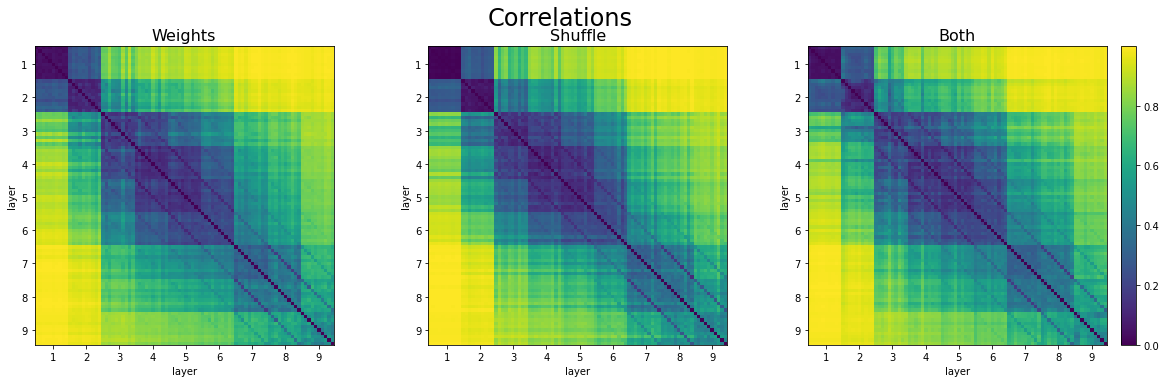

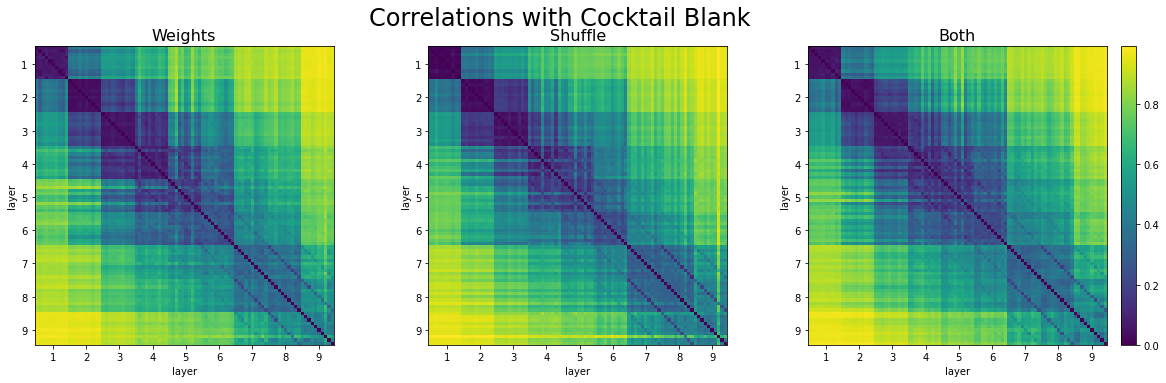

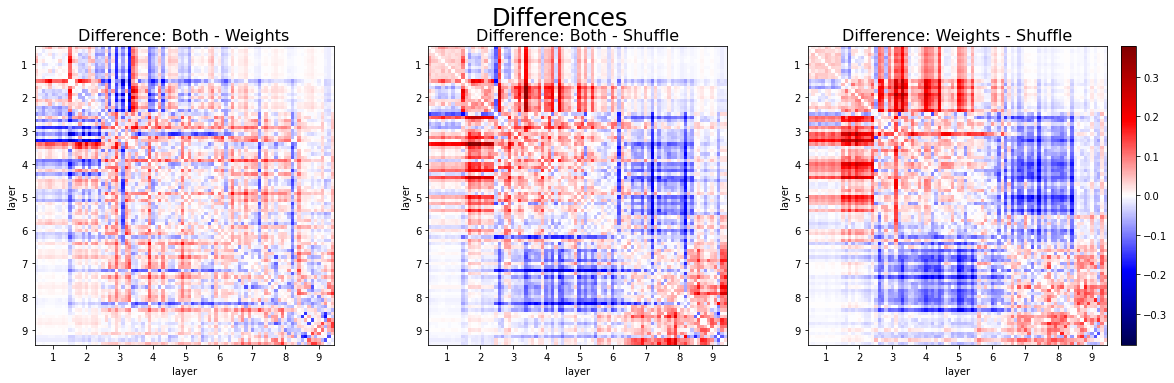

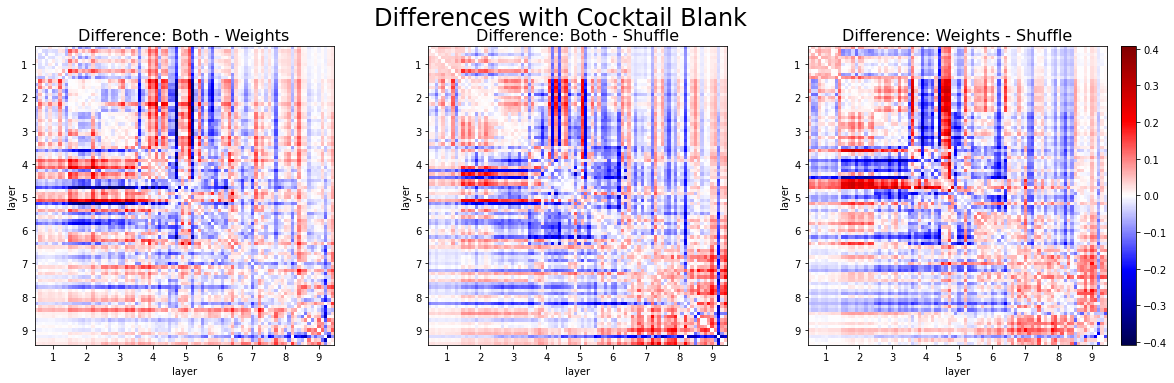

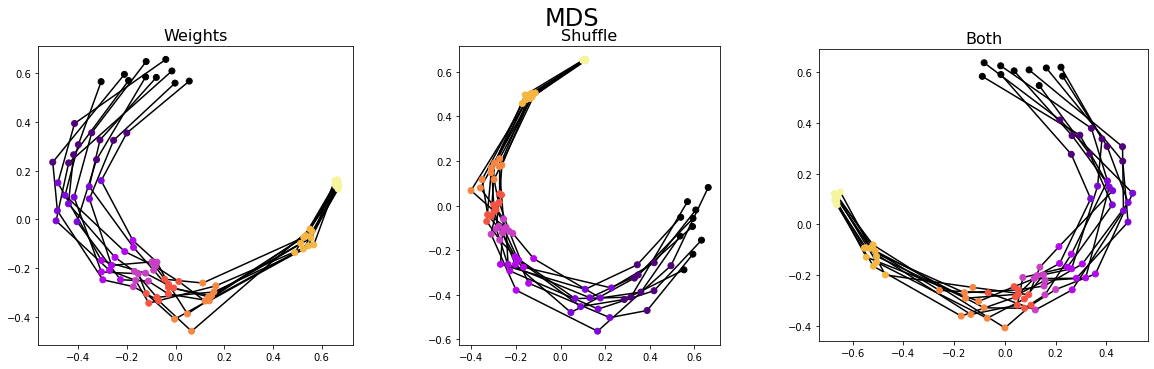

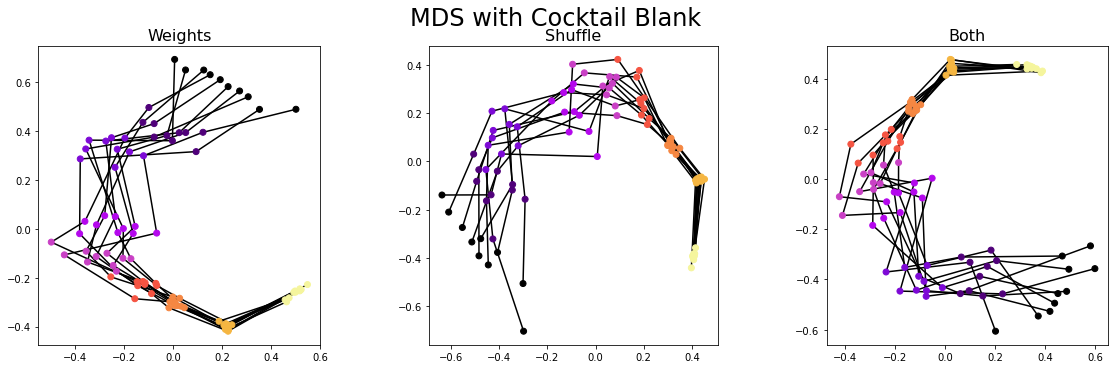

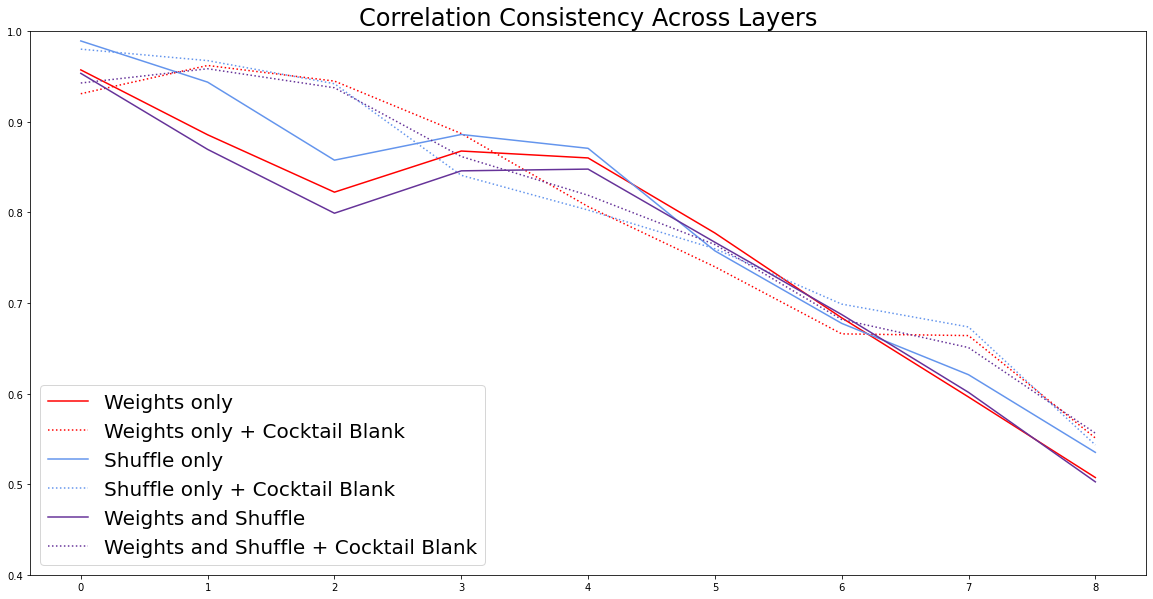

In [199]:
'''
RSA
'''
plot_triple_color(weights=rsa_weights, shuffle=rsa_shuffle, both=rsa_both, title='Correlations')
plot_triple_color(weights=rsa_weights_cb, shuffle=rsa_shuffle_cb, both=rsa_both_cb,
                  title='Correlations with Cocktail Blank')
plot_triple_diff(weights=rsa_weights, shuffle=rsa_shuffle, both=rsa_both, title='Differences')
plot_triple_diff(weights=rsa_weights_cb, shuffle=rsa_shuffle_cb, both=rsa_both_cb,
                 title='Differences with Cocktail Blank')
plot_triple_mds(weights=rsa_weights, shuffle=rsa_shuffle, both=rsa_both, title='MDS')
plot_triple_mds(weights=rsa_weights_cb, shuffle=rsa_shuffle_cb, both=rsa_both_cb,
                title='MDS with Cocktail Blank')
plot_consistency(rsa_weights, rsa_weights_cb,
                 rsa_shuffle, rsa_shuffle_cb,
                 rsa_both, rsa_both_cb)

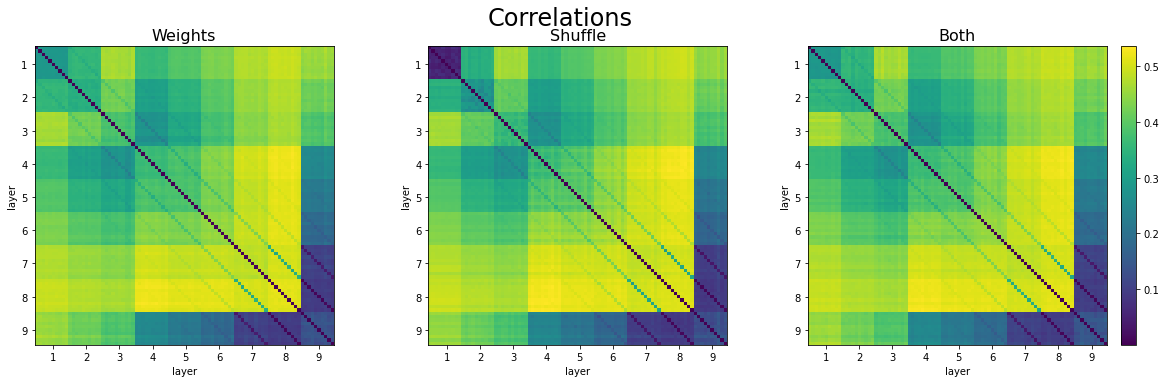

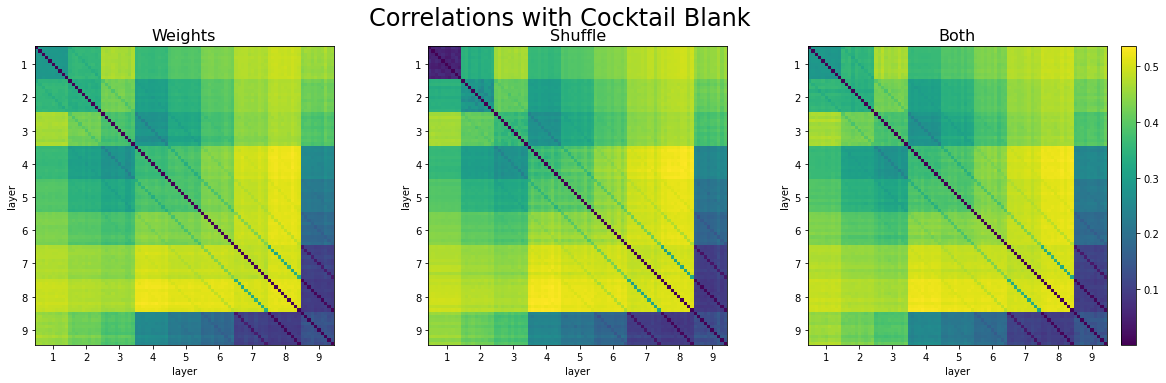

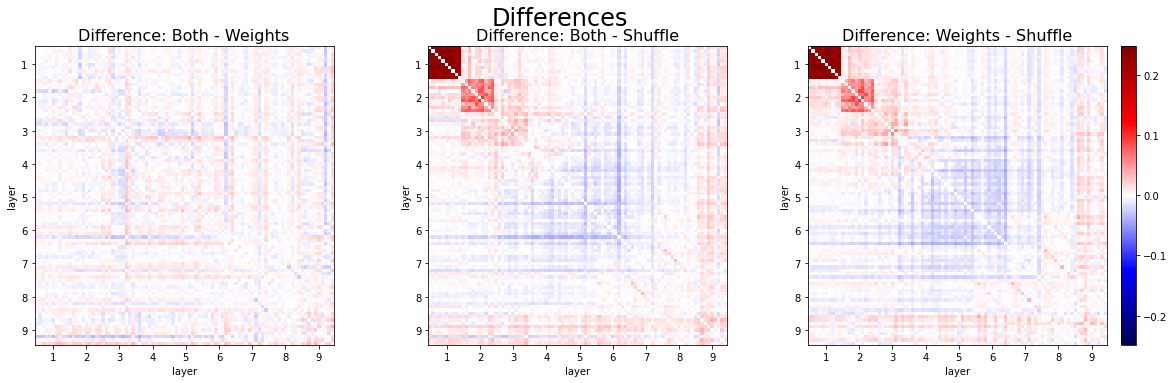

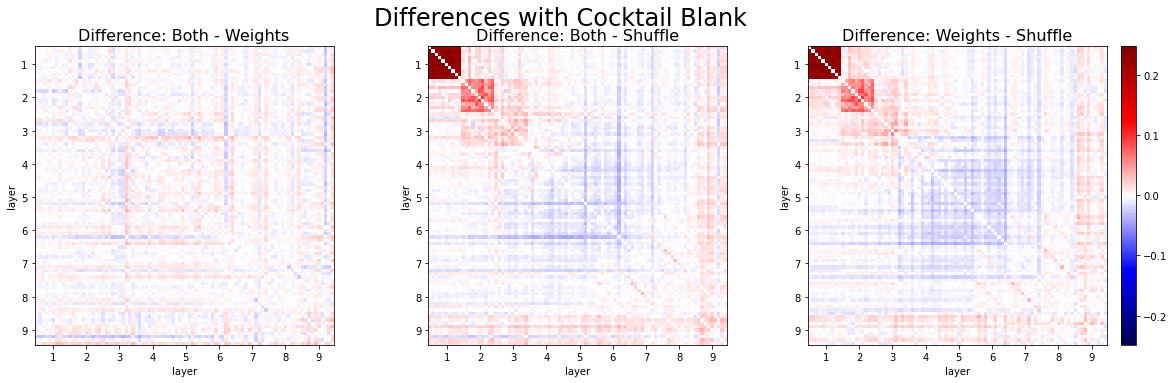

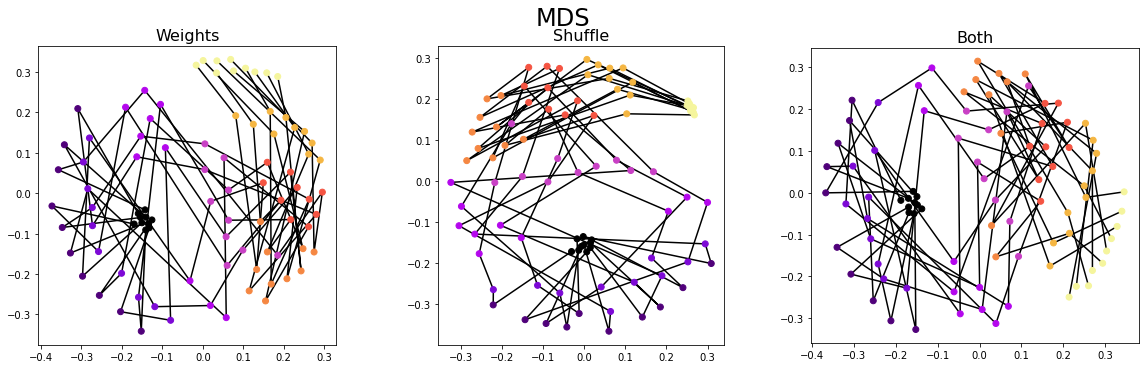

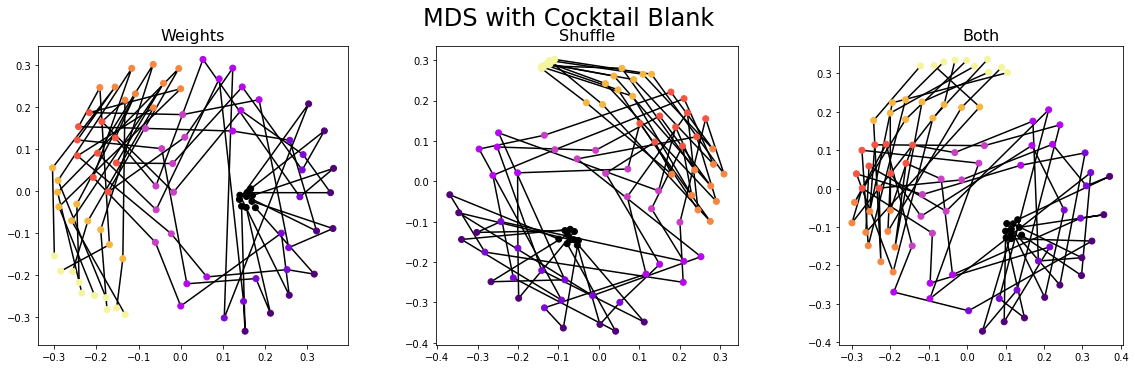

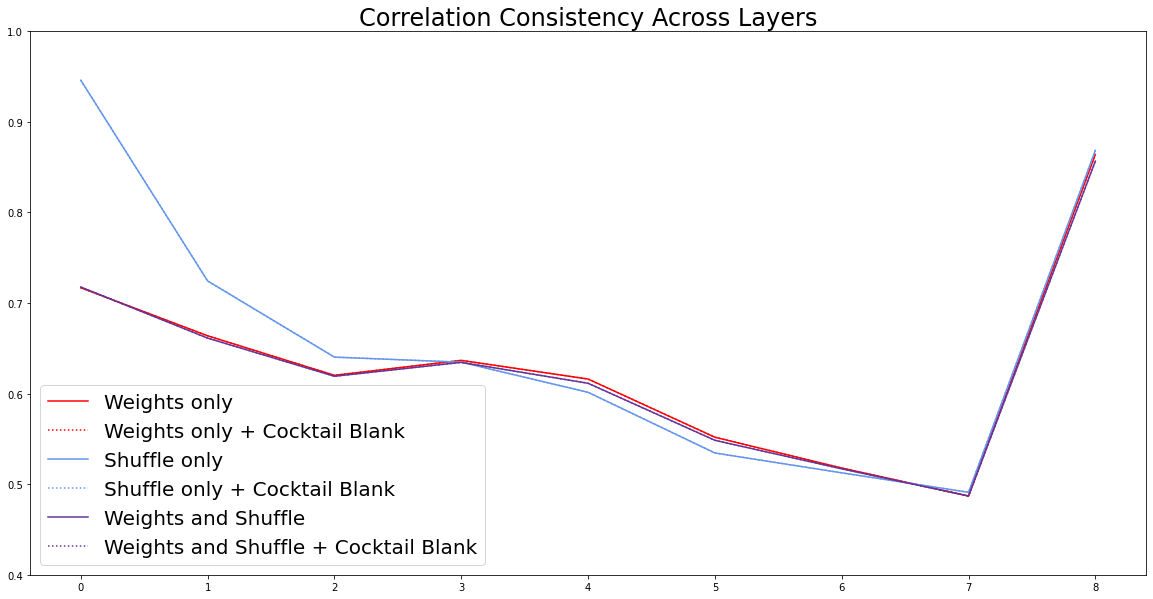

In [200]:
'''
SVCCA
'''
plot_triple_color(weights=svcca_weights, shuffle=svcca_shuffle, both=svcca_both, title='Correlations')
plot_triple_color(weights=svcca_weights_cb, shuffle=svcca_shuffle_cb, both=svcca_both_cb,
                  title='Correlations with Cocktail Blank')
plot_triple_diff(weights=svcca_weights, shuffle=svcca_shuffle, both=svcca_both, title='Differences')
plot_triple_diff(weights=svcca_weights_cb, shuffle=svcca_shuffle_cb, both=svcca_both_cb,
                 title='Differences with Cocktail Blank')
plot_triple_mds(weights=svcca_weights, shuffle=svcca_shuffle, both=svcca_both, title='MDS')
plot_triple_mds(weights=svcca_weights_cb, shuffle=svcca_shuffle_cb, both=svcca_both_cb,
                title='MDS with Cocktail Blank')
plot_consistency(svcca_weights, svcca_weights_cb,
                 svcca_shuffle, svcca_shuffle_cb,
                 svcca_both, svcca_both_cb)

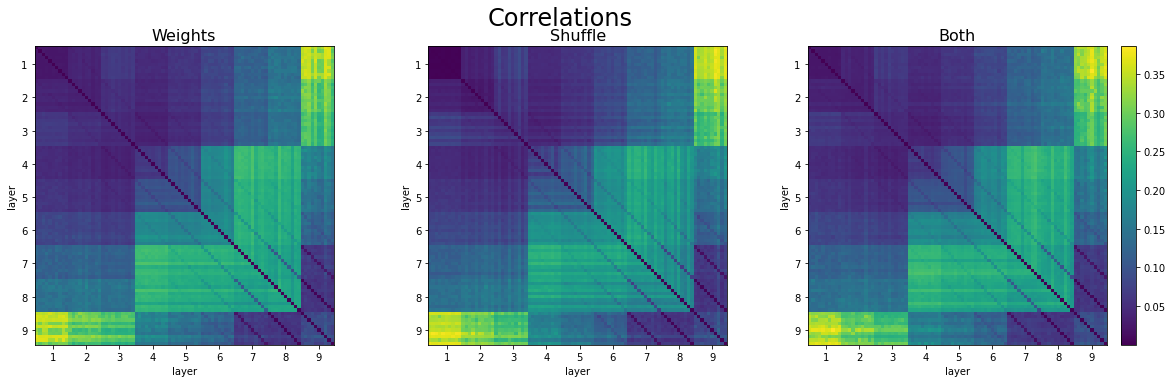

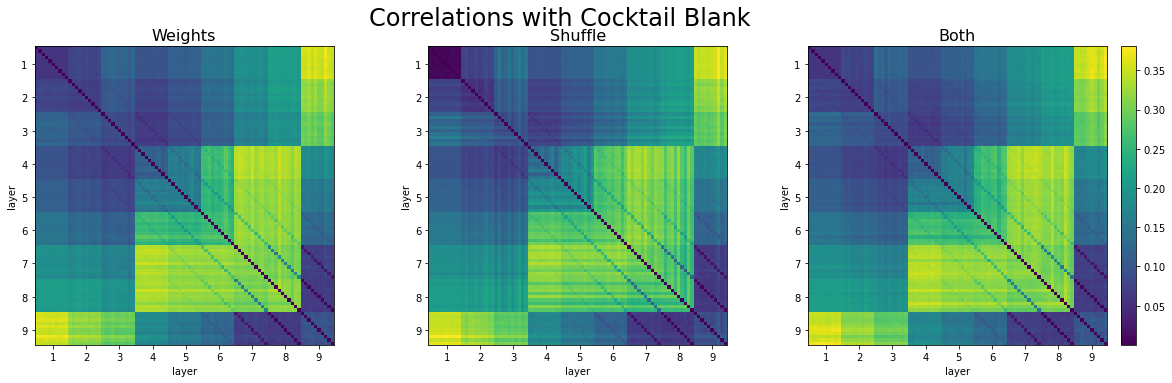

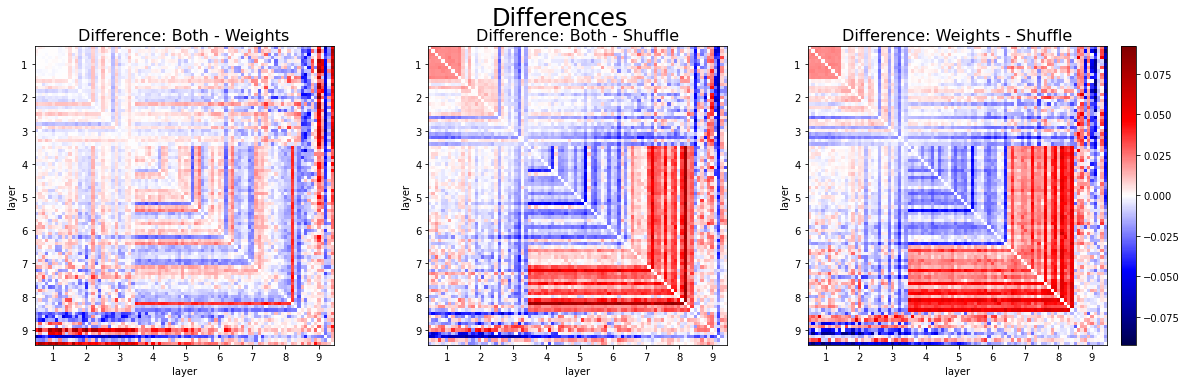

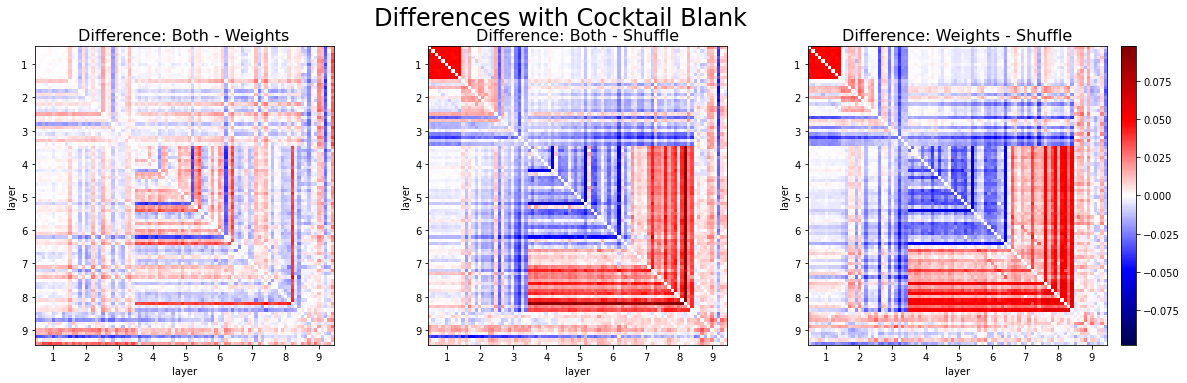

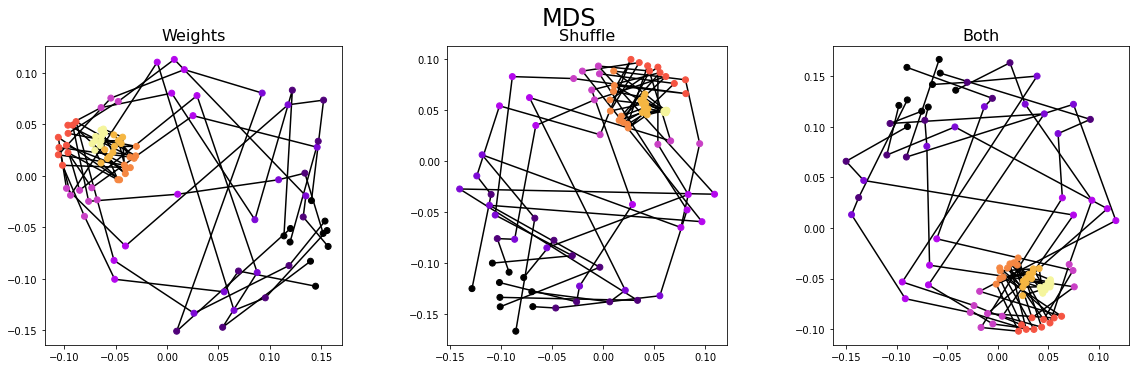

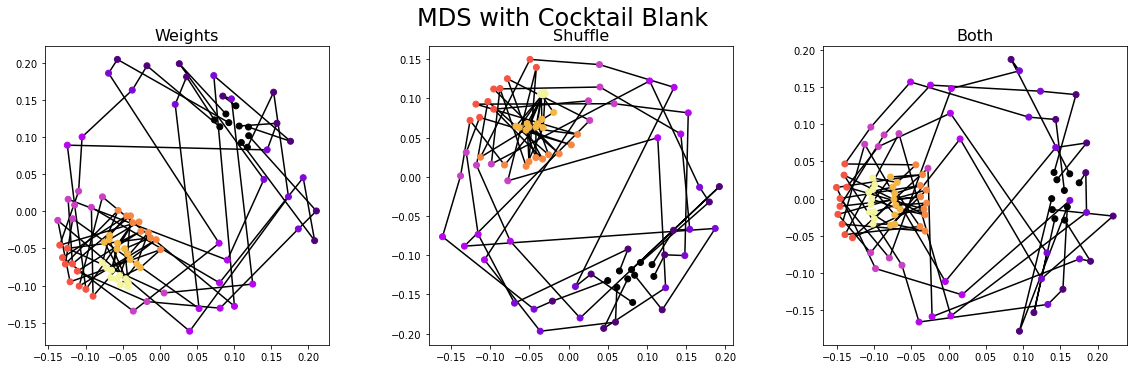

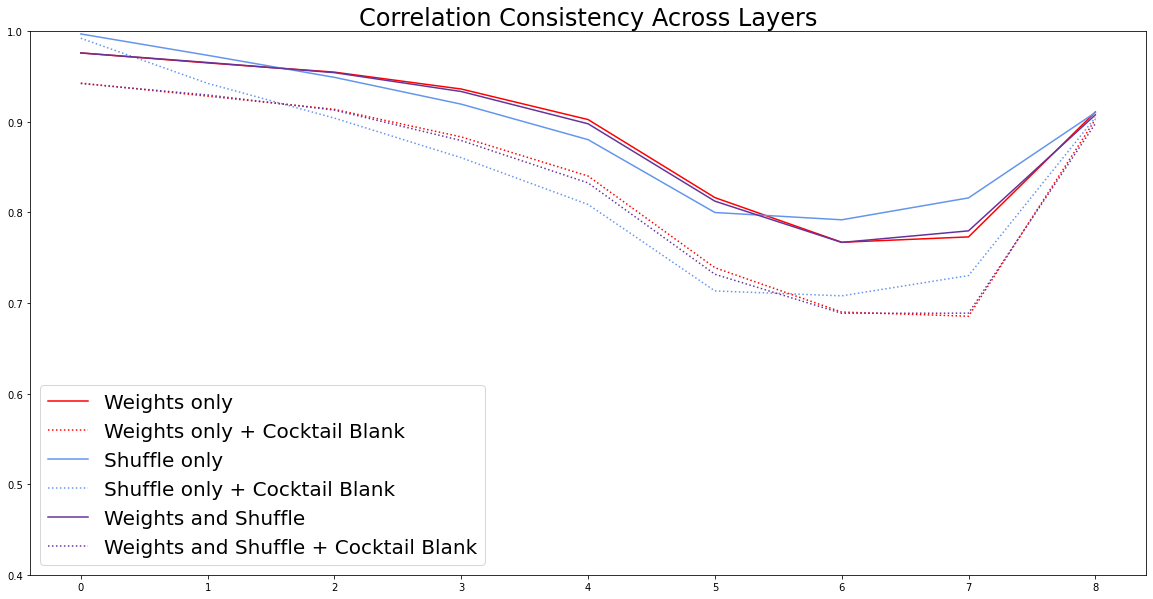

In [201]:
'''
PWCCA
'''
plot_triple_color(weights=pwcca_weights, shuffle=pwcca_shuffle, both=pwcca_both, title='Correlations')
plot_triple_color(weights=pwcca_weights_cb, shuffle=pwcca_shuffle_cb, both=pwcca_both_cb,
                  title='Correlations with Cocktail Blank')
plot_triple_diff(weights=pwcca_weights, shuffle=pwcca_shuffle, both=pwcca_both, title='Differences')
plot_triple_diff(weights=pwcca_weights_cb, shuffle=pwcca_shuffle_cb, both=pwcca_both_cb,
                 title='Differences with Cocktail Blank')
plot_triple_mds(weights=pwcca_weights, shuffle=pwcca_shuffle, both=pwcca_both, title='MDS')
plot_triple_mds(weights=pwcca_weights_cb, shuffle=pwcca_shuffle_cb, both=pwcca_both_cb,
                title='MDS with Cocktail Blank')
plot_consistency(pwcca_weights, pwcca_weights_cb,
                 pwcca_shuffle, pwcca_shuffle_cb,
                 pwcca_both, pwcca_both_cb)

## Key findings thus far
- Overall, shuffle by itself appears to produce the most variance, demonstrated by a blurrier blocking structure in RSA and more striations in PWCCA
- Weights seem to overpower shuffle when varied together, so weights + shuffle ends up looking very similar to weights alone across all 3 correlation techniques
- This overpowering gets to the point where sometimes combining weights and shuffle creates *less* variance
- Outside of striations caused by the different alignment of outliers, these weight+shuffle anomalies seem to concentrate in the pooling layers (layers 3 and 6). See first RSA diff graph and 2nd+3rd PWCCA diff graphs
- Weights seems to create more variance in early layers (especially visible in SVCCA), while shuffle creates more variance in later laters, but weights again takes precedence in the last layer
- Utilizing multiple analysis techniques generates more insights than just one
- Cocktail blank results in less of a distinction between weights and shuffle
- Non-CB RSA rep cons highlights first pooling layer, CB RSA rep cons highlights second
- CB has opposite effect on PWCCA, no effect on SVCCA

## Going Forward
- Train 100 for all 3 so far
- Set up pipeline for cross-category
- Cluster graphs
- Trajectory graphs


In [9]:
'''
TESTING CENTROID STUFF
'''
import importlib
importlib.reload(analysis)
rsa_weights = 1 - analysis.correlate('RSA', '../outputs/models/primary/', x_predict, consistency='centroid')


**** Load and Preprocess Acts ****
*** Working on instance_347.h5 ***
Layer 0
Getting activations...
Layer 1
Getting activations...
Layer 2
Getting activations...
Layer 3
Getting activations...
Layer 4
Getting activations...
Layer 5
Getting activations...
Layer 6
Getting activations...
Layer 7
Getting activations...
Layer 8
Getting activations...
* Preprocessing...
shape: (10, 98304)
num_images = 10
* Preprocessing...
shape: (10, 98304)
num_images = 10
* Preprocessing...
shape: (10, 24576)
num_images = 10
* Preprocessing...
shape: (10, 49152)
num_images = 10
* Preprocessing...
shape: (10, 49152)
num_images = 10
* Preprocessing...
shape: (10, 12288)
num_images = 10
* Preprocessing...
shape: (10, 6912)
num_images = 10
* Preprocessing...
shape: (10, 6912)
num_images = 10
* Preprocessing...
shape: (10, 360)
num_images = 10
*** Working on instance_1237.h5 ***
Layer 0
Getting activations...
Layer 1
Getting activations...
Layer 2
Getting activations...
Layer 3
Getting activations...
Layer 4
G

Correlation 6 , 1
Correlation 6 , 2
Correlation 6 , 3
Correlation 6 , 4
Correlation 6 , 5
Correlation 6 , 6
Correlation 7 , 0
Correlation 7 , 1
Correlation 7 , 2
Correlation 7 , 3
Correlation 7 , 4
Correlation 7 , 5
Correlation 7 , 6
Correlation 7 , 7
Correlation 8 , 0
Correlation 8 , 1
Correlation 8 , 2
Correlation 8 , 3
Correlation 8 , 4
Correlation 8 , 5
Correlation 8 , 6
Correlation 8 , 7
Correlation 8 , 8
Correlation 9 , 0
Correlation 9 , 1
Correlation 9 , 2
Correlation 9 , 3
Correlation 9 , 4
Correlation 9 , 5
Correlation 9 , 6
Correlation 9 , 7
Correlation 9 , 8
Correlation 9 , 9
Correlation 10 , 0
Correlation 10 , 1
Correlation 10 , 2
Correlation 10 , 3
Correlation 10 , 4
Correlation 10 , 5
Correlation 10 , 6
Correlation 10 , 7
Correlation 10 , 8
Correlation 10 , 9
Correlation 10 , 10
Correlation 11 , 0
Correlation 11 , 1
Correlation 11 , 2
Correlation 11 , 3
Correlation 11 , 4
Correlation 11 , 5
Correlation 11 , 6
Correlation 11 , 7
Correlation 11 , 8
Correlation 11 , 9
Correl

Correlation 42 , 18
Correlation 42 , 19
Correlation 42 , 20
Correlation 42 , 21
Correlation 42 , 22
Correlation 42 , 23
Correlation 42 , 24
Correlation 42 , 25
Correlation 42 , 26
Correlation 42 , 27
Correlation 42 , 28
Correlation 42 , 29
Correlation 42 , 30
Correlation 42 , 31
Correlation 42 , 32
Correlation 42 , 33
Correlation 42 , 34
Correlation 42 , 35
Correlation 42 , 36
Correlation 42 , 37
Correlation 42 , 38
Correlation 42 , 39
Correlation 42 , 40
Correlation 42 , 41
Correlation 42 , 42
Correlation 43 , 0
Correlation 43 , 1
Correlation 43 , 2
Correlation 43 , 3
Correlation 43 , 4
Correlation 43 , 5
Correlation 43 , 6
Correlation 43 , 7
Correlation 43 , 8
Correlation 43 , 9
Correlation 43 , 10
Correlation 43 , 11
Correlation 43 , 12
Correlation 43 , 13
Correlation 43 , 14
Correlation 43 , 15
Correlation 43 , 16
Correlation 43 , 17
Correlation 43 , 18
Correlation 43 , 19
Correlation 43 , 20
Correlation 43 , 21
Correlation 43 , 22
Correlation 43 , 23
Correlation 43 , 24
Correlatio

Correlation 53 , 4
Correlation 53 , 5
Correlation 53 , 6
Correlation 53 , 7
Correlation 53 , 8
Correlation 53 , 9
Correlation 53 , 10
Correlation 53 , 11
Correlation 53 , 12
Correlation 53 , 13
Correlation 53 , 14
Correlation 53 , 15
Correlation 53 , 16
Correlation 53 , 17
Correlation 53 , 18
Correlation 53 , 19
Correlation 53 , 20
Correlation 53 , 21
Correlation 53 , 22
Correlation 53 , 23
Correlation 53 , 24
Correlation 53 , 25
Correlation 53 , 26
Correlation 53 , 27
Correlation 53 , 28
Correlation 53 , 29
Correlation 53 , 30
Correlation 53 , 31
Correlation 53 , 32
Correlation 53 , 33
Correlation 53 , 34
Correlation 53 , 35
Correlation 53 , 36
Correlation 53 , 37
Correlation 53 , 38
Correlation 53 , 39
Correlation 53 , 40
Correlation 53 , 41
Correlation 53 , 42
Correlation 53 , 43
Correlation 53 , 44
Correlation 53 , 45
Correlation 53 , 46
Correlation 53 , 47
Correlation 53 , 48
Correlation 53 , 49
Correlation 53 , 50
Correlation 53 , 51
Correlation 53 , 52
Correlation 53 , 53
Correl

Correlation 61 , 13
Correlation 61 , 14
Correlation 61 , 15
Correlation 61 , 16
Correlation 61 , 17
Correlation 61 , 18
Correlation 61 , 19
Correlation 61 , 20
Correlation 61 , 21
Correlation 61 , 22
Correlation 61 , 23
Correlation 61 , 24
Correlation 61 , 25
Correlation 61 , 26
Correlation 61 , 27
Correlation 61 , 28
Correlation 61 , 29
Correlation 61 , 30
Correlation 61 , 31
Correlation 61 , 32
Correlation 61 , 33
Correlation 61 , 34
Correlation 61 , 35
Correlation 61 , 36
Correlation 61 , 37
Correlation 61 , 38
Correlation 61 , 39
Correlation 61 , 40
Correlation 61 , 41
Correlation 61 , 42
Correlation 61 , 43
Correlation 61 , 44
Correlation 61 , 45
Correlation 61 , 46
Correlation 61 , 47
Correlation 61 , 48
Correlation 61 , 49
Correlation 61 , 50
Correlation 61 , 51
Correlation 61 , 52
Correlation 61 , 53
Correlation 61 , 54
Correlation 61 , 55
Correlation 61 , 56
Correlation 61 , 57
Correlation 61 , 58
Correlation 61 , 59
Correlation 61 , 60
Correlation 61 , 61
Correlation 62 , 0
C

Correlation 68 , 49
Correlation 68 , 50
Correlation 68 , 51
Correlation 68 , 52
Correlation 68 , 53
Correlation 68 , 54
Correlation 68 , 55
Correlation 68 , 56
Correlation 68 , 57
Correlation 68 , 58
Correlation 68 , 59
Correlation 68 , 60
Correlation 68 , 61
Correlation 68 , 62
Correlation 68 , 63
Correlation 68 , 64
Correlation 68 , 65
Correlation 68 , 66
Correlation 68 , 67
Correlation 68 , 68
Correlation 69 , 0
Correlation 69 , 1
Correlation 69 , 2
Correlation 69 , 3
Correlation 69 , 4
Correlation 69 , 5
Correlation 69 , 6
Correlation 69 , 7
Correlation 69 , 8
Correlation 69 , 9
Correlation 69 , 10
Correlation 69 , 11
Correlation 69 , 12
Correlation 69 , 13
Correlation 69 , 14
Correlation 69 , 15
Correlation 69 , 16
Correlation 69 , 17
Correlation 69 , 18
Correlation 69 , 19
Correlation 69 , 20
Correlation 69 , 21
Correlation 69 , 22
Correlation 69 , 23
Correlation 69 , 24
Correlation 69 , 25
Correlation 69 , 26
Correlation 69 , 27
Correlation 69 , 28
Correlation 69 , 29
Correlatio

Correlation 76 , 20
Correlation 76 , 21
Correlation 76 , 22
Correlation 76 , 23
Correlation 76 , 24
Correlation 76 , 25
Correlation 76 , 26
Correlation 76 , 27
Correlation 76 , 28
Correlation 76 , 29
Correlation 76 , 30
Correlation 76 , 31
Correlation 76 , 32
Correlation 76 , 33
Correlation 76 , 34
Correlation 76 , 35
Correlation 76 , 36
Correlation 76 , 37
Correlation 76 , 38
Correlation 76 , 39
Correlation 76 , 40
Correlation 76 , 41
Correlation 76 , 42
Correlation 76 , 43
Correlation 76 , 44
Correlation 76 , 45
Correlation 76 , 46
Correlation 76 , 47
Correlation 76 , 48
Correlation 76 , 49
Correlation 76 , 50
Correlation 76 , 51
Correlation 76 , 52
Correlation 76 , 53
Correlation 76 , 54
Correlation 76 , 55
Correlation 76 , 56
Correlation 76 , 57
Correlation 76 , 58
Correlation 76 , 59
Correlation 76 , 60
Correlation 76 , 61
Correlation 76 , 62
Correlation 76 , 63
Correlation 76 , 64
Correlation 76 , 65
Correlation 76 , 66
Correlation 76 , 67
Correlation 76 , 68
Correlation 76 , 69


Correlation 82 , 75
Correlation 82 , 76
Correlation 82 , 77
Correlation 82 , 78
Correlation 82 , 79
Correlation 82 , 80
Correlation 82 , 81
Correlation 82 , 82
Correlation 83 , 0
Correlation 83 , 1
Correlation 83 , 2
Correlation 83 , 3
Correlation 83 , 4
Correlation 83 , 5
Correlation 83 , 6
Correlation 83 , 7
Correlation 83 , 8
Correlation 83 , 9
Correlation 83 , 10
Correlation 83 , 11
Correlation 83 , 12
Correlation 83 , 13
Correlation 83 , 14
Correlation 83 , 15
Correlation 83 , 16
Correlation 83 , 17
Correlation 83 , 18
Correlation 83 , 19
Correlation 83 , 20
Correlation 83 , 21
Correlation 83 , 22
Correlation 83 , 23
Correlation 83 , 24
Correlation 83 , 25
Correlation 83 , 26
Correlation 83 , 27
Correlation 83 , 28
Correlation 83 , 29
Correlation 83 , 30
Correlation 83 , 31
Correlation 83 , 32
Correlation 83 , 33
Correlation 83 , 34
Correlation 83 , 35
Correlation 83 , 36
Correlation 83 , 37
Correlation 83 , 38
Correlation 83 , 39
Correlation 83 , 40
Correlation 83 , 41
Correlatio

Correlation 88 , 77
Correlation 88 , 78
Correlation 88 , 79
Correlation 88 , 80
Correlation 88 , 81
Correlation 88 , 82
Correlation 88 , 83
Correlation 88 , 84
Correlation 88 , 85
Correlation 88 , 86
Correlation 88 , 87
Correlation 88 , 88
Correlation 89 , 0
Correlation 89 , 1
Correlation 89 , 2
Correlation 89 , 3
Correlation 89 , 4
Correlation 89 , 5
Correlation 89 , 6
Correlation 89 , 7
Correlation 89 , 8
Correlation 89 , 9
Correlation 89 , 10
Correlation 89 , 11
Correlation 89 , 12
Correlation 89 , 13
Correlation 89 , 14
Correlation 89 , 15
Correlation 89 , 16
Correlation 89 , 17
Correlation 89 , 18
Correlation 89 , 19
Correlation 89 , 20
Correlation 89 , 21
Correlation 89 , 22
Correlation 89 , 23
Correlation 89 , 24
Correlation 89 , 25
Correlation 89 , 26
Correlation 89 , 27
Correlation 89 , 28
Correlation 89 , 29
Correlation 89 , 30
Correlation 89 , 31
Correlation 89 , 32
Correlation 89 , 33
Correlation 89 , 34
Correlation 89 , 35
Correlation 89 , 36
Correlation 89 , 37
Correlatio

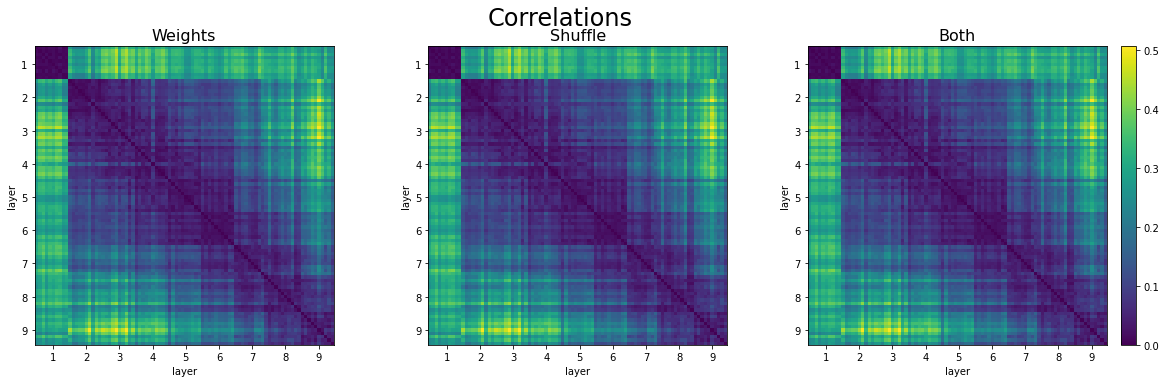

In [12]:
plot_triple_color(weights=rsa_weights, shuffle=rsa_weights, both=rsa_weights, title='Correlations')

In [20]:
import importlib
importlib.reload(analysis)
rsa_weights_traj_ten = analysis.correlate_trajectory('first_ten', 'RSA', '../outputs/models/primary/', 
                                                'weights', x_predict, 'centroid', False)

* Preprocessing...
shape: (10, 6912)
num_images = 10
* Preprocessing...
shape: (10, 6912)
num_images = 10
* Preprocessing...
shape: (10, 6912)
num_images = 10
* Preprocessing...
shape: (10, 6912)
num_images = 10
* Preprocessing...
shape: (10, 6912)
num_images = 10
* Preprocessing...
shape: (10, 6912)
num_images = 10
* Preprocessing...
shape: (10, 6912)
num_images = 10
* Preprocessing...
shape: (10, 6912)
num_images = 10
* Preprocessing...
shape: (10, 6912)
num_images = 10
* Preprocessing...
shape: (10, 6912)
num_images = 10
* Preprocessing...
shape: (10, 6912)
num_images = 10
* Preprocessing...
shape: (10, 6912)
num_images = 10
* Preprocessing...
shape: (10, 6912)
num_images = 10
* Preprocessing...
shape: (10, 6912)
num_images = 10
* Preprocessing...
shape: (10, 6912)
num_images = 10
* Preprocessing...
shape: (10, 6912)
num_images = 10
* Preprocessing...
shape: (10, 6912)
num_images = 10
* Preprocessing...
shape: (10, 6912)
num_images = 10
* Preprocessing...
shape: (10, 6912)
num_image

Correlation 14 , 3
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 14 , 4
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 14 , 5
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 14 , 6
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 14 , 7
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 14 , 8
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 14 , 9
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 14 , 10
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 14 , 11
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 14 , 12
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 14 , 13
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 14 , 14
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 15 , 0
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 15 , 1
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 15 , 2
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 15 , 3
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 15 , 4
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 15 , 5
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 15 , 6
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 15 , 7
Acts1: 

Correlation 29 , 4
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 29 , 5
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 29 , 6
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 29 , 7
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 29 , 8
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 29 , 9
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 29 , 10
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 29 , 11
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 29 , 12
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 29 , 13
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 29 , 14
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 29 , 15
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 29 , 16
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 29 , 17
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 29 , 18
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 29 , 19
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 29 , 20
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 29 , 21
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 29 , 22
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 29 , 2

Correlation 39 , 3
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 39 , 4
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 39 , 5
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 39 , 6
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 39 , 7
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 39 , 8
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 39 , 9
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 39 , 10
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 39 , 11
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 39 , 12
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 39 , 13
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 39 , 14
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 39 , 15
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 39 , 16
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 39 , 17
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 39 , 18
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 39 , 19
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 39 , 20
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 39 , 21
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 39 , 22

Correlation 46 , 45
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 46 , 46
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 47 , 0
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 47 , 1
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 47 , 2
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 47 , 3
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 47 , 4
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 47 , 5
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 47 , 6
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 47 , 7
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 47 , 8
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 47 , 9
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 47 , 10
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 47 , 11
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 47 , 12
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 47 , 13
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 47 , 14
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 47 , 15
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 47 , 16
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 47 , 17
Ac

Correlation 53 , 41
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 53 , 42
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 53 , 43
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 53 , 44
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 53 , 45
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 53 , 46
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 53 , 47
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 53 , 48
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 53 , 49
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 53 , 50
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 53 , 51
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 53 , 52
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 53 , 53
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 54 , 0
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 54 , 1
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 54 , 2
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 54 , 3
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 54 , 4
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 54 , 5
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 54 , 6

Correlation 59 , 27
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 59 , 28
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 59 , 29
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 59 , 30
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 59 , 31
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 59 , 32
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 59 , 33
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 59 , 34
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 59 , 35
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 59 , 36
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 59 , 37
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 59 , 38
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 59 , 39
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 59 , 40
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 59 , 41
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 59 , 42
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 59 , 43
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 59 , 44
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 59 , 45
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 

Correlation 65 , 2
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 65 , 3
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 65 , 4
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 65 , 5
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 65 , 6
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 65 , 7
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 65 , 8
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 65 , 9
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 65 , 10
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 65 , 11
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 65 , 12
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 65 , 13
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 65 , 14
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 65 , 15
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 65 , 16
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 65 , 17
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 65 , 18
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 65 , 19
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 65 , 20
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 65 , 21


Correlation 70 , 6
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 70 , 7
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 70 , 8
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 70 , 9
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 70 , 10
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 70 , 11
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 70 , 12
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 70 , 13
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 70 , 14
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 70 , 15
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 70 , 16
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 70 , 17
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 70 , 18
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 70 , 19
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 70 , 20
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 70 , 21
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 70 , 22
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 70 , 23
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 70 , 24
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 70 ,

Correlation 74 , 59
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 74 , 60
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 74 , 61
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 74 , 62
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 74 , 63
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 74 , 64
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 74 , 65
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 74 , 66
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 74 , 67
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 74 , 68
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 74 , 69
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 74 , 70
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 74 , 71
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 74 , 72
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 74 , 73
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 74 , 74
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 75 , 0
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 75 , 1
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 75 , 2
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 75 

Correlation 79 , 8
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 79 , 9
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 79 , 10
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 79 , 11
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 79 , 12
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 79 , 13
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 79 , 14
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 79 , 15
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 79 , 16
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 79 , 17
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 79 , 18
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 79 , 19
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 79 , 20
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 79 , 21
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 79 , 22
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 79 , 23
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 79 , 24
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 79 , 25
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 79 , 26
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 79

Correlation 83 , 29
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 83 , 30
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 83 , 31
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 83 , 32
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 83 , 33
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 83 , 34
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 83 , 35
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 83 , 36
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 83 , 37
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 83 , 38
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 83 , 39
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 83 , 40
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 83 , 41
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 83 , 42
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 83 , 43
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 83 , 44
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 83 , 45
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 83 , 46
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 83 , 47
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 

Correlation 87 , 20
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 87 , 21
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 87 , 22
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 87 , 23
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 87 , 24
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 87 , 25
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 87 , 26
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 87 , 27
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 87 , 28
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 87 , 29
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 87 , 30
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 87 , 31
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 87 , 32
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 87 , 33
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 87 , 34
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 87 , 35
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 87 , 36
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 87 , 37
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 87 , 38
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 

Correlation 90 , 86
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 90 , 87
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 90 , 88
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 90 , 89
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 90 , 90
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 91 , 0
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 91 , 1
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 91 , 2
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 91 , 3
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 91 , 4
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 91 , 5
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 91 , 6
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 91 , 7
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 91 , 8
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 91 , 9
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 91 , 10
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 91 , 11
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 91 , 12
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 91 , 13
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 91 , 14
Ac

Correlation 94 , 40
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 94 , 41
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 94 , 42
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 94 , 43
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 94 , 44
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 94 , 45
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 94 , 46
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 94 , 47
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 94 , 48
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 94 , 49
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 94 , 50
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 94 , 51
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 94 , 52
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 94 , 53
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 94 , 54
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 94 , 55
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 94 , 56
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 94 , 57
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 94 , 58
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 

Correlation 97 , 92
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 97 , 93
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 97 , 94
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 97 , 95
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 97 , 96
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 97 , 97
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 98 , 0
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 98 , 1
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 98 , 2
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 98 , 3
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 98 , 4
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 98 , 5
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 98 , 6
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 98 , 7
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 98 , 8
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 98 , 9
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 98 , 10
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 98 , 11
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 98 , 12
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 98 , 13
Ac

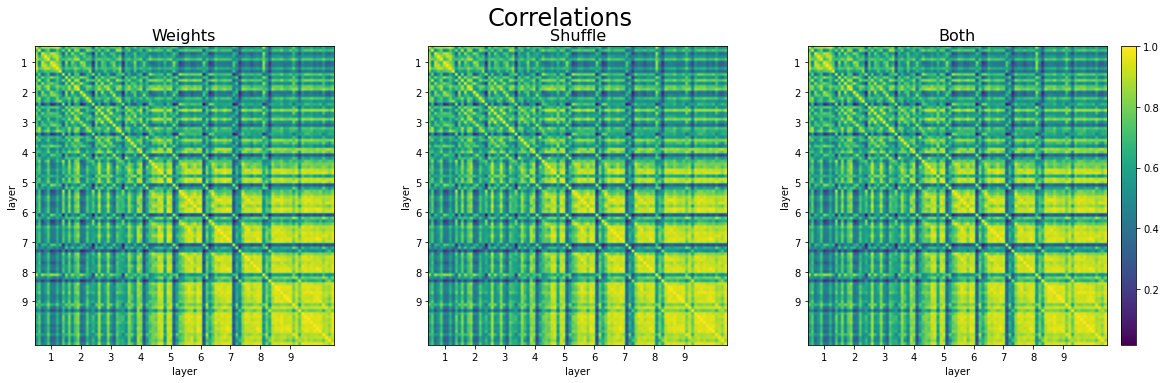

In [21]:
plot_triple_color(weights=rsa_weights_traj_ten, shuffle=rsa_weights_traj_ten, both=rsa_weights_traj_ten, title='Correlations')

In [22]:
rsa_weights_traj_fifties = analysis.correlate_trajectory('fifties', 'RSA', '../outputs/models/primary/', 
                                                'weights', x_predict, 'centroid', False)

* Preprocessing...
shape: (10, 6912)
num_images = 10
* Preprocessing...
shape: (10, 6912)
num_images = 10
* Preprocessing...
shape: (10, 6912)
num_images = 10
* Preprocessing...
shape: (10, 6912)
num_images = 10
* Preprocessing...
shape: (10, 6912)
num_images = 10
* Preprocessing...
shape: (10, 6912)
num_images = 10
* Preprocessing...
shape: (10, 6912)
num_images = 10
* Preprocessing...
shape: (10, 6912)
num_images = 10
* Preprocessing...
shape: (10, 6912)
num_images = 10
* Preprocessing...
shape: (10, 6912)
num_images = 10
* Preprocessing...
shape: (10, 6912)
num_images = 10
* Preprocessing...
shape: (10, 6912)
num_images = 10
* Preprocessing...
shape: (10, 6912)
num_images = 10
* Preprocessing...
shape: (10, 6912)
num_images = 10
* Preprocessing...
shape: (10, 6912)
num_images = 10
* Preprocessing...
shape: (10, 6912)
num_images = 10
* Preprocessing...
shape: (10, 6912)
num_images = 10
* Preprocessing...
shape: (10, 6912)
num_images = 10
* Preprocessing...
shape: (10, 6912)
num_image

Correlation 23 , 10
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 23 , 11
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 23 , 12
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 23 , 13
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 23 , 14
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 23 , 15
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 23 , 16
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 23 , 17
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 23 , 18
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 23 , 19
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 23 , 20
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 23 , 21
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 23 , 22
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 23 , 23
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 24 , 0
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 24 , 1
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 24 , 2
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 24 , 3
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 24 , 4
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 24 , 

Acts1: (10, 10)
Acts2: (10, 10)
Correlation 34 , 8
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 34 , 9
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 34 , 10
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 34 , 11
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 34 , 12
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 34 , 13
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 34 , 14
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 34 , 15
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 34 , 16
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 34 , 17
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 34 , 18
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 34 , 19
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 34 , 20
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 34 , 21
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 34 , 22
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 34 , 23
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 34 , 24
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 34 , 25
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 34 , 26
Acts1: (10, 10

Acts1: (10, 10)
Acts2: (10, 10)
Correlation 42 , 13
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 42 , 14
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 42 , 15
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 42 , 16
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 42 , 17
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 42 , 18
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 42 , 19
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 42 , 20
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 42 , 21
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 42 , 22
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 42 , 23
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 42 , 24
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 42 , 25
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 42 , 26
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 42 , 27
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 42 , 28
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 42 , 29
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 42 , 30
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 42 , 31
Acts1: (10, 

Correlation 49 , 4
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 49 , 5
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 49 , 6
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 49 , 7
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 49 , 8
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 49 , 9
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 49 , 10
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 49 , 11
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 49 , 12
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 49 , 13
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 49 , 14
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 49 , 15
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 49 , 16
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 49 , 17
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 49 , 18
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 49 , 19
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 49 , 20
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 49 , 21
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 49 , 22
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 49 , 2

Correlation 55 , 9
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 55 , 10
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 55 , 11
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 55 , 12
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 55 , 13
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 55 , 14
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 55 , 15
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 55 , 16
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 55 , 17
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 55 , 18
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 55 , 19
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 55 , 20
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 55 , 21
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 55 , 22
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 55 , 23
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 55 , 24
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 55 , 25
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 55 , 26
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 55 , 27
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 5

Correlation 60 , 40
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 60 , 41
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 60 , 42
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 60 , 43
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 60 , 44
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 60 , 45
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 60 , 46
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 60 , 47
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 60 , 48
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 60 , 49
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 60 , 50
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 60 , 51
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 60 , 52
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 60 , 53
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 60 , 54
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 60 , 55
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 60 , 56
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 60 , 57
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 60 , 58
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 

Correlation 65 , 43
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 65 , 44
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 65 , 45
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 65 , 46
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 65 , 47
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 65 , 48
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 65 , 49
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 65 , 50
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 65 , 51
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 65 , 52
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 65 , 53
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 65 , 54
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 65 , 55
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 65 , 56
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 65 , 57
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 65 , 58
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 65 , 59
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 65 , 60
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 65 , 61
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 

Correlation 70 , 26
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 70 , 27
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 70 , 28
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 70 , 29
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 70 , 30
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 70 , 31
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 70 , 32
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 70 , 33
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 70 , 34
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 70 , 35
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 70 , 36
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 70 , 37
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 70 , 38
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 70 , 39
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 70 , 40
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 70 , 41
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 70 , 42
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 70 , 43
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 70 , 44
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 

Correlation 74 , 54
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 74 , 55
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 74 , 56
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 74 , 57
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 74 , 58
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 74 , 59
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 74 , 60
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 74 , 61
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 74 , 62
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 74 , 63
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 74 , 64
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 74 , 65
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 74 , 66
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 74 , 67
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 74 , 68
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 74 , 69
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 74 , 70
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 74 , 71
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 74 , 72
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 

Correlation 78 , 64
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 78 , 65
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 78 , 66
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 78 , 67
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 78 , 68
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 78 , 69
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 78 , 70
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 78 , 71
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 78 , 72
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 78 , 73
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 78 , 74
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 78 , 75
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 78 , 76
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 78 , 77
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 78 , 78
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 79 , 0
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 79 , 1
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 79 , 2
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 79 , 3
Acts1: (10, 10)
Acts2: (10, 10)
Correlation 79 ,

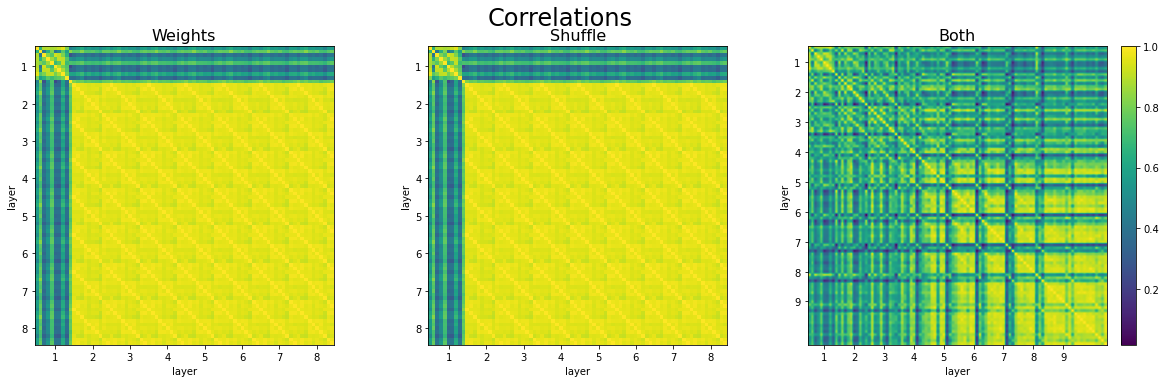

In [24]:
plot_triple_color(weights=rsa_weights_traj_fifties, shuffle=rsa_weights_traj_fifties, both=rsa_weights_traj_ten, title='Correlations')

In [14]:
'''
Calculate RSA Trajectory
'''
import importlib
importlib.reload(analysis)

# rsa_shuffle_traj_fifties = analysis.correlate_trajectory('fifties', 'RSA', '../outputs/models/shuffle_seed/', 
#                                                 'shuffle', x_predict, False)
# np.save('rsa_shuffle_traj_fifties', rsa_shuffle_traj_fifties)

# rsa_shuffle_traj_ten = analysis.correlate_trajectory('first_ten', 'RSA', '../outputs/models/shuffle_seed/', 
#                                                 'shuffle', x_predict, False)
# np.save('rsa_shuffle_traj_ten', rsa_shuffle_traj_ten)

rsa_both_traj_fifties = analysis.correlate_trajectory('fifties', 'RSA', '../outputs/models/both/', 
                                                'both', x_predict, False)
np.save('rsa_both_traj_fifties', rsa_both_traj_fifties)

rsa_both_traj_ten = analysis.correlate_trajectory('first_ten', 'RSA', '../outputs/models/both/', 
                                                'both', x_predict, False)
np.save('rsa_both_traj_ten', rsa_both_traj_ten)

rsa_weights_traj_fifties = analysis.correlate_trajectory('fifties', 'RSA', '../outputs/models/primary/', 
                                                'weights', x_predict, False)
np.save('rsa_weights_traj_fifties.npy', rsa_weights_traj_fifties)

rsa_weights_traj_ten = analysis.correlate_trajectory('first_ten', 'RSA', '../outputs/models/primary/', 
                                                'weights', x_predict, False)
np.save('rsa_weights_traj_ten.npy', rsa_weights_traj_ten)


* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000

Correlation 10 , 8
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 10 , 9
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 10 , 10
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 11 , 0
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 11 , 1
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 11 , 2
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 11 , 3
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 11 , 4
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 11 , 5
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 11 , 6
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 11 , 7
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 11 , 8
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 11 , 9
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 11 , 10
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 11 , 11
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 12 , 0
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 12 , 1
Acts1: (1000, 1000)
Acts2: (1000, 

Correlation 19 , 12
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 19 , 13
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 19 , 14
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 19 , 15
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 19 , 16
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 19 , 17
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 19 , 18
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 19 , 19
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 20 , 0
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 20 , 1
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 20 , 2
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 20 , 3
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 20 , 4
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 20 , 5
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 20 , 6
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 20 , 7
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 20 , 8
Acts1: (1000, 1000)
Acts2: (1

Correlation 25 , 17
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 25 , 18
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 25 , 19
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 25 , 20
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 25 , 21
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 25 , 22
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 25 , 23
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 25 , 24
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 25 , 25
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 26 , 0
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 26 , 1
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 26 , 2
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 26 , 3
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 26 , 4
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 26 , 5
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 26 , 6
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 26 , 7
Acts1: (1000, 1000)
Acts2: (

Correlation 30 , 17
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 30 , 18
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 30 , 19
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 30 , 20
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 30 , 21
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 30 , 22
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 30 , 23
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 30 , 24
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 30 , 25
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 30 , 26
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 30 , 27
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 30 , 28
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 30 , 29
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 30 , 30
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 31 , 0
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 31 , 1
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 31 , 2
Acts1: (1000, 1000)
Act

Correlation 34 , 29
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 34 , 30
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 34 , 31
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 34 , 32
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 34 , 33
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 34 , 34
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 35 , 0
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 35 , 1
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 35 , 2
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 35 , 3
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 35 , 4
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 35 , 5
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 35 , 6
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 35 , 7
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 35 , 8
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 35 , 9
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 35 , 10
Acts1: (1000, 1000)
Acts2: (10

Correlation 38 , 24
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 38 , 25
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 38 , 26
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 38 , 27
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 38 , 28
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 38 , 29
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 38 , 30
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 38 , 31
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 38 , 32
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 38 , 33
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 38 , 34
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 38 , 35
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 38 , 36
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 38 , 37
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 38 , 38
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 39 , 0
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 39 , 1
Acts1: (1000, 1000)
Ac

Correlation 42 , 3
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 42 , 4
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 42 , 5
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 42 , 6
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 42 , 7
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 42 , 8
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 42 , 9
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 42 , 10
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 42 , 11
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 42 , 12
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 42 , 13
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 42 , 14
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 42 , 15
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 42 , 16
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 42 , 17
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 42 , 18
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 42 , 19
Acts1: (1000, 1000)
Acts2: 

Correlation 45 , 10
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 45 , 11
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 45 , 12
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 45 , 13
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 45 , 14
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 45 , 15
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 45 , 16
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 45 , 17
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 45 , 18
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 45 , 19
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 45 , 20
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 45 , 21
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 45 , 22
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 45 , 23
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 45 , 24
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 45 , 25
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 45 , 26
Acts1: (1000, 1000)


Correlation 48 , 7
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 8
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 9
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 10
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 11
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 12
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 13
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 14
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 15
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 16
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 17
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 18
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 19
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 20
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 21
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 22
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 23
Acts1: (1000, 1000)
Act

Correlation 50 , 49
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 50 , 50
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 0
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 1
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 2
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 3
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 4
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 5
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 6
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 7
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 8
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 9
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 10
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 11
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 12
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 13
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 14
Acts1: (1000, 1000)
Acts2: (10

Correlation 53 , 34
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 53 , 35
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 53 , 36
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 53 , 37
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 53 , 38
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 53 , 39
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 53 , 40
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 53 , 41
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 53 , 42
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 53 , 43
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 53 , 44
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 53 , 45
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 53 , 46
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 53 , 47
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 53 , 48
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 53 , 49
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 53 , 50
Acts1: (1000, 1000)


Correlation 56 , 8
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 9
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 10
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 11
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 12
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 13
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 14
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 15
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 16
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 17
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 18
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 19
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 20
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 21
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 22
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 23
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 24
Acts1: (1000, 1000)
Ac

Correlation 58 , 30
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 58 , 31
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 58 , 32
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 58 , 33
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 58 , 34
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 58 , 35
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 58 , 36
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 58 , 37
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 58 , 38
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 58 , 39
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 58 , 40
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 58 , 41
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 58 , 42
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 58 , 43
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 58 , 44
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 58 , 45
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 58 , 46
Acts1: (1000, 1000)


Correlation 60 , 49
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 60 , 50
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 60 , 51
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 60 , 52
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 60 , 53
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 60 , 54
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 60 , 55
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 60 , 56
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 60 , 57
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 60 , 58
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 60 , 59
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 60 , 60
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 61 , 0
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 61 , 1
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 61 , 2
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 61 , 3
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 61 , 4
Acts1: (1000, 1000)
Acts2

Correlation 63 , 2
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 3
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 4
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 5
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 6
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 7
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 8
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 9
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 10
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 11
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 12
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 13
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 14
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 15
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 16
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 17
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 18
Acts1: (1000, 1000)
Acts2: (

Correlation 65 , 12
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 13
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 14
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 15
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 16
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 17
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 18
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 19
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 20
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 21
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 22
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 23
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 24
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 25
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 26
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 27
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 28
Acts1: (1000, 1000)


Correlation 67 , 20
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 21
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 22
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 23
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 24
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 25
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 26
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 27
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 28
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 29
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 30
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 31
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 32
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 33
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 34
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 35
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 36
Acts1: (1000, 1000)


Correlation 69 , 21
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 22
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 23
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 24
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 25
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 26
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 27
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 28
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 29
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 30
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 31
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 32
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 33
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 34
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 35
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 36
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 37
Acts1: (1000, 1000)


Correlation 71 , 19
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 20
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 21
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 22
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 23
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 24
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 25
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 26
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 27
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 28
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 29
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 30
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 31
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 32
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 33
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 34
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 35
Acts1: (1000, 1000)


Correlation 73 , 13
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 14
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 15
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 16
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 17
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 18
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 19
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 20
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 21
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 22
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 23
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 24
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 25
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 26
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 27
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 28
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 29
Acts1: (1000, 1000)


Correlation 75 , 2
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 3
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 4
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 5
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 6
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 7
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 8
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 9
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 10
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 11
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 12
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 13
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 14
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 15
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 16
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 17
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 18
Acts1: (1000, 1000)
Acts2: (

Correlation 76 , 66
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 76 , 67
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 76 , 68
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 76 , 69
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 76 , 70
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 76 , 71
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 76 , 72
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 76 , 73
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 76 , 74
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 76 , 75
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 76 , 76
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 77 , 0
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 77 , 1
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 77 , 2
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 77 , 3
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 77 , 4
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 77 , 5
Acts1: (1000, 1000)
Acts2:

Correlation 78 , 52
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 78 , 53
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 78 , 54
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 78 , 55
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 78 , 56
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 78 , 57
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 78 , 58
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 78 , 59
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 78 , 60
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 78 , 61
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 78 , 62
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 78 , 63
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 78 , 64
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 78 , 65
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 78 , 66
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 78 , 67
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 78 , 68
Acts1: (1000, 1000)


* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000

Correlation 11 , 8
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 11 , 9
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 11 , 10
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 11 , 11
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 12 , 0
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 12 , 1
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 12 , 2
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 12 , 3
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 12 , 4
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 12 , 5
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 12 , 6
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 12 , 7
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 12 , 8
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 12 , 9
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 12 , 10
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 12 , 11
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 12 , 12
Acts1: (1000, 1000)
Acts2: (1000

Correlation 20 , 6
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 20 , 7
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 20 , 8
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 20 , 9
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 20 , 10
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 20 , 11
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 20 , 12
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 20 , 13
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 20 , 14
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 20 , 15
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 20 , 16
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 20 , 17
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 20 , 18
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 20 , 19
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 20 , 20
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 21 , 0
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 21 , 1
Acts1: (1000, 1000)
Acts2:

Correlation 26 , 6
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 26 , 7
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 26 , 8
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 26 , 9
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 26 , 10
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 26 , 11
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 26 , 12
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 26 , 13
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 26 , 14
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 26 , 15
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 26 , 16
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 26 , 17
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 26 , 18
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 26 , 19
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 26 , 20
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 26 , 21
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 26 , 22
Acts1: (1000, 1000)
Acts

Correlation 31 , 0
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 31 , 1
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 31 , 2
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 31 , 3
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 31 , 4
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 31 , 5
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 31 , 6
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 31 , 7
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 31 , 8
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 31 , 9
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 31 , 10
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 31 , 11
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 31 , 12
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 31 , 13
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 31 , 14
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 31 , 15
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 31 , 16
Acts1: (1000, 1000)
Acts2: (10

Correlation 35 , 7
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 35 , 8
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 35 , 9
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 35 , 10
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 35 , 11
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 35 , 12
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 35 , 13
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 35 , 14
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 35 , 15
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 35 , 16
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 35 , 17
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 35 , 18
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 35 , 19
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 35 , 20
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 35 , 21
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 35 , 22
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 35 , 23
Acts1: (1000, 1000)
Act

Correlation 38 , 36
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 38 , 37
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 38 , 38
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 39 , 0
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 39 , 1
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 39 , 2
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 39 , 3
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 39 , 4
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 39 , 5
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 39 , 6
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 39 , 7
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 39 , 8
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 39 , 9
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 39 , 10
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 39 , 11
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 39 , 12
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 39 , 13
Acts1: (1000, 1000)
Acts2: (10

Correlation 42 , 12
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 42 , 13
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 42 , 14
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 42 , 15
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 42 , 16
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 42 , 17
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 42 , 18
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 42 , 19
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 42 , 20
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 42 , 21
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 42 , 22
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 42 , 23
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 42 , 24
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 42 , 25
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 42 , 26
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 42 , 27
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 42 , 28
Acts1: (1000, 1000)


Correlation 45 , 18
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 45 , 19
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 45 , 20
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 45 , 21
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 45 , 22
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 45 , 23
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 45 , 24
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 45 , 25
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 45 , 26
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 45 , 27
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 45 , 28
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 45 , 29
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 45 , 30
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 45 , 31
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 45 , 32
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 45 , 33
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 45 , 34
Acts1: (1000, 1000)


Correlation 48 , 15
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 16
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 17
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 18
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 19
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 20
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 21
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 22
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 23
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 24
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 25
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 26
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 27
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 28
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 29
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 30
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 31
Acts1: (1000, 1000)


Correlation 51 , 4
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 5
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 6
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 7
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 8
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 9
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 10
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 11
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 12
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 13
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 14
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 15
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 16
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 17
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 18
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 19
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 20
Acts1: (1000, 1000)
Acts2:

Correlation 53 , 38
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 53 , 39
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 53 , 40
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 53 , 41
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 53 , 42
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 53 , 43
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 53 , 44
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 53 , 45
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 53 , 46
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 53 , 47
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 53 , 48
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 53 , 49
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 53 , 50
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 53 , 51
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 53 , 52
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 53 , 53
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 54 , 0
Acts1: (1000, 1000)
A

Correlation 56 , 11
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 12
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 13
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 14
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 15
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 16
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 17
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 18
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 19
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 20
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 21
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 22
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 23
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 24
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 25
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 26
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 27
Acts1: (1000, 1000)


Correlation 58 , 37
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 58 , 38
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 58 , 39
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 58 , 40
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 58 , 41
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 58 , 42
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 58 , 43
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 58 , 44
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 58 , 45
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 58 , 46
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 58 , 47
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 58 , 48
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 58 , 49
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 58 , 50
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 58 , 51
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 58 , 52
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 58 , 53
Acts1: (1000, 1000)


Correlation 60 , 59
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 60 , 60
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 61 , 0
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 61 , 1
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 61 , 2
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 61 , 3
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 61 , 4
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 61 , 5
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 61 , 6
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 61 , 7
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 61 , 8
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 61 , 9
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 61 , 10
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 61 , 11
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 61 , 12
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 61 , 13
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 61 , 14
Acts1: (1000, 1000)
Acts2: (10

Correlation 63 , 11
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 12
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 13
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 14
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 15
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 16
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 17
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 18
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 19
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 20
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 21
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 22
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 23
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 24
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 25
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 26
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 27
Acts1: (1000, 1000)


Correlation 65 , 22
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 23
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 24
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 25
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 26
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 27
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 28
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 29
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 30
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 31
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 32
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 33
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 34
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 35
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 36
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 37
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 38
Acts1: (1000, 1000)


Correlation 67 , 27
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 28
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 29
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 30
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 31
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 32
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 33
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 34
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 35
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 36
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 37
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 38
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 39
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 40
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 41
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 42
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 43
Acts1: (1000, 1000)


Correlation 69 , 27
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 28
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 29
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 30
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 31
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 32
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 33
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 34
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 35
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 36
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 37
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 38
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 39
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 40
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 41
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 42
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 43
Acts1: (1000, 1000)


Correlation 71 , 25
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 26
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 27
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 28
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 29
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 30
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 31
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 32
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 33
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 34
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 35
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 36
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 37
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 38
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 39
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 40
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 41
Acts1: (1000, 1000)


Correlation 73 , 21
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 22
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 23
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 24
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 25
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 26
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 27
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 28
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 29
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 30
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 31
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 32
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 33
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 34
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 35
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 36
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 37
Acts1: (1000, 1000)


Correlation 75 , 10
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 11
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 12
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 13
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 14
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 15
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 16
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 17
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 18
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 19
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 20
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 21
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 22
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 23
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 24
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 25
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 26
Acts1: (1000, 1000)


Correlation 76 , 73
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 76 , 74
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 76 , 75
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 76 , 76
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 77 , 0
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 77 , 1
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 77 , 2
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 77 , 3
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 77 , 4
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 77 , 5
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 77 , 6
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 77 , 7
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 77 , 8
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 77 , 9
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 77 , 10
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 77 , 11
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 77 , 12
Acts1: (1000, 1000)
Acts2: (10

Correlation 78 , 57
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 78 , 58
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 78 , 59
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 78 , 60
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 78 , 61
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 78 , 62
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 78 , 63
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 78 , 64
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 78 , 65
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 78 , 66
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 78 , 67
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 78 , 68
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 78 , 69
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 78 , 70
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 78 , 71
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 78 , 72
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 78 , 73
Acts1: (1000, 1000)


Correlation 80 , 37
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 80 , 38
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 80 , 39
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 80 , 40
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 80 , 41
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 80 , 42
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 80 , 43
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 80 , 44
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 80 , 45
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 80 , 46
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 80 , 47
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 80 , 48
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 80 , 49
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 80 , 50
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 80 , 51
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 80 , 52
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 80 , 53
Acts1: (1000, 1000)


Correlation 82 , 13
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 82 , 14
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 82 , 15
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 82 , 16
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 82 , 17
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 82 , 18
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 82 , 19
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 82 , 20
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 82 , 21
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 82 , 22
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 82 , 23
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 82 , 24
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 82 , 25
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 82 , 26
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 82 , 27
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 82 , 28
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 82 , 29
Acts1: (1000, 1000)


Correlation 83 , 69
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 83 , 70
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 83 , 71
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 83 , 72
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 83 , 73
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 83 , 74
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 83 , 75
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 83 , 76
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 83 , 77
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 83 , 78
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 83 , 79
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 83 , 80
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 83 , 81
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 83 , 82
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 83 , 83
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 84 , 0
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 84 , 1
Acts1: (1000, 1000)
Ac

Correlation 85 , 37
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 85 , 38
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 85 , 39
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 85 , 40
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 85 , 41
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 85 , 42
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 85 , 43
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 85 , 44
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 85 , 45
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 85 , 46
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 85 , 47
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 85 , 48
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 85 , 49
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 85 , 50
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 85 , 51
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 85 , 52
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 85 , 53
Acts1: (1000, 1000)


Correlation 87 , 1
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 87 , 2
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 87 , 3
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 87 , 4
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 87 , 5
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 87 , 6
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 87 , 7
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 87 , 8
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 87 , 9
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 87 , 10
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 87 , 11
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 87 , 12
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 87 , 13
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 87 , 14
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 87 , 15
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 87 , 16
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 87 , 17
Acts1: (1000, 1000)
Acts2: (1

Correlation 88 , 50
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 88 , 51
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 88 , 52
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 88 , 53
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 88 , 54
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 88 , 55
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 88 , 56
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 88 , 57
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 88 , 58
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 88 , 59
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 88 , 60
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 88 , 61
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 88 , 62
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 88 , 63
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 88 , 64
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 88 , 65
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 88 , 66
Acts1: (1000, 1000)


Correlation 90 , 10
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 90 , 11
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 90 , 12
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 90 , 13
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 90 , 14
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 90 , 15
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 90 , 16
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 90 , 17
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 90 , 18
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 90 , 19
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 90 , 20
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 90 , 21
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 90 , 22
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 90 , 23
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 90 , 24
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 90 , 25
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 90 , 26
Acts1: (1000, 1000)


Correlation 91 , 56
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 91 , 57
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 91 , 58
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 91 , 59
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 91 , 60
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 91 , 61
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 91 , 62
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 91 , 63
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 91 , 64
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 91 , 65
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 91 , 66
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 91 , 67
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 91 , 68
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 91 , 69
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 91 , 70
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 91 , 71
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 91 , 72
Acts1: (1000, 1000)


Correlation 93 , 9
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 93 , 10
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 93 , 11
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 93 , 12
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 93 , 13
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 93 , 14
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 93 , 15
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 93 , 16
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 93 , 17
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 93 , 18
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 93 , 19
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 93 , 20
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 93 , 21
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 93 , 22
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 93 , 23
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 93 , 24
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 93 , 25
Acts1: (1000, 1000)
A

Correlation 94 , 54
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 94 , 55
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 94 , 56
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 94 , 57
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 94 , 58
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 94 , 59
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 94 , 60
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 94 , 61
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 94 , 62
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 94 , 63
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 94 , 64
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 94 , 65
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 94 , 66
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 94 , 67
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 94 , 68
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 94 , 69
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 94 , 70
Acts1: (1000, 1000)


Correlation 96 , 0
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 96 , 1
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 96 , 2
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 96 , 3
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 96 , 4
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 96 , 5
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 96 , 6
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 96 , 7
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 96 , 8
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 96 , 9
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 96 , 10
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 96 , 11
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 96 , 12
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 96 , 13
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 96 , 14
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 96 , 15
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 96 , 16
Acts1: (1000, 1000)
Acts2: (10

Correlation 97 , 42
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 97 , 43
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 97 , 44
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 97 , 45
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 97 , 46
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 97 , 47
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 97 , 48
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 97 , 49
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 97 , 50
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 97 , 51
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 97 , 52
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 97 , 53
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 97 , 54
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 97 , 55
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 97 , 56
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 97 , 57
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 97 , 58
Acts1: (1000, 1000)


Correlation 98 , 83
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 98 , 84
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 98 , 85
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 98 , 86
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 98 , 87
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 98 , 88
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 98 , 89
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 98 , 90
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 98 , 91
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 98 , 92
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 98 , 93
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 98 , 94
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 98 , 95
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 98 , 96
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 98 , 97
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 98 , 98
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 99 , 0
Acts1: (1000, 1000)
A

* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000

Correlation 12 , 9
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 12 , 10
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 12 , 11
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 12 , 12
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 13 , 0
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 13 , 1
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 13 , 2
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 13 , 3
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 13 , 4
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 13 , 5
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 13 , 6
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 13 , 7
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 13 , 8
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 13 , 9
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 13 , 10
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 13 , 11
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 13 , 12
Acts1: (1000, 1000)
Acts2: (100

Correlation 20 , 16
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 20 , 17
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 20 , 18
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 20 , 19
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 20 , 20
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 21 , 0
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 21 , 1
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 21 , 2
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 21 , 3
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 21 , 4
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 21 , 5
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 21 , 6
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 21 , 7
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 21 , 8
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 21 , 9
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 21 , 10
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 21 , 11
Acts1: (1000, 1000)
Acts2: (10

Correlation 26 , 17
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 26 , 18
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 26 , 19
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 26 , 20
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 26 , 21
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 26 , 22
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 26 , 23
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 26 , 24
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 26 , 25
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 26 , 26
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 27 , 0
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 27 , 1
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 27 , 2
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 27 , 3
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 27 , 4
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 27 , 5
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 27 , 6
Acts1: (1000, 1000)
Acts2: 

Correlation 31 , 13
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 31 , 14
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 31 , 15
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 31 , 16
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 31 , 17
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 31 , 18
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 31 , 19
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 31 , 20
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 31 , 21
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 31 , 22
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 31 , 23
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 31 , 24
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 31 , 25
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 31 , 26
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 31 , 27
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 31 , 28
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 31 , 29
Acts1: (1000, 1000)


Correlation 35 , 21
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 35 , 22
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 35 , 23
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 35 , 24
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 35 , 25
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 35 , 26
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 35 , 27
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 35 , 28
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 35 , 29
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 35 , 30
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 35 , 31
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 35 , 32
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 35 , 33
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 35 , 34
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 35 , 35
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 36 , 0
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 36 , 1
Acts1: (1000, 1000)
Ac

Correlation 39 , 10
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 39 , 11
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 39 , 12
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 39 , 13
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 39 , 14
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 39 , 15
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 39 , 16
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 39 , 17
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 39 , 18
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 39 , 19
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 39 , 20
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 39 , 21
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 39 , 22
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 39 , 23
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 39 , 24
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 39 , 25
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 39 , 26
Acts1: (1000, 1000)


Correlation 42 , 27
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 42 , 28
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 42 , 29
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 42 , 30
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 42 , 31
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 42 , 32
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 42 , 33
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 42 , 34
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 42 , 35
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 42 , 36
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 42 , 37
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 42 , 38
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 42 , 39
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 42 , 40
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 42 , 41
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 42 , 42
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 43 , 0
Acts1: (1000, 1000)
A

Correlation 45 , 34
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 45 , 35
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 45 , 36
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 45 , 37
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 45 , 38
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 45 , 39
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 45 , 40
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 45 , 41
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 45 , 42
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 45 , 43
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 45 , 44
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 45 , 45
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 46 , 0
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 46 , 1
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 46 , 2
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 46 , 3
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 46 , 4
Acts1: (1000, 1000)
Acts2

Correlation 48 , 32
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 33
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 34
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 35
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 36
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 37
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 38
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 39
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 40
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 41
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 42
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 43
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 44
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 45
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 46
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 47
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 48
Acts1: (1000, 1000)


Correlation 51 , 22
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 23
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 24
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 25
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 26
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 27
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 28
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 29
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 30
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 31
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 32
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 33
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 34
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 35
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 36
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 37
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 38
Acts1: (1000, 1000)


Correlation 54 , 2
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 54 , 3
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 54 , 4
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 54 , 5
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 54 , 6
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 54 , 7
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 54 , 8
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 54 , 9
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 54 , 10
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 54 , 11
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 54 , 12
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 54 , 13
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 54 , 14
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 54 , 15
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 54 , 16
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 54 , 17
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 54 , 18
Acts1: (1000, 1000)
Acts2: (

Correlation 56 , 32
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 33
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 34
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 35
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 36
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 37
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 38
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 39
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 40
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 41
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 42
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 43
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 44
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 45
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 46
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 47
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 48
Acts1: (1000, 1000)


Correlation 58 , 57
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 58 , 58
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 59 , 0
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 59 , 1
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 59 , 2
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 59 , 3
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 59 , 4
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 59 , 5
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 59 , 6
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 59 , 7
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 59 , 8
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 59 , 9
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 59 , 10
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 59 , 11
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 59 , 12
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 59 , 13
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 59 , 14
Acts1: (1000, 1000)
Acts2: (10

Correlation 61 , 15
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 61 , 16
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 61 , 17
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 61 , 18
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 61 , 19
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 61 , 20
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 61 , 21
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 61 , 22
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 61 , 23
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 61 , 24
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 61 , 25
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 61 , 26
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 61 , 27
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 61 , 28
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 61 , 29
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 61 , 30
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 61 , 31
Acts1: (1000, 1000)


Correlation 63 , 28
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 29
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 30
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 31
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 32
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 33
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 34
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 35
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 36
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 37
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 38
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 39
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 40
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 41
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 42
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 43
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 44
Acts1: (1000, 1000)


Correlation 65 , 39
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 40
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 41
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 42
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 43
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 44
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 45
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 46
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 47
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 48
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 49
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 50
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 51
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 52
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 53
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 54
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 55
Acts1: (1000, 1000)


Correlation 67 , 45
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 46
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 47
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 48
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 49
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 50
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 51
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 52
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 53
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 54
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 55
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 56
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 57
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 58
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 59
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 60
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 61
Acts1: (1000, 1000)


Correlation 69 , 49
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 50
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 51
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 52
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 53
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 54
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 55
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 56
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 57
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 58
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 59
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 60
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 61
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 62
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 63
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 64
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 65
Acts1: (1000, 1000)


Correlation 71 , 46
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 47
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 48
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 49
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 50
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 51
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 52
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 53
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 54
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 55
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 56
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 57
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 58
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 59
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 60
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 61
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 62
Acts1: (1000, 1000)


Correlation 73 , 38
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 39
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 40
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 41
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 42
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 43
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 44
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 45
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 46
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 47
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 48
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 49
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 50
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 51
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 52
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 53
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 54
Acts1: (1000, 1000)


Correlation 75 , 28
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 29
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 30
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 31
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 32
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 33
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 34
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 35
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 36
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 37
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 38
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 39
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 40
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 41
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 42
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 43
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 44
Acts1: (1000, 1000)


Correlation 77 , 15
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 77 , 16
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 77 , 17
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 77 , 18
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 77 , 19
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 77 , 20
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 77 , 21
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 77 , 22
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 77 , 23
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 77 , 24
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 77 , 25
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 77 , 26
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 77 , 27
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 77 , 28
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 77 , 29
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 77 , 30
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 77 , 31
Acts1: (1000, 1000)


Correlation 78 , 76
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 78 , 77
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 78 , 78
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 79 , 0
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 79 , 1
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 79 , 2
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 79 , 3
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 79 , 4
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 79 , 5
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 79 , 6
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 79 , 7
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 79 , 8
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 79 , 9
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 79 , 10
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 79 , 11
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 79 , 12
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 79 , 13
Acts1: (1000, 1000)
Acts2: (10

* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000

Correlation 13 , 9
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 13 , 10
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 13 , 11
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 13 , 12
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 13 , 13
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 14 , 0
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 14 , 1
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 14 , 2
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 14 , 3
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 14 , 4
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 14 , 5
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 14 , 6
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 14 , 7
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 14 , 8
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 14 , 9
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 14 , 10
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 14 , 11
Acts1: (1000, 1000)
Acts2: (100

Correlation 21 , 8
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 21 , 9
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 21 , 10
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 21 , 11
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 21 , 12
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 21 , 13
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 21 , 14
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 21 , 15
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 21 , 16
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 21 , 17
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 21 , 18
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 21 , 19
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 21 , 20
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 21 , 21
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 22 , 0
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 22 , 1
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 22 , 2
Acts1: (1000, 1000)
Acts2

Correlation 27 , 2
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 27 , 3
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 27 , 4
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 27 , 5
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 27 , 6
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 27 , 7
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 27 , 8
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 27 , 9
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 27 , 10
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 27 , 11
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 27 , 12
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 27 , 13
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 27 , 14
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 27 , 15
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 27 , 16
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 27 , 17
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 27 , 18
Acts1: (1000, 1000)
Acts2: (

Correlation 31 , 24
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 31 , 25
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 31 , 26
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 31 , 27
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 31 , 28
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 31 , 29
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 31 , 30
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 31 , 31
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 32 , 0
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 32 , 1
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 32 , 2
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 32 , 3
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 32 , 4
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 32 , 5
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 32 , 6
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 32 , 7
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 32 , 8
Acts1: (1000, 1000)
Acts2: (1

Correlation 35 , 31
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 35 , 32
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 35 , 33
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 35 , 34
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 35 , 35
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 36 , 0
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 36 , 1
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 36 , 2
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 36 , 3
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 36 , 4
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 36 , 5
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 36 , 6
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 36 , 7
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 36 , 8
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 36 , 9
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 36 , 10
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 36 , 11
Acts1: (1000, 1000)
Acts2: (10

Correlation 39 , 19
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 39 , 20
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 39 , 21
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 39 , 22
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 39 , 23
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 39 , 24
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 39 , 25
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 39 , 26
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 39 , 27
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 39 , 28
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 39 , 29
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 39 , 30
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 39 , 31
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 39 , 32
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 39 , 33
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 39 , 34
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 39 , 35
Acts1: (1000, 1000)


Correlation 42 , 37
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 42 , 38
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 42 , 39
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 42 , 40
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 42 , 41
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 42 , 42
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 43 , 0
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 43 , 1
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 43 , 2
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 43 , 3
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 43 , 4
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 43 , 5
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 43 , 6
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 43 , 7
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 43 , 8
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 43 , 9
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 43 , 10
Acts1: (1000, 1000)
Acts2: (10

Correlation 45 , 43
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 45 , 44
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 45 , 45
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 46 , 0
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 46 , 1
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 46 , 2
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 46 , 3
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 46 , 4
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 46 , 5
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 46 , 6
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 46 , 7
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 46 , 8
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 46 , 9
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 46 , 10
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 46 , 11
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 46 , 12
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 46 , 13
Acts1: (1000, 1000)
Acts2: (10

Correlation 48 , 42
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 43
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 44
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 45
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 46
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 47
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 48
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 49 , 0
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 49 , 1
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 49 , 2
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 49 , 3
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 49 , 4
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 49 , 5
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 49 , 6
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 49 , 7
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 49 , 8
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 49 , 9
Acts1: (1000, 1000)
Acts2: (10

Correlation 51 , 31
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 32
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 33
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 34
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 35
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 36
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 37
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 38
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 39
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 40
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 41
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 42
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 43
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 44
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 45
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 46
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 51 , 47
Acts1: (1000, 1000)


Correlation 54 , 12
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 54 , 13
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 54 , 14
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 54 , 15
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 54 , 16
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 54 , 17
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 54 , 18
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 54 , 19
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 54 , 20
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 54 , 21
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 54 , 22
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 54 , 23
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 54 , 24
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 54 , 25
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 54 , 26
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 54 , 27
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 54 , 28
Acts1: (1000, 1000)


Correlation 56 , 42
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 43
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 44
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 45
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 46
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 47
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 48
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 49
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 50
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 51
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 52
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 53
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 54
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 55
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 56 , 56
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 57 , 0
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 57 , 1
Acts1: (1000, 1000)
Ac

Correlation 59 , 8
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 59 , 9
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 59 , 10
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 59 , 11
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 59 , 12
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 59 , 13
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 59 , 14
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 59 , 15
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 59 , 16
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 59 , 17
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 59 , 18
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 59 , 19
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 59 , 20
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 59 , 21
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 59 , 22
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 59 , 23
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 59 , 24
Acts1: (1000, 1000)
Ac

Correlation 61 , 24
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 61 , 25
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 61 , 26
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 61 , 27
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 61 , 28
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 61 , 29
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 61 , 30
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 61 , 31
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 61 , 32
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 61 , 33
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 61 , 34
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 61 , 35
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 61 , 36
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 61 , 37
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 61 , 38
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 61 , 39
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 61 , 40
Acts1: (1000, 1000)


Correlation 63 , 36
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 37
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 38
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 39
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 40
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 41
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 42
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 43
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 44
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 45
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 46
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 47
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 48
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 49
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 50
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 51
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 63 , 52
Acts1: (1000, 1000)


Correlation 65 , 46
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 47
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 48
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 49
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 50
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 51
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 52
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 53
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 54
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 55
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 56
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 57
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 58
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 59
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 60
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 61
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 62
Acts1: (1000, 1000)


Correlation 67 , 54
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 55
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 56
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 57
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 58
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 59
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 60
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 61
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 62
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 63
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 64
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 65
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 66
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 67
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 68 , 0
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 68 , 1
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 68 , 2
Acts1: (1000, 1000)
Act

Correlation 69 , 56
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 57
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 58
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 59
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 60
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 61
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 62
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 63
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 64
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 65
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 66
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 67
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 68
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 69
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 70 , 0
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 70 , 1
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 70 , 2
Acts1: (1000, 1000)
Act

Correlation 71 , 54
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 55
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 56
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 57
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 58
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 59
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 60
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 61
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 62
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 63
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 64
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 65
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 66
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 67
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 68
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 69
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 70
Acts1: (1000, 1000)


Correlation 73 , 48
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 49
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 50
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 51
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 52
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 53
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 54
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 55
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 56
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 57
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 58
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 59
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 60
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 61
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 62
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 63
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 64
Acts1: (1000, 1000)


Correlation 75 , 38
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 39
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 40
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 41
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 42
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 43
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 44
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 45
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 46
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 47
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 48
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 49
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 50
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 51
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 52
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 53
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 75 , 54
Acts1: (1000, 1000)


Correlation 77 , 24
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 77 , 25
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 77 , 26
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 77 , 27
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 77 , 28
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 77 , 29
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 77 , 30
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 77 , 31
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 77 , 32
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 77 , 33
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 77 , 34
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 77 , 35
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 77 , 36
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 77 , 37
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 77 , 38
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 77 , 39
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 77 , 40
Acts1: (1000, 1000)


Correlation 79 , 6
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 79 , 7
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 79 , 8
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 79 , 9
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 79 , 10
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 79 , 11
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 79 , 12
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 79 , 13
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 79 , 14
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 79 , 15
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 79 , 16
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 79 , 17
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 79 , 18
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 79 , 19
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 79 , 20
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 79 , 21
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 79 , 22
Acts1: (1000, 1000)
Acts

Correlation 80 , 67
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 80 , 68
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 80 , 69
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 80 , 70
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 80 , 71
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 80 , 72
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 80 , 73
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 80 , 74
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 80 , 75
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 80 , 76
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 80 , 77
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 80 , 78
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 80 , 79
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 80 , 80
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 81 , 0
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 81 , 1
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 81 , 2
Acts1: (1000, 1000)
Act

Correlation 82 , 45
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 82 , 46
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 82 , 47
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 82 , 48
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 82 , 49
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 82 , 50
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 82 , 51
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 82 , 52
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 82 , 53
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 82 , 54
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 82 , 55
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 82 , 56
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 82 , 57
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 82 , 58
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 82 , 59
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 82 , 60
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 82 , 61
Acts1: (1000, 1000)


Correlation 84 , 19
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 84 , 20
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 84 , 21
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 84 , 22
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 84 , 23
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 84 , 24
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 84 , 25
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 84 , 26
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 84 , 27
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 84 , 28
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 84 , 29
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 84 , 30
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 84 , 31
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 84 , 32
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 84 , 33
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 84 , 34
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 84 , 35
Acts1: (1000, 1000)


Correlation 85 , 73
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 85 , 74
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 85 , 75
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 85 , 76
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 85 , 77
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 85 , 78
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 85 , 79
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 85 , 80
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 85 , 81
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 85 , 82
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 85 , 83
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 85 , 84
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 85 , 85
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 86 , 0
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 86 , 1
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 86 , 2
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 86 , 3
Acts1: (1000, 1000)
Acts

Correlation 87 , 40
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 87 , 41
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 87 , 42
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 87 , 43
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 87 , 44
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 87 , 45
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 87 , 46
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 87 , 47
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 87 , 48
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 87 , 49
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 87 , 50
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 87 , 51
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 87 , 52
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 87 , 53
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 87 , 54
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 87 , 55
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 87 , 56
Acts1: (1000, 1000)


Correlation 89 , 3
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 89 , 4
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 89 , 5
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 89 , 6
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 89 , 7
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 89 , 8
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 89 , 9
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 89 , 10
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 89 , 11
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 89 , 12
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 89 , 13
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 89 , 14
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 89 , 15
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 89 , 16
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 89 , 17
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 89 , 18
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 89 , 19
Acts1: (1000, 1000)
Acts2: 

Correlation 90 , 52
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 90 , 53
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 90 , 54
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 90 , 55
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 90 , 56
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 90 , 57
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 90 , 58
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 90 , 59
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 90 , 60
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 90 , 61
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 90 , 62
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 90 , 63
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 90 , 64
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 90 , 65
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 90 , 66
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 90 , 67
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 90 , 68
Acts1: (1000, 1000)


Correlation 92 , 8
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 92 , 9
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 92 , 10
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 92 , 11
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 92 , 12
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 92 , 13
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 92 , 14
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 92 , 15
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 92 , 16
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 92 , 17
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 92 , 18
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 92 , 19
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 92 , 20
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 92 , 21
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 92 , 22
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 92 , 23
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 92 , 24
Acts1: (1000, 1000)
Ac

Correlation 93 , 53
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 93 , 54
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 93 , 55
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 93 , 56
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 93 , 57
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 93 , 58
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 93 , 59
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 93 , 60
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 93 , 61
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 93 , 62
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 93 , 63
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 93 , 64
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 93 , 65
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 93 , 66
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 93 , 67
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 93 , 68
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 93 , 69
Acts1: (1000, 1000)


Correlation 95 , 2
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 95 , 3
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 95 , 4
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 95 , 5
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 95 , 6
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 95 , 7
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 95 , 8
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 95 , 9
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 95 , 10
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 95 , 11
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 95 , 12
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 95 , 13
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 95 , 14
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 95 , 15
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 95 , 16
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 95 , 17
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 95 , 18
Acts1: (1000, 1000)
Acts2: (

Correlation 96 , 45
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 96 , 46
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 96 , 47
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 96 , 48
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 96 , 49
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 96 , 50
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 96 , 51
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 96 , 52
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 96 , 53
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 96 , 54
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 96 , 55
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 96 , 56
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 96 , 57
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 96 , 58
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 96 , 59
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 96 , 60
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 96 , 61
Acts1: (1000, 1000)


Correlation 97 , 85
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 97 , 86
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 97 , 87
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 97 , 88
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 97 , 89
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 97 , 90
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 97 , 91
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 97 , 92
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 97 , 93
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 97 , 94
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 97 , 95
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 97 , 96
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 97 , 97
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 98 , 0
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 98 , 1
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 98 , 2
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 98 , 3
Acts1: (1000, 1000)
Acts

Correlation 99 , 28
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 99 , 29
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 99 , 30
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 99 , 31
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 99 , 32
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 99 , 33
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 99 , 34
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 99 , 35
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 99 , 36
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 99 , 37
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 99 , 38
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 99 , 39
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 99 , 40
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 99 , 41
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 99 , 42
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 99 , 43
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 99 , 44
Acts1: (1000, 1000)


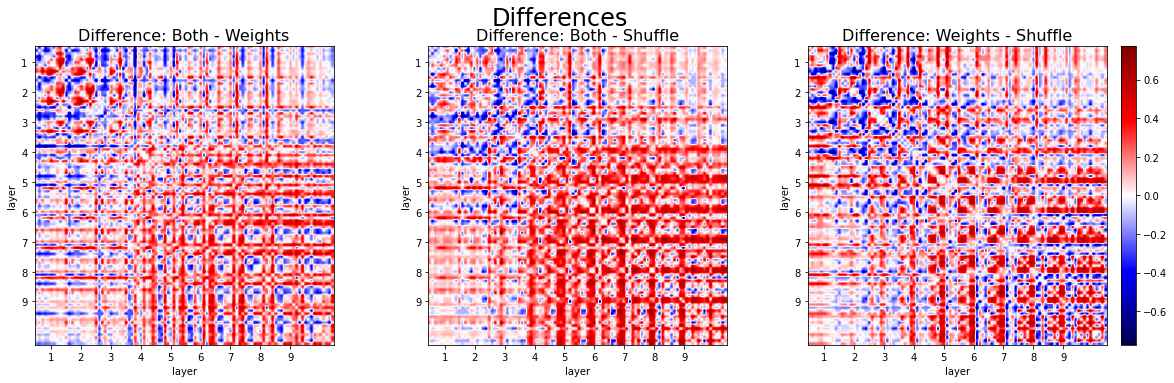

In [6]:
plot_triple_diff(weights=rsa_weights_traj_ten, shuffle=rsa_shuffle_traj_ten, both=rsa_both_traj_ten, title='Differences')

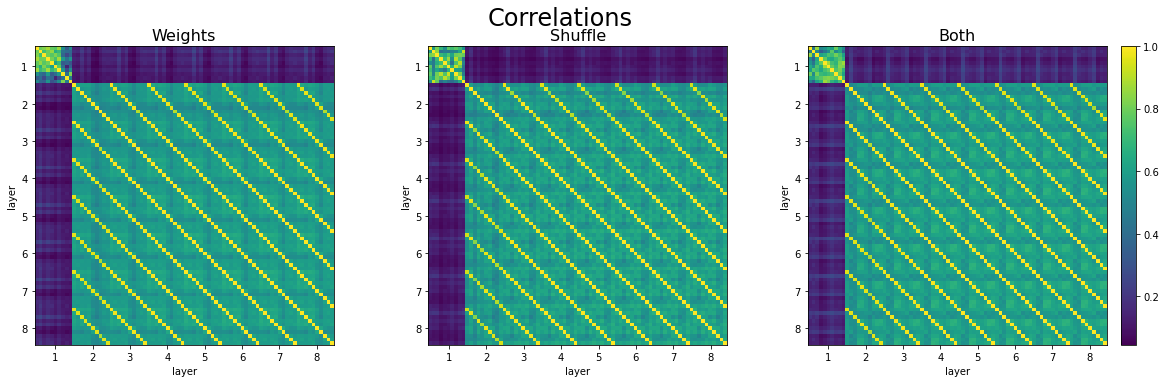

In [4]:
rsa_weights_traj_fifties = np.load('rsa_weights_traj_fifties.npy')
rsa_shuffle_traj_fifties = np.load('rsa_shuffle_traj_fifties.npy')
rsa_both_traj_fifties = np.load('rsa_both_traj_fifties.npy')

plot_triple_color(weights=rsa_weights_traj_fifties, shuffle=rsa_shuffle_traj_fifties, both=rsa_both_traj_fifties, title='Correlations')

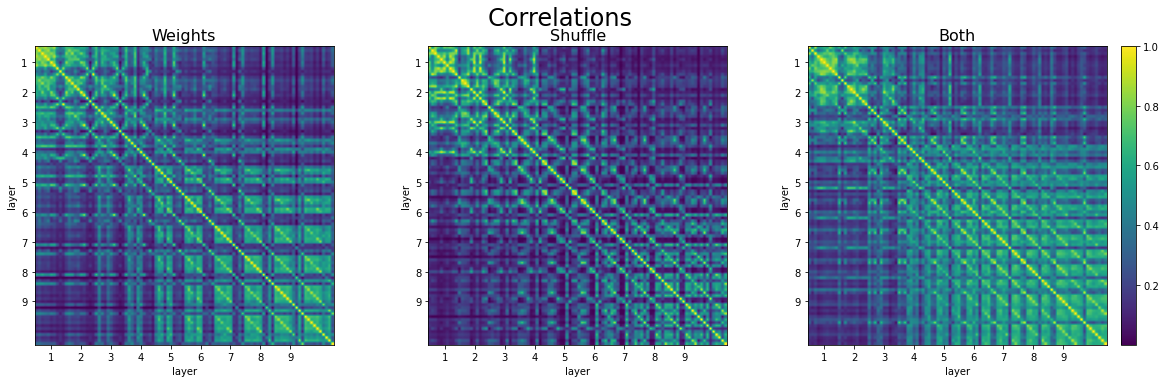

In [2]:
rsa_weights_traj_ten = np.load('rsa_weights_traj_ten.npy')
rsa_shuffle_traj_ten = np.load('rsa_shuffle_traj_ten.npy')
rsa_both_traj_ten = np.load('rsa_both_traj_ten.npy')

plot_triple_color(weights=rsa_weights_traj_ten, shuffle=rsa_shuffle_traj_ten, both=rsa_both_traj_ten, title='Correlations')

In [20]:
rsa_weights_tens = 1 - analysis.correlate_trajectory('first_ten', 'RSA', '../outputs/models/primary/', 
                                                '../outputs/representations/acts/weights/', x_predict, False)


* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000

Correlation 9 , 0
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 9 , 1
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 9 , 2
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 9 , 3
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 9 , 4
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 9 , 5
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 9 , 6
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 9 , 7
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 9 , 8
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 9 , 9
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 10 , 0
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 10 , 1
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 10 , 2
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 10 , 3
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 10 , 4
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 10 , 5
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 10 , 6
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correla

Correlation 18 , 16
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 18 , 17
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 18 , 18
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 19 , 0
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 19 , 1
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 19 , 2
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 19 , 3
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 19 , 4
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 19 , 5
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 19 , 6
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 19 , 7
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 19 , 8
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 19 , 9
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 19 , 10
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 19 , 11
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 19 , 12
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 19 , 13
Acts1: (1000, 1000)
Acts2: (10

Correlation 25 , 2
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 25 , 3
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 25 , 4
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 25 , 5
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 25 , 6
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 25 , 7
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 25 , 8
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 25 , 9
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 25 , 10
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 25 , 11
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 25 , 12
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 25 , 13
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 25 , 14
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 25 , 15
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 25 , 16
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 25 , 17
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 25 , 18
Acts1: (1000, 1000)
Acts2: (

Correlation 30 , 0
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 30 , 1
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 30 , 2
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 30 , 3
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 30 , 4
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 30 , 5
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 30 , 6
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 30 , 7
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 30 , 8
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 30 , 9
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 30 , 10
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 30 , 11
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 30 , 12
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 30 , 13
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 30 , 14
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 30 , 15
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 30 , 16
Acts1: (1000, 1000)
Acts2: (10

Correlation 34 , 9
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 34 , 10
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 34 , 11
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 34 , 12
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 34 , 13
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 34 , 14
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 34 , 15
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 34 , 16
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 34 , 17
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 34 , 18
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 34 , 19
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 34 , 20
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 34 , 21
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 34 , 22
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 34 , 23
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 34 , 24
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 34 , 25
Acts1: (1000, 1000)
A

Correlation 38 , 3
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 38 , 4
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 38 , 5
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 38 , 6
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 38 , 7
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 38 , 8
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 38 , 9
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 38 , 10
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 38 , 11
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 38 , 12
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 38 , 13
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 38 , 14
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 38 , 15
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 38 , 16
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 38 , 17
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 38 , 18
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 38 , 19
Acts1: (1000, 1000)
Acts2: 

Correlation 41 , 23
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 41 , 24
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 41 , 25
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 41 , 26
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 41 , 27
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 41 , 28
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 41 , 29
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 41 , 30
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 41 , 31
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 41 , 32
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 41 , 33
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 41 , 34
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 41 , 35
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 41 , 36
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 41 , 37
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 41 , 38
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 41 , 39
Acts1: (1000, 1000)


Correlation 44 , 32
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 44 , 33
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 44 , 34
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 44 , 35
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 44 , 36
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 44 , 37
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 44 , 38
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 44 , 39
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 44 , 40
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 44 , 41
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 44 , 42
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 44 , 43
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 44 , 44
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 45 , 0
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 45 , 1
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 45 , 2
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 45 , 3
Acts1: (1000, 1000)
Acts

Correlation 47 , 36
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 47 , 37
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 47 , 38
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 47 , 39
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 47 , 40
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 47 , 41
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 47 , 42
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 47 , 43
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 47 , 44
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 47 , 45
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 47 , 46
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 47 , 47
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 0
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 1
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 2
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 3
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 48 , 4
Acts1: (1000, 1000)
Acts2

Correlation 50 , 27
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 50 , 28
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 50 , 29
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 50 , 30
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 50 , 31
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 50 , 32
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 50 , 33
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 50 , 34
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 50 , 35
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 50 , 36
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 50 , 37
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 50 , 38
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 50 , 39
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 50 , 40
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 50 , 41
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 50 , 42
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 50 , 43
Acts1: (1000, 1000)


Correlation 53 , 10
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 53 , 11
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 53 , 12
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 53 , 13
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 53 , 14
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 53 , 15
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 53 , 16
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 53 , 17
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 53 , 18
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 53 , 19
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 53 , 20
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 53 , 21
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 53 , 22
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 53 , 23
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 53 , 24
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 53 , 25
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 53 , 26
Acts1: (1000, 1000)


Correlation 55 , 39
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 55 , 40
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 55 , 41
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 55 , 42
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 55 , 43
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 55 , 44
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 55 , 45
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 55 , 46
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 55 , 47
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 55 , 48
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 55 , 49
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 55 , 50
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 55 , 51
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 55 , 52
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 55 , 53
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 55 , 54
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 55 , 55
Acts1: (1000, 1000)


Correlation 58 , 8
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 58 , 9
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 58 , 10
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 58 , 11
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 58 , 12
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 58 , 13
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 58 , 14
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 58 , 15
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 58 , 16
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 58 , 17
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 58 , 18
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 58 , 19
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 58 , 20
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 58 , 21
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 58 , 22
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 58 , 23
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 58 , 24
Acts1: (1000, 1000)
Ac

Correlation 60 , 28
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 60 , 29
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 60 , 30
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 60 , 31
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 60 , 32
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 60 , 33
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 60 , 34
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 60 , 35
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 60 , 36
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 60 , 37
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 60 , 38
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 60 , 39
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 60 , 40
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 60 , 41
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 60 , 42
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 60 , 43
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 60 , 44
Acts1: (1000, 1000)


Correlation 62 , 43
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 62 , 44
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 62 , 45
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 62 , 46
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 62 , 47
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 62 , 48
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 62 , 49
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 62 , 50
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 62 , 51
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 62 , 52
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 62 , 53
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 62 , 54
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 62 , 55
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 62 , 56
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 62 , 57
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 62 , 58
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 62 , 59
Acts1: (1000, 1000)


Correlation 64 , 53
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 64 , 54
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 64 , 55
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 64 , 56
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 64 , 57
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 64 , 58
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 64 , 59
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 64 , 60
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 64 , 61
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 64 , 62
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 64 , 63
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 64 , 64
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 0
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 1
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 2
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 3
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 65 , 4
Acts1: (1000, 1000)
Acts2

Correlation 66 , 61
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 66 , 62
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 66 , 63
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 66 , 64
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 66 , 65
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 66 , 66
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 0
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 1
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 2
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 3
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 4
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 5
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 6
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 7
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 8
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 9
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 67 , 10
Acts1: (1000, 1000)
Acts2: (10

Correlation 68 , 65
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 68 , 66
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 68 , 67
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 68 , 68
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 0
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 1
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 2
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 3
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 4
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 5
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 6
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 7
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 8
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 9
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 10
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 11
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 69 , 12
Acts1: (1000, 1000)
Acts2: (10

Correlation 70 , 67
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 70 , 68
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 70 , 69
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 70 , 70
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 0
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 1
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 2
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 3
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 4
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 5
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 6
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 7
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 8
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 9
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 10
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 11
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 71 , 12
Acts1: (1000, 1000)
Acts2: (10

Correlation 72 , 65
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 72 , 66
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 72 , 67
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 72 , 68
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 72 , 69
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 72 , 70
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 72 , 71
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 72 , 72
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 0
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 1
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 2
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 3
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 4
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 5
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 6
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 7
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 73 , 8
Acts1: (1000, 1000)
Acts2: (1

Correlation 74 , 56
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 74 , 57
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 74 , 58
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 74 , 59
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 74 , 60
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 74 , 61
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 74 , 62
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 74 , 63
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 74 , 64
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 74 , 65
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 74 , 66
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 74 , 67
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 74 , 68
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 74 , 69
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 74 , 70
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 74 , 71
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 74 , 72
Acts1: (1000, 1000)


Correlation 76 , 44
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 76 , 45
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 76 , 46
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 76 , 47
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 76 , 48
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 76 , 49
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 76 , 50
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 76 , 51
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 76 , 52
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 76 , 53
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 76 , 54
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 76 , 55
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 76 , 56
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 76 , 57
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 76 , 58
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 76 , 59
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 76 , 60
Acts1: (1000, 1000)


Correlation 78 , 28
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 78 , 29
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 78 , 30
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 78 , 31
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 78 , 32
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 78 , 33
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 78 , 34
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 78 , 35
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 78 , 36
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 78 , 37
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 78 , 38
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 78 , 39
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 78 , 40
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 78 , 41
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 78 , 42
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 78 , 43
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 78 , 44
Acts1: (1000, 1000)


Correlation 80 , 9
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 80 , 10
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 80 , 11
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 80 , 12
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 80 , 13
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 80 , 14
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 80 , 15
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 80 , 16
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 80 , 17
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 80 , 18
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 80 , 19
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 80 , 20
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 80 , 21
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 80 , 22
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 80 , 23
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 80 , 24
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 80 , 25
Acts1: (1000, 1000)
A

Correlation 81 , 67
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 81 , 68
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 81 , 69
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 81 , 70
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 81 , 71
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 81 , 72
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 81 , 73
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 81 , 74
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 81 , 75
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 81 , 76
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 81 , 77
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 81 , 78
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 81 , 79
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 81 , 80
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 81 , 81
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 82 , 0
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 82 , 1
Acts1: (1000, 1000)
Ac

Correlation 83 , 39
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 83 , 40
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 83 , 41
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 83 , 42
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 83 , 43
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 83 , 44
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 83 , 45
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 83 , 46
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 83 , 47
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 83 , 48
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 83 , 49
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 83 , 50
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 83 , 51
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 83 , 52
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 83 , 53
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 83 , 54
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 83 , 55
Acts1: (1000, 1000)


Correlation 85 , 8
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 85 , 9
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 85 , 10
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 85 , 11
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 85 , 12
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 85 , 13
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 85 , 14
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 85 , 15
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 85 , 16
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 85 , 17
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 85 , 18
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 85 , 19
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 85 , 20
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 85 , 21
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 85 , 22
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 85 , 23
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 85 , 24
Acts1: (1000, 1000)
Ac

Correlation 86 , 63
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 86 , 64
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 86 , 65
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 86 , 66
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 86 , 67
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 86 , 68
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 86 , 69
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 86 , 70
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 86 , 71
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 86 , 72
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 86 , 73
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 86 , 74
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 86 , 75
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 86 , 76
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 86 , 77
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 86 , 78
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 86 , 79
Acts1: (1000, 1000)


Correlation 88 , 26
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 88 , 27
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 88 , 28
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 88 , 29
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 88 , 30
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 88 , 31
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 88 , 32
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 88 , 33
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 88 , 34
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 88 , 35
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 88 , 36
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 88 , 37
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 88 , 38
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 88 , 39
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 88 , 40
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 88 , 41
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 88 , 42
Acts1: (1000, 1000)


Correlation 89 , 77
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 89 , 78
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 89 , 79
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 89 , 80
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 89 , 81
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 89 , 82
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 89 , 83
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 89 , 84
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 89 , 85
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 89 , 86
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 89 , 87
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 89 , 88
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 89 , 89
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 90 , 0
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 90 , 1
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 90 , 2
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 90 , 3
Acts1: (1000, 1000)
Acts

Correlation 91 , 33
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 91 , 34
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 91 , 35
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 91 , 36
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 91 , 37
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 91 , 38
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 91 , 39
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 91 , 40
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 91 , 41
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 91 , 42
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 91 , 43
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 91 , 44
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 91 , 45
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 91 , 46
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 91 , 47
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 91 , 48
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 91 , 49
Acts1: (1000, 1000)


Correlation 92 , 80
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 92 , 81
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 92 , 82
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 92 , 83
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 92 , 84
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 92 , 85
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 92 , 86
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 92 , 87
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 92 , 88
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 92 , 89
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 92 , 90
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 92 , 91
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 92 , 92
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 93 , 0
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 93 , 1
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 93 , 2
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 93 , 3
Acts1: (1000, 1000)
Acts

Correlation 94 , 33
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 94 , 34
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 94 , 35
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 94 , 36
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 94 , 37
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 94 , 38
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 94 , 39
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 94 , 40
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 94 , 41
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 94 , 42
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 94 , 43
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 94 , 44
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 94 , 45
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 94 , 46
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 94 , 47
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 94 , 48
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 94 , 49
Acts1: (1000, 1000)


Correlation 95 , 77
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 95 , 78
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 95 , 79
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 95 , 80
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 95 , 81
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 95 , 82
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 95 , 83
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 95 , 84
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 95 , 85
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 95 , 86
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 95 , 87
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 95 , 88
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 95 , 89
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 95 , 90
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 95 , 91
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 95 , 92
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 95 , 93
Acts1: (1000, 1000)


Correlation 97 , 24
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 97 , 25
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 97 , 26
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 97 , 27
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 97 , 28
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 97 , 29
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 97 , 30
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 97 , 31
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 97 , 32
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 97 , 33
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 97 , 34
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 97 , 35
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 97 , 36
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 97 , 37
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 97 , 38
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 97 , 39
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 97 , 40
Acts1: (1000, 1000)


Correlation 98 , 63
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 98 , 64
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 98 , 65
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 98 , 66
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 98 , 67
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 98 , 68
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 98 , 69
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 98 , 70
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 98 , 71
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 98 , 72
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 98 , 73
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 98 , 74
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 98 , 75
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 98 , 76
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 98 , 77
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 98 , 78
Acts1: (1000, 1000)
Acts2: (1000, 1000)
Correlation 98 , 79
Acts1: (1000, 1000)


Layer 0
Getting activations...
Layer 2
Getting activations...
Layer 4
Getting activations...
Layer 6
Getting activations...
Layer 8
Getting activations...
Working on 0
(1000, 2)


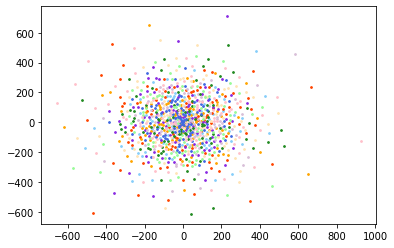

Working on 1
(1000, 2)


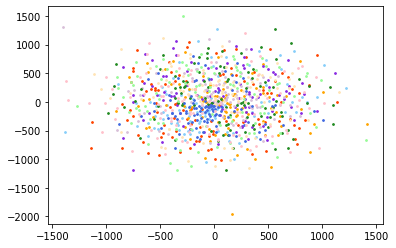

Working on 2
(1000, 2)


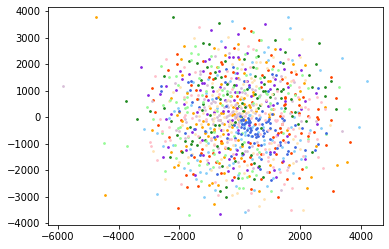

Working on 3
(1000, 2)


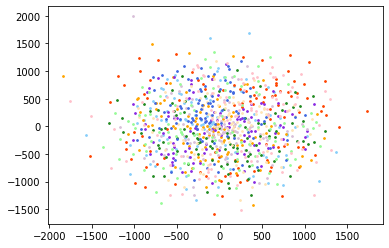

Working on 4
(1000, 2)


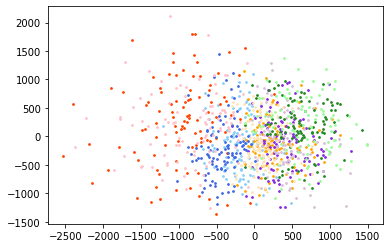

In [8]:
'''
ORIGINAL MDS: Not normalized
'''

# instances = os.listdir('../outputs/models/primary/')
# count = 0

# for instance in instances:
#     if count >= 10:
#         break
#     if '.h5' not in instance:
#         continue
K.clear_session()
model = load_model('../outputs/models/primary/instance_200.h5')
acts_list = analysis.get_acts(model, [0, 2, 4, 6, 8], x_predict, cocktail_blank=False)
embedding = MDS(n_components=2, dissimilarity='euclidean')
count = 0
colors = ['lightskyblue', 'orangered', 'orange', 'blueviolet', 'thistle',
          'forestgreen','moccasin', 'palegreen', 'royalblue', 'pink']
mds_list = []
for acts in acts_list:
    print('Working on', count)
    num_imgs, h, w, channels = acts.shape
    X_transformed = embedding.fit_transform(acts.reshape(num_imgs, h*w*channels))
    mds_list.append(X_transformed)
    print(X_transformed.shape)
    for i in range(10):
        plt.scatter(X_transformed[i*100 : (i+1)*100, 0], X_transformed[i*100 : (i+1)*100, 1], s=3, c=colors[i])
    plt.show()
    count += 1
    

Layer 0
Getting activations...
Layer 2
Getting activations...
Layer 4
Getting activations...
Layer 6
Getting activations...
Layer 8
Getting activations...
Working on 0


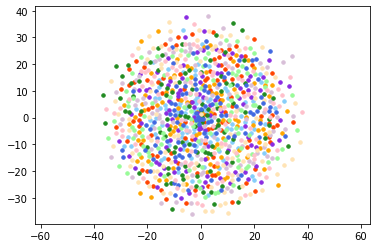

Working on 1


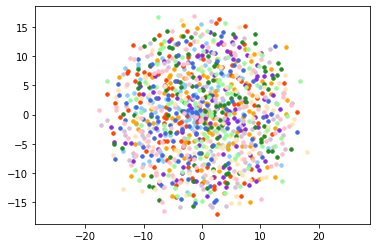

Working on 2


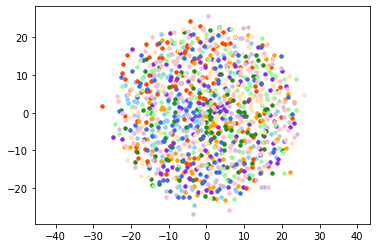

Working on 3


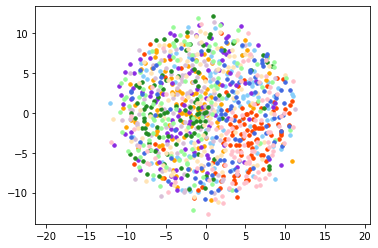

Working on 4


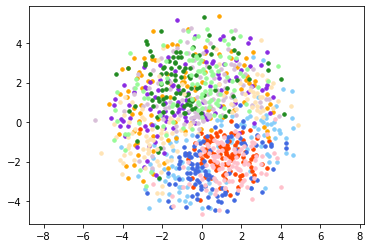

In [53]:
'''
NORMALIZED MDS: 0-center and normalize each datapoint's representation individually before plugging the
activation layer into MDS. Also force the scatterplot shape into a square
'''

# instances = os.listdir('../outputs/models/primary/')
# count = 0

# for instance in instances:
#     if count >= 10:
#         break
#     if '.h5' not in instance:
#         continue
K.clear_session()
model = load_model('../outputs/models/primary/instance_200.h5')
acts_list = analysis.get_acts(model, [0, 2, 4, 6, 8], x_predict, cocktail_blank=False)
embedding = MDS(n_components=2, dissimilarity='euclidean')
count = 0
colors = ['lightskyblue', 'orangered', 'orange', 'blueviolet', 'thistle',
          'forestgreen','moccasin', 'palegreen', 'royalblue', 'pink']
mds_list = []
for acts in acts_list:
    print('Working on', count)
    num_imgs, h, w, channels = acts.shape
    acts = acts.reshape(num_imgs, h*w*channels)
    for i in range(len(acts)):
        acts[i] -= np.mean(acts[i])
        acts[i] /= max([max(acts[i]), abs(min(acts[i]))])
    X_transformed = embedding.fit_transform(acts)
    mds_list.append(X_transformed)
    plt.axes().set_aspect('equal', adjustable='datalim')
    for i in range(10):
        plt.scatter(X_transformed[i*100 : (i+1)*100, 0], X_transformed[i*100 : (i+1)*100, 1], s=12, c=colors[i])
    plt.show()
    count += 1
    

Layer 0
Getting activations...
Layer 2
Getting activations...
Layer 4
Getting activations...
Layer 6
Getting activations...
Layer 8
Getting activations...
Working on 0


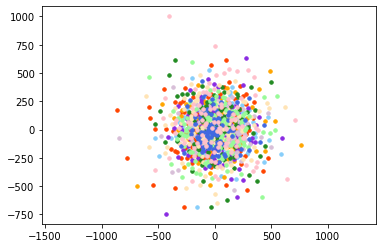

Working on 1


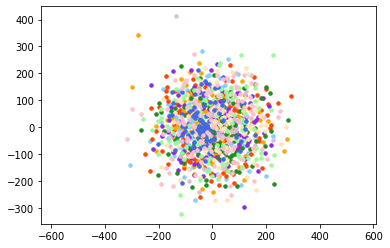

Working on 2


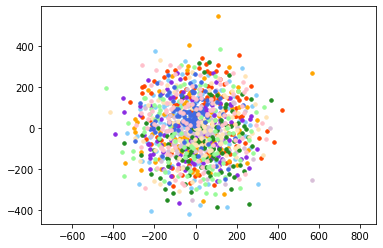

Working on 3


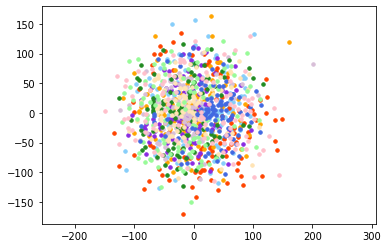

Working on 4


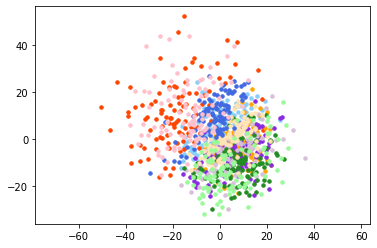

In [18]:
'''
NORMALIZED MDS: 0-center and normalize each datapoint's representation with std
'''

# instances = os.listdir('../outputs/models/primary/')
# count = 0

# for instance in instances:
#     if count >= 10:
#         break
#     if '.h5' not in instance:
#         continue
K.clear_session()
model = load_model('../outputs/models/primary/instance_200.h5')
acts_list = analysis.get_acts(model, [0, 2, 4, 6, 8], x_predict, cocktail_blank=False)
embedding = MDS(n_components=2, dissimilarity='euclidean')
count = 0
colors = ['lightskyblue', 'orangered', 'orange', 'blueviolet', 'thistle',
          'forestgreen','moccasin', 'palegreen', 'royalblue', 'pink']
mds_list = []
for acts in acts_list:
    print('Working on', count)
    num_imgs, h, w, channels = acts.shape
    acts = acts.reshape(num_imgs, h*w*channels)
#     for i in range(len(acts)):
#         acts[i] -= np.mean(acts[i])
#         acts[i] /= max([max(acts[i]), abs(min(acts[i]))])
    acts -= np.mean(acts, axis=0)
    # Whole set or just by axes?
    acts /= np.std(acts)
    X_transformed = embedding.fit_transform(acts)
    mds_list.append(X_transformed)
    plt.axes().set_aspect('equal', adjustable='datalim')
    for i in range(10):
        plt.scatter(X_transformed[i*100 : (i+1)*100, 0], X_transformed[i*100 : (i+1)*100, 1], s=12, c=colors[i])
    plt.show()
    count += 1
 

Layer 0
Getting activations...
Layer 2
Getting activations...
Layer 4
Getting activations...
Layer 6
Getting activations...
Layer 8
Getting activations...
Working on 0


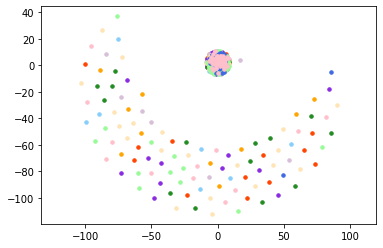

Working on 1


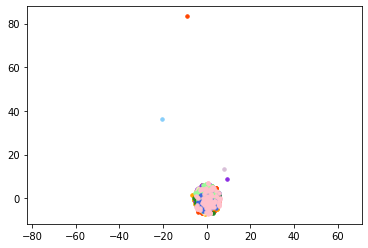

Working on 2


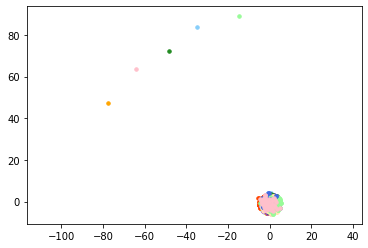

Working on 3


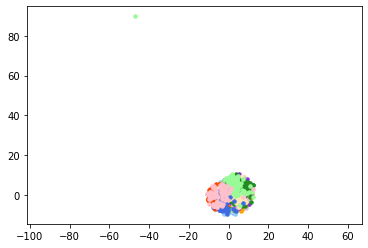

Working on 4


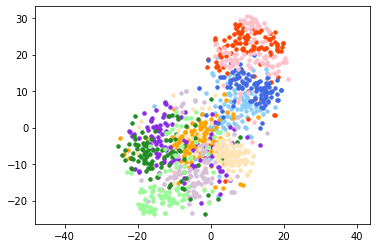

In [19]:
'''
REGULAR TSNE
'''
from sklearn.manifold import TSNE
# instances = os.listdir('../outputs/models/primary/')
# count = 0

# for instance in instances:
#     if count >= 10:
#         break
#     if '.h5' not in instance:
#         continue
K.clear_session()
model = load_model('../outputs/models/primary/instance_200.h5')
acts_list = analysis.get_acts(model, [0, 2, 4, 6, 8], x_predict, cocktail_blank=False)
embedding = TSNE()
count = 0
colors = ['lightskyblue', 'orangered', 'orange', 'blueviolet', 'thistle',
          'forestgreen','moccasin', 'palegreen', 'royalblue', 'pink']
mds_list = []
for acts in acts_list:
    print('Working on', count)
    num_imgs, h, w, channels = acts.shape
    acts = acts.reshape(num_imgs, h*w*channels)
#     for i in range(len(acts)):
#         acts[i] -= np.mean(acts[i])
#         acts[i] /= max([max(acts[i]), abs(min(acts[i]))])
#     acts -= np.mean(acts, axis=0)
#     # Whole set or just by axes?
#     acts /= np.std(acts)
    X_transformed = embedding.fit_transform(acts)
    mds_list.append(X_transformed)
    plt.axes().set_aspect('equal', adjustable='datalim')
    for i in range(10):
        plt.scatter(X_transformed[i*100 : (i+1)*100, 0], X_transformed[i*100 : (i+1)*100, 1], s=12, c=colors[i])
    plt.show()
    count += 1
 

Layer 0
Getting activations...
Layer 2
Getting activations...
Layer 4
Getting activations...
Layer 6
Getting activations...
Layer 8
Getting activations...
Working on 0


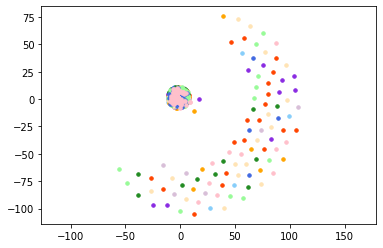

Working on 1


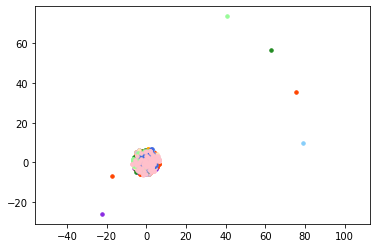

Working on 2


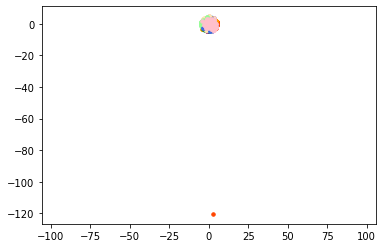

Working on 3


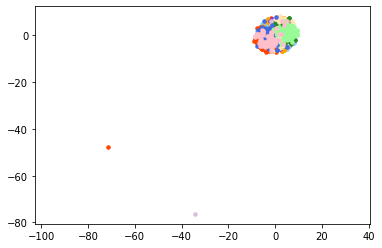

Working on 4


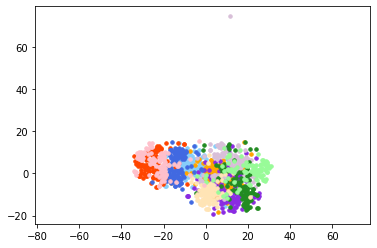

In [20]:
'''
NORMALIZED TSNE
'''
from sklearn.manifold import TSNE
# instances = os.listdir('../outputs/models/primary/')
# count = 0

# for instance in instances:
#     if count >= 10:
#         break
#     if '.h5' not in instance:
#         continue
K.clear_session()
model = load_model('../outputs/models/primary/instance_200.h5')
acts_list = analysis.get_acts(model, [0, 2, 4, 6, 8], x_predict, cocktail_blank=False)
embedding = TSNE()
count = 0
colors = ['lightskyblue', 'orangered', 'orange', 'blueviolet', 'thistle',
          'forestgreen','moccasin', 'palegreen', 'royalblue', 'pink']
mds_list = []
for acts in acts_list:
    print('Working on', count)
    num_imgs, h, w, channels = acts.shape
    acts = acts.reshape(num_imgs, h*w*channels)
#     for i in range(len(acts)):
#         acts[i] -= np.mean(acts[i])
#         acts[i] /= max([max(acts[i]), abs(min(acts[i]))])
    acts -= np.mean(acts, axis=0)
    # Whole set or just by axes?
    acts /= np.std(acts)
    X_transformed = embedding.fit_transform(acts)
    mds_list.append(X_transformed)
    plt.axes().set_aspect('equal', adjustable='datalim')
    for i in range(10):
        plt.scatter(X_transformed[i*100 : (i+1)*100, 0], X_transformed[i*100 : (i+1)*100, 1], s=12, c=colors[i])
    plt.show()
    count += 1
 

7/8: Do TSNE, look briefly into circles

Do the 10x10 shufflexseed experiment (cont)

In [64]:
acts = analysis.get_acts(load_model('../outputs/models/primary/instance_200.h5'),
                         range(9), x_predict, cocktail_blank=False)

Layer 0
Getting activations...
Layer 1
Getting activations...
Layer 2
Getting activations...
Layer 3
Getting activations...
Layer 4
Getting activations...
Layer 5
Getting activations...
Layer 6
Getting activations...
Layer 7
Getting activations...
Layer 8
Getting activations...


In [69]:
embedding = MDS(n_components=2, dissimilarity='precomputed')
num_imgs, h, w, channels = acts[0].shape
rdm = analysis.get_rdm(acts[0].reshape(num_imgs, h*w*channels))
X_transformed = embedding.fit_transform(rdm)
print(X_transformed.shape)

shape: (1000, 98304)
num_images = 1000
(1000, 2)


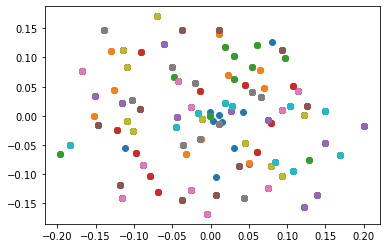

In [76]:
for i in range(10):
    plt.scatter(X_transformed[i*100 :: 10, 0], X_transformed[i*100 :: 10, 1])
plt.show()

shape: (1000, 360)
num_images = 1000
(1000, 2)


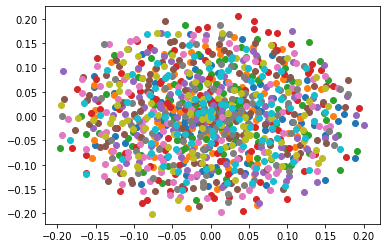

In [71]:
embedding = MDS(n_components=2, dissimilarity='precomputed')
num_imgs, h, w, channels = acts[8].shape
rdm = analysis.get_rdm(acts[8].reshape(num_imgs, h*w*channels))
X_transformed = embedding.fit_transform(rdm)
print(X_transformed.shape)
for i in range(10):
    plt.scatter(X_transformed[i*100 : (i+1)*100, 0], X_transformed[i*100 : (i+1)*100, 1])
plt.show()

In [7]:
'''
Visualize Transfrom Baseline
'''

color_rsa_weights = baseline.transform_baseline(x_predict, 'color', 
                                       load_model('../outputs/models/primary/instance_200.h5'),
                                       7, analysis.do_rsa)

NameError: name 'baseline' is not defined

In [5]:
import importlib
importlib.reload(analysis_10x10)
# tenByTen = analysis_10x10.correlate('RSA',
#                                     '../outputs/models/ten_by_ten',
#                                     range(10),
#                                     range(10),
#                                     x_predict,
#                                     np.load('../outputs/tracker_complete.npy'),
#                                     'exemplar',
#                                     True)
    
method = 'RSA'
path_to_instances = '../outputs/models/ten_by_ten'
weight_seeds = range(10)
shuffle_seeds = range(10)
tracker = np.array([[1, 1, 2, 2, 1, 2, 1, 1, 1, 1],
       [2, 2, 2, 2, 1, 1, 1, 1, 2, 2],
       [1, 1, 1, 2, 2, 1, 2, 2, 2, 2],
       [1, 1, 2, 1, 1, 1, 1, 1, 2, 1],
       [2, 1, 2, 2, 2, 1, 1, 1, 1, 1],
       [1, 2, 2, 1, 2, 2, 1, 1, 2, 1],
       [1, 1, 2, 2, 2, 1, 2, 1, 1, 2],
       [2, 2, 2, 1, 2, 1, 2, 1, 1, 2],
       [2, 1, 2, 2, 1, 2, 2, 2, 2, 1],
       [1, 2, 2, 2, 2, 2, 2, 1, 2, 2]])
consistency = 'exemplar'
cocktail_blank=True


In [6]:
tracker

array([[1, 1, 2, 2, 1, 2, 1, 1, 1, 1],
       [2, 2, 2, 2, 1, 1, 1, 1, 2, 2],
       [1, 1, 1, 2, 2, 1, 2, 2, 2, 2],
       [1, 1, 2, 1, 1, 1, 1, 1, 2, 1],
       [2, 1, 2, 2, 2, 1, 1, 1, 1, 1],
       [1, 2, 2, 1, 2, 2, 1, 1, 2, 1],
       [1, 1, 2, 2, 2, 1, 2, 1, 1, 2],
       [2, 2, 2, 1, 2, 1, 2, 1, 1, 2],
       [2, 1, 2, 2, 1, 2, 2, 2, 2, 1],
       [1, 2, 2, 2, 2, 2, 2, 1, 2, 2]])

In [11]:
preprocess_func, corr_func = analysis.get_funcs(method)

# Create matrix to store representations in
all_acts = [[], [], [], [], [], [], [], [], [], []]
for w in weight_seeds:
    for s in shuffle_seeds:
        # Not a real numpy file, just a naming mistake
        instance = load_model(os.path.join(path_to_instances, 'w'+str(w)+'s'+str(s)+'.npy'))
        acts = analysis.get_acts(instance, [7], x_predict, cocktail_blank)[0]
        all_acts[w].append(preprocess_func(acts, consistency))

# Get the mean representation to compare everything against
indices = np.argwhere(tracker == 2)
avg = np.zeros(all_acts[0][0].shape)
total = 0
for index in indices:
    w = index[0]
    s = index[1]
    if tracker[w, s] == 2:
        acts = all_acts[w][s]
        avg += acts
        total += 1

avg /= total

# Get the correlations
correlations = np.zeros((10, 10))
for w in range(correlations.shape[0]):
    for s in range(correlations.shape[1]):
        if tracker[w, s] == 2:
            correlations[w, s] = corr_func(all_acts[w][s], avg)

print('Done!')

Layer 7
Getting activations...
shape: (1000, 6912)
num_images = 1000
Layer 7
Getting activations...
shape: (1000, 6912)
num_images = 1000
Layer 7
Getting activations...
shape: (1000, 6912)
num_images = 1000
Layer 7
Getting activations...
shape: (1000, 6912)
num_images = 1000
Layer 7
Getting activations...
shape: (1000, 6912)
num_images = 1000
Layer 7
Getting activations...
shape: (1000, 6912)
num_images = 1000
Layer 7
Getting activations...
shape: (1000, 6912)
num_images = 1000
Layer 7
Getting activations...
shape: (1000, 6912)
num_images = 1000
Layer 7
Getting activations...
shape: (1000, 6912)
num_images = 1000
Layer 7
Getting activations...
shape: (1000, 6912)
num_images = 1000
Layer 7
Getting activations...
shape: (1000, 6912)
num_images = 1000
Layer 7
Getting activations...
shape: (1000, 6912)
num_images = 1000
Layer 7
Getting activations...
shape: (1000, 6912)
num_images = 1000
Layer 7
Getting activations...
shape: (1000, 6912)
num_images = 1000
Layer 7
Getting activations...
sha

[[0.         0.         0.84125587 0.84005382 0.         0.7951752
  0.         0.         0.         0.        ]
 [0.83294073 0.81834314 0.81489906 0.83804476 0.         0.
  0.         0.         0.76773082 0.8125937 ]
 [0.         0.         0.         0.82181911 0.78871418 0.
  0.81338564 0.76593756 0.79690411 0.77747442]
 [0.         0.         0.81901604 0.         0.         0.
  0.         0.         0.79674191 0.        ]
 [0.77458303 0.         0.80417198 0.83719448 0.83227786 0.
  0.         0.         0.         0.        ]
 [0.         0.78936766 0.81445375 0.         0.7935791  0.82279366
  0.         0.         0.80570201 0.        ]
 [0.         0.         0.83712534 0.81214868 0.78553775 0.
  0.83295924 0.         0.         0.82150516]
 [0.84549013 0.78376692 0.83336311 0.         0.82237274 0.
  0.80551419 0.         0.         0.81249575]
 [0.80412482 0.         0.74009681 0.81790401 0.         0.80949542
  0.84422752 0.81469971 0.83111075 0.        ]
 [0.         0

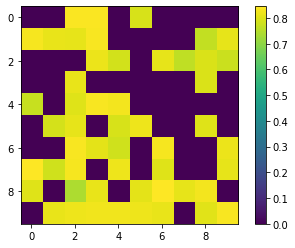

In [15]:
plt.imshow(correlations)
plt.colorbar()

print(correlations)

In [107]:
'''
Save weights
'''
# np.save('pwcca_weights.npy', pwcca_weights)
# np.save('pwcca_shuffle.npy', pwcca_shuffle)
# np.save('svcca_weights.npy', svcca_weights)
# np.save('svcca_shuffle.npy', svcca_shuffle)
# np.save('rsa_weights.npy', rsa_weights)
# np.save('rsa_shuffle.npy', rsa_shuffle)
# np.save('rsa_both.npy', rsa_both)
# np.save('pwcca_both.npy', pwcca_both)
# np.save('svcca_both.npy', svcca_both)
pwcca_weights = np.load('pwcca_weights.npy')
svcca_weights = np.load('svcca_weights.npy')
rsa_weights = np.load('rsa_weights.npy')
pwcca_shuffle = np.load('pwcca_shuffle.npy')
svcca_shuffle = np.load('svcca_shuffle.npy')
rsa_shuffle = np.load('rsa_shuffle.npy')
pwcca_both = np.load('pwcca_both.npy')
svcca_both = np.load('svcca_both.npy')
rsa_both = np.load('rsa_both.npy')


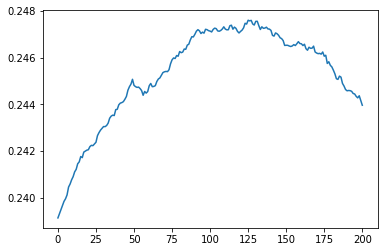

In [10]:
plt.plot(color_rsa_weights)